# interpret static embedding

In [17]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
import torch
from ruamel.yaml import YAML
mpl.rcParams['figure.dpi'] = 150

In [18]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [19]:
%load_ext autoreload
%autoreload 2

In [20]:
from collections import defaultdict

import sys
sys.path.append("../..")

In [443]:
pwd

'/home/tommy/ml_drought/notebooks/draft'

# Code

In [21]:
print([d.name for d in (data_dir / "runs/").iterdir()])
print([d.name for d in (data_dir / "runs/ealstm_less_vars_2004_1607_1334").glob("*")])

(data_dir / "runs/ealstm_less_vars_2004_1607_1334")
(data_dir / "runs/lstm_less_vars_2004_1507_1028")

['ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028', 'train_data.h5', 'train_data_scaler.p', 'lstm_ALL_vars_2004_2210_1035', 'lstm_all_vars_1998_2008_2210_110347', 'lstm_all_vars_1998_2008_2210_110727', 'lstm_all_vars_1998_2008_nh_2310_101443', 'lstm_all_vars_1998_2008_nh_2310_142625', 'ensemble__', 'ensemble_EALSTM', 'ensemble_lstm10', 'ensemble', '0_ensemble_results']
[]


PosixPath('/cats/datastore/data/runs/lstm_less_vars_2004_1507_1028')

In [22]:
import sys
sys.path.insert(1, '/home/tommy/neuralhydrology')

from neuralhydrology.modelzoo.ealstm import EALSTM
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.datasetzoo.camelsgb import CamelsGB
from neuralhydrology.datautils.utils import load_basin_file
from neuralhydrology.utils.config import Config
from neuralhydrology.utils.errors import NoTrainDataError
from neuralhydrology.training.train import BaseTrainer

## Load in config file

In [91]:
run_dir = data_dir / "runs/ensemble_EALSTM/ealstm_ensemble6_nse_1998_2008_2910_030601"

# Config file
config_path = (run_dir / "config.yml") 
config = Config(config_path)

## Extra Processes

In [30]:
# Get the list of basins that we actually have results for
lstm_preds_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_preds_df["time"] = pd.to_datetime(lstm_preds_df["time"])
lstm_preds = lstm_preds_df.set_index(["station_id", "time"]).to_xarray()

VALID_BASINS = (lstm_preds_df["station_id"].unique())

In [31]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Create Model Embeddings

In [94]:
(run_dir / "model_epoch030.pt")

PosixPath('/cats/datastore/data/runs/ensemble_EALSTM/ealstm_ensemble6_nse_1998_2008_2910_030601/model_epoch030.pt')

In [95]:
# torch.load(model_path, map_location="cpu")

In [96]:
# Initialize model
# EA LSTM
model = EALSTM(config)
model_path = run_dir / "model_epoch030.pt"
model.load_state_dict(torch.load(model_path, map_location="cpu"))


# LSTM
lstm_run_dir = data_dir / "runs/ensemble/lstm_ensemble6_nse_1998_2008_2710_171032"
cfg_lstm = Config(lstm_run_dir / "config.yml")
lstm_model = CudaLSTM(cfg_lstm)
lstm_model.lstm = LSTM(25, 64)
lstm_model_path = lstm_run_dir / "model_epoch030.pt"
lstm_model.load_state_dict(torch.load(lstm_model_path, map_location="cpu"))

<All keys matched successfully>

In [97]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("EA LSTM Total Parameters:", pytorch_total_params)
# If you want to calculate only the trainable parameters:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("EA LSTM Total Trainable Parameters:", pytorch_total_params)

pytorch_total_params = sum(p.numel() for p in lstm_model.parameters())
print("LSTM Total Parameters:", pytorch_total_params)
# If you want to calculate only the trainable parameters:
pytorch_total_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)
print("LSTM Total Trainable Parameters:", pytorch_total_params)

EA LSTM Total Parameters: 14593
EA LSTM Total Trainable Parameters: 14593
LSTM Total Parameters: 23361
LSTM Total Trainable Parameters: 23361


In [642]:
# print([d for d in dir(config)])
# [d.name for d in  (config.train_dir).iterdir()]
scaler_file = config.train_dir / "train_data_scaler.p"
scaler = pickle.load(scaler_file.open("rb"))

In [147]:
try: 
    globals()["data"]
except KeyError:
    # load data
    data = CamelsGB(config, is_train=False, period="test", scaler=scaler)
    
data

In [148]:
assert config.test_basin_file.exists(), "Need the basin file list to work!"

# get static weights/biases
static_weights, static_bias = [p for p in model.input_gate.parameters()]

# Calculate the embeddings
ignore_basins = []
all_embeddings = []
for basin in tqdm(basins):
    try:
        # get the static data
        raw_static = data.attributes[basin]

        # Do the calculation here
        input_gate = torch.sigmoid(model.input_gate(raw_static))
        embedding = input_gate.detach().numpy()
        all_embeddings.append(embedding)

    except KeyError:
        print(f"{basin} has no training data")
        ignore_basins.append(basin)

all_embeddings = np.array(all_embeddings)
embed_dict = {"embeddings": all_embeddings, "missing_basins": ignore_basins, "all_basins": basins}

100%|██████████| 669/669 [00:00<00:00, 16025.25it/s]


Each column corresponds to one basin and the rows denote the input gate value of the **`n hidden`** LSTM cells. The basins are ordered by ascending CAMELS GB gauge id.

Text(0, 0.5, 'Activation')

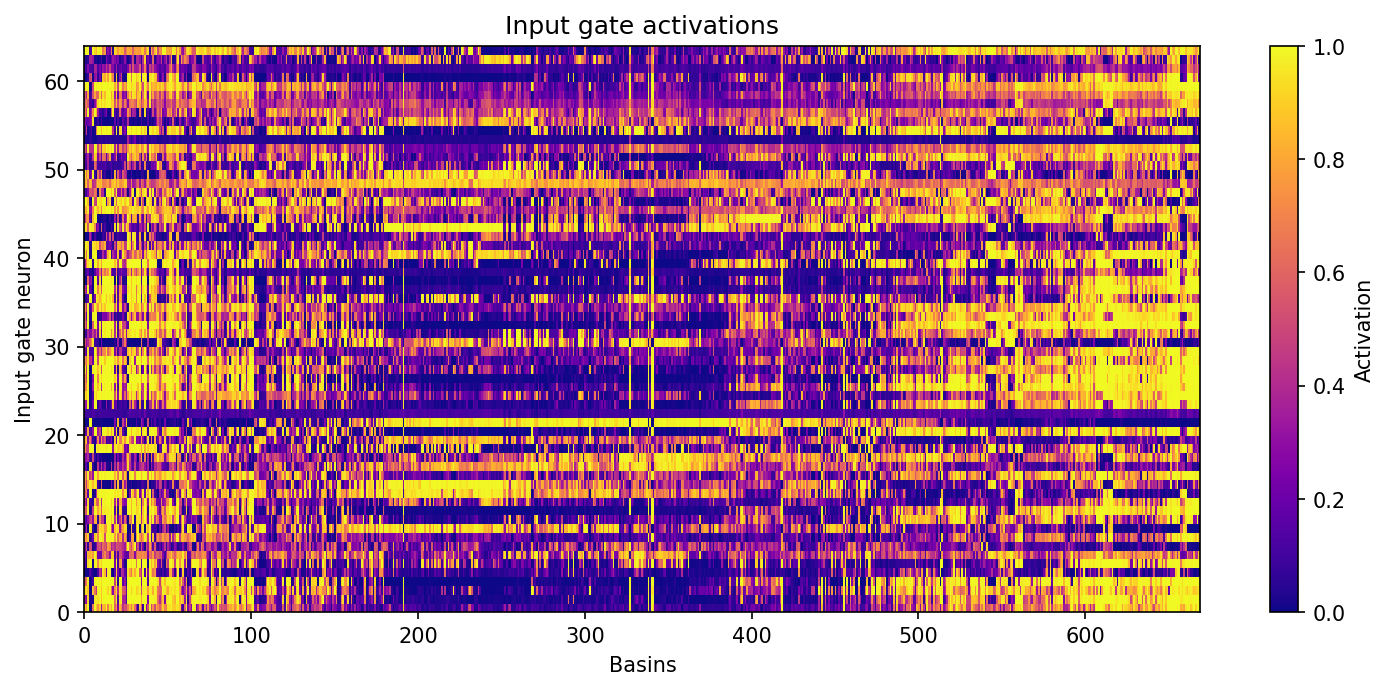

In [149]:
fig, ax = plt.subplots(figsize=(12,5))
img = ax.pcolor(all_embeddings.T, cmap='plasma')
ax.set_xlabel("Basins")
ax.set_ylabel("Input gate neuron")
ax.set_title("Input gate activations")
cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Activation")

In [181]:
def order_by_static_feature(static_feature: str) -> np.ndarray:
    feature_order = all_static.sel(station_id=np.isin(all_static["station_id"], basins))[["gauge_name", static_feature]].sortby(static_feature).station_id.values
    
    # create df of reordered index
    d = pd.DataFrame({"station_id": feature_order})
    d = d.reset_index().rename({"index": "idx"}, axis=1).set_index("station_id")
    reorder = d.loc[feature_order].reset_index().idx.values
    
    return reorder

reorder = order_by_static_feature("aridity")

In [183]:
# fig, ax = plt.subplots(figsize=(12,5))
# img = ax.pcolor(all_embeddings.T[:, reorder], cmap='plasma')
# ax.set_xlabel("Basins")
# ax.set_ylabel("Input gate neuron")
# ax.set_title("Input gate activations: Ordered by Aridity")
# cbar = plt.colorbar(img, ax=ax)
# cbar.ax.set_ylabel("Activation")

# Interpret Static Embeddings

In [184]:
from scripts.drafts.clusterutils import get_silhouette_scores, get_clusters, get_label_2_color, get_variance_reduction

### Cluster analysis

In [210]:
# load raw attributes and normalise
df_raw = static[config.camels_attributes].to_dataframe().loc[[int(b) for b in basins]]
df_norm = (df_raw - df_raw.mean()) / df_raw.std()

# DROP the stations with missing data
df_norm = df_norm[np.isin(df_norm.index, VALID_BASINS)]
raw_features = df_norm.values

# Check that the order of basins is the same in embedding / static
assert all([str(si) == basins[ix] for ix, si in enumerate(df_norm.index)])

### silhouette scores

In [288]:
# f1 = (data_dir / "RUNOFF/lstm_silhouette_scores_means.pkl")
# f2 = (data_dir / "RUNOFF/lstm_silhouette_scores_mins.pkl")

# if (not f1.exists()) & (not f2.exists()):

#     with f1.open("wb") as f:
#         pickle.dump(lstm_scores_means, f)
#     with f2.open("wb") as f:
#         pickle.dump(lstm_scores_mins, f)

# else:
#     lstm_scores_means = pickle.load(f1.open("rb"))
#     lstm_scores_mins = pickle.load(f2.open("rb"))

# f1 = (data_dir / "RUNOFF/raw_silhouette_scores_means.pkl")
# f2 = (data_dir / "RUNOFF/raw_silhouette_scores_mins.pkl")
#     with f1.open("wb") as f:
#         pickle.dump(raw_scores_means, f)
#     with f2.open("wb") as f:
#         pickle.dump(raw_scores_mins, f)
# else:
#     raw_scores_means = pickle.load(f1.open("rb"))
#     raw_scores_mins = pickle.load(f2.open("rb"))

In [290]:
from typing import DefaultDict, List

def calculate_ealstm_silhouette_scores(all_embeddings) -> DefaultDict[str, List]:
    lstm_scores_means = defaultdict(list)
    lstm_scores_mins = defaultdict(list)

    # for each basin embedding calc a distribution of 
    for lstm_embedding in tqdm(all_embeddings):
        stacked_embedding = lstm_embedding.reshape(-1, 1)
        mean_scores, min_scores = get_silhouette_scores(stacked_embedding)
        for cluster, values in mean_scores.items():
            lstm_scores_means[cluster].append(values)
        for cluster, values in min_scores.items():
            lstm_scores_mins[cluster].append(values)
            
    return lstm_scores_means, lstm_scores_mins


f1 = (data_dir / "RUNOFF/ealstm_silhouette_scores_means.pkl")
f2 = (data_dir / "RUNOFF/ealstm_silhouette_scores_mins.pkl")

if (not f1.exists()) & (not f2.exists()):
    print("==> Calculate mean/min silhouette scores for the EA-LSTM embedding")
    lstm_scores_means, lstm_scores_mins = calculate_ealstm_silhouette_scores(all_embeddings)
    
    # dump to pickle (takes a while)
    with f1.open("wb") as f:
        pickle.dump(lstm_scores_means, f)
    with f2.open("wb") as f:
        pickle.dump(lstm_scores_mins, f)
else:
    lstm_scores_means = pickle.load(f1.open("rb"))
    lstm_scores_mins = pickle.load(f2.open("rb"))

In [291]:
print("==> Calculate mean/min silhouette scores for the raw catchment attributes")
raw_scores_means, raw_scores_mins = get_silhouette_scores(raw_features)

==> Calculate mean/min silhouette scores for the raw catchment attributes


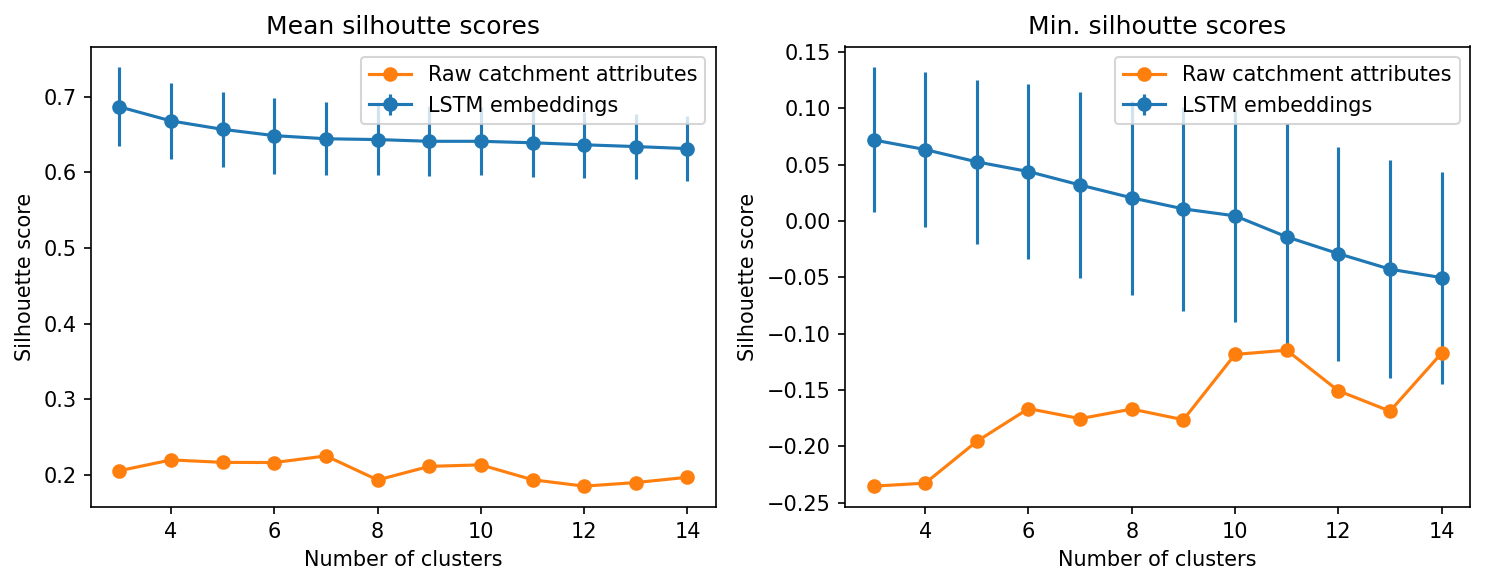

In [292]:
# Plot the results
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

# plot 
ax[0].errorbar(x=list(lstm_scores_means.keys()), 
            y=[np.mean(vals) for vals in list(lstm_scores_means.values())],
            yerr = [np.std(vals) for vals in list(lstm_scores_means.values())],
            marker='o', 
            markevery=1,
            label="LSTM embeddings")

# plot raw scores
ax[0].plot(list(raw_scores_means.keys()), 
        list(raw_scores_means.values()), 
        marker='o', 
        markevery=1,
        label="Raw catchment attributes")

ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Silhouette score")
ax[0].set_title("Mean silhoutte scores")
ax[0].legend()

#
ax[1].errorbar(x=list(lstm_scores_mins.keys()), 
            y=[np.mean(vals) for vals in list(lstm_scores_mins.values())],
            yerr = [np.std(vals) for vals in list(lstm_scores_mins.values())],
            marker='o', 
            markevery=1,
            label="LSTM embeddings")

# plot raw scores
ax[1].plot(list(raw_scores_mins.keys()), 
        list(raw_scores_mins.values()), 
        marker='o', 
        markevery=1,
        label="Raw catchment attributes")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Min. silhoutte scores")
ax[1].legend()
plt.tight_layout()

### K Means Clustering

In [558]:
from sklearn.cluster import KMeans
embeddings = dict(zip([int(s) for s in basins], all_embeddings))
basin_ids = [int(s) for s in basins]

### DEFINE NUMBER OF CLUSTERS (pick 2) ###
ks = [3, 4]
# ---------------------------------------# 

clusters = {k: defaultdict(dict) for k in ks}
for k in ks:
    for name in ['lstm', 'raw']:
        if name == "lstm":
            features = np.array(list(embeddings.values()))
        else:
            features = raw_features
        clusterer = KMeans(n_clusters=k, random_state=0, init='k-means++',
                           n_init=200).fit(features)
        for basin in basin_ids:
            if name == 'lstm':
                emb = embeddings[basin]
            else:
                emb = df_norm.loc[df_norm.index == int(basin)].values
            clusters[k][name][basin] = clusterer.predict(emb.reshape(1, -1))[0]

### Plot the clusters

In [559]:
# Create GeoDataFrame of clusters
all_s_df = static.sel(station_id=np.isin(all_static.station_id, df_raw.index)).to_dataframe()
gauge_lats = all_s_df.loc[:,"gauge_lat"]
gauge_lons = all_s_df.loc[:,"gauge_lon"]

### Run KMEANs

In [560]:
from shapely.geometry import Point
import geopandas as gpd

clusters_dict = {}
for n_cluster in clusters.keys():
#     n_cluster = [k for k in clusters.keys()][0]

    cluster_df = pd.DataFrame(
        {
            "station_id": [k for k in clusters[n_cluster]["lstm"].keys()], 
            "lstm": [k for k in clusters[n_cluster]["lstm"].values()],
            "raw": [k for k in clusters[n_cluster]["raw"].values()],
        }
    )
    cluster_df["clusters"] = [n_cluster for _ in range(len(cluster_df))]
    cluster_df = cluster_df.set_index("station_id").join(gauge_lats).join(gauge_lons).reset_index()
    cluster_gdf = gpd.GeoDataFrame(
        cluster_df, geometry=[Point((lat, lon)) for lat, lon in zip(cluster_df["gauge_lat"], cluster_df["gauge_lon"])]
    )
    clusters_dict[n_cluster] = cluster_gdf

### PLOT Spatial Results

In [561]:
# LOAD in the UK Hi-res borders
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")

In [628]:
from typing import DefaultDict, Dict 


def get_label_2_color(cluster_df: pd.DataFrame) -> DefaultDict[str, Dict[int, str]]:
    assert all(np.isin(("lstm", "raw", "station_id"), cluster_df.columns))
    color_list = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#e6ab02', '#66a61e']
#     color_list = sns.color_palette()

    # Get which basins are in each group
    basin_in_cluster = defaultdict(dict)

    lstm_groups = cluster_df.groupby("lstm")['station_id'].apply(list).to_frame()
    raw_groups = cluster_df.groupby("raw")['station_id'].apply(list).to_frame()

    # which cluster does the basin belong to (LSTM cluster)
    for group, basins in lstm_groups.iterrows():
        basin_in_cluster["lstm"][group] = basins.values[0]
    # which cluster does the basin belong to (raw cluster)
    for group, basins in raw_groups.iterrows():
        basin_in_cluster["raw"][group] = basins.values[0]

    # assign the same color to the clusters with max overlap
    label_2_color = defaultdict(dict)

    for label, basins in basin_in_cluster["lstm"].items():
        label_2_color["lstm"][label] = color_list[label]

        max_count = -1
        color_label = None
        for label2, basins2 in basin_in_cluster["raw"].items():
            intersect = set(basins).intersection(basins2)
            if len(intersect) > max_count:
                max_count = len(intersect)
                color_label = label2

        label_2_color["raw"][color_label] = color_list[label]
        
    # assign the missing key/color
    is_matching_keys = np.isin([k for k in label_2_color["lstm"].keys()], [k for k in label_2_color["raw"].keys()])
    if not all(is_matching_keys):
        is_missing_color = np.isin([k for k in label_2_color["lstm"].values()], [k for k in label_2_color["raw"].values()])
        missing_keys = np.array([k for k in label_2_color["lstm"].keys()])[~is_matching_keys]
        missing_colors = np.array([k for k in label_2_color["lstm"].values()])[~is_missing_color]
        
        if len(missing_colors.shape) > 1:
            for missing_key, missing_color in zip(missing_keys, missing_colors):
                label_2_color["raw"][missing_key] = missing_color
        else: 
            label_2_color["raw"][missing_keys[0]] = missing_colors if not "#" in missing_colors[0] else missing_colors[0] 
        
    return label_2_color

In [630]:
# sns.palplot(label_2_color["lstm"])
# sns.palplot(label_2_color["raw"])
# "#" in label_2_color["raw"][2][0]
label_2_color["raw"]
label_2_color["lstm"]

{0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}

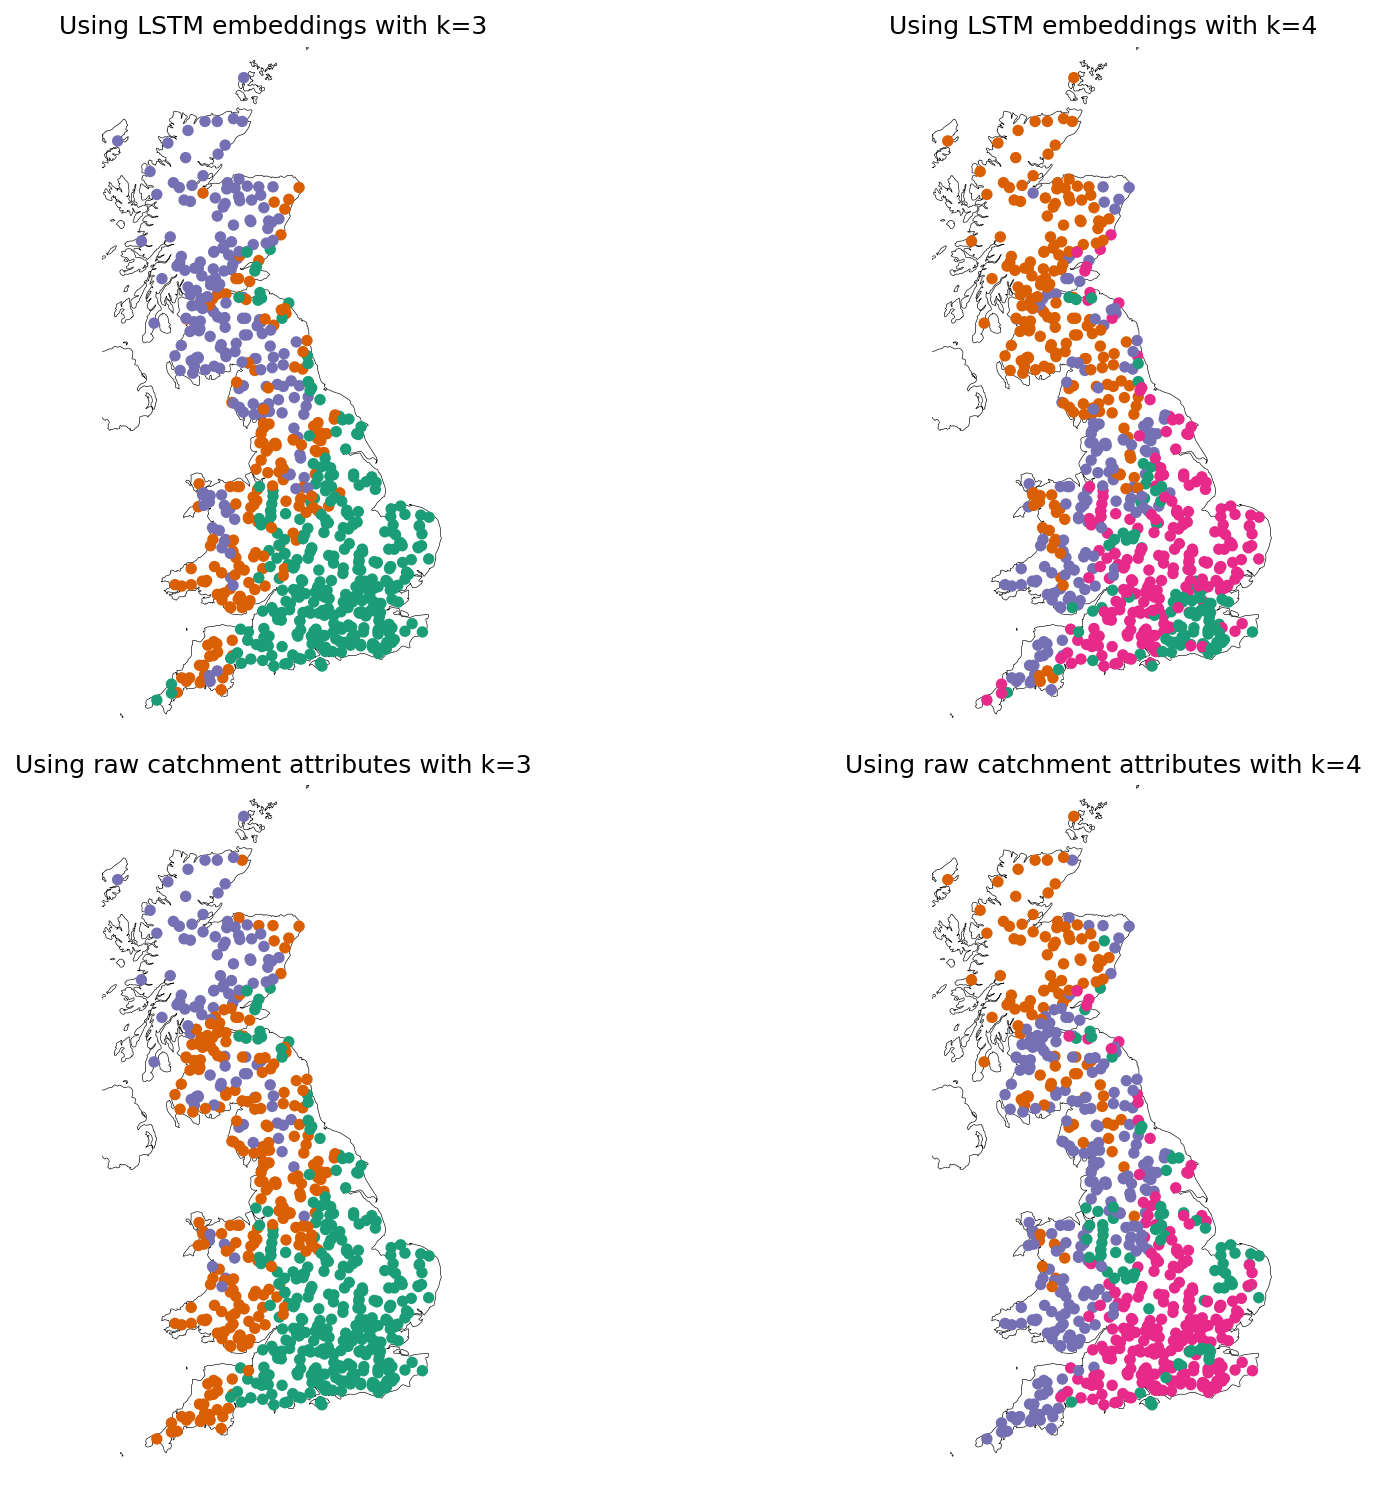

In [631]:
# draw the maps
attributes = static
plot_outline = True

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

for i, k in enumerate(clusters.keys()):
    cluster_gdf = clusters_dict[k]
    label_2_color = get_label_2_color(cluster_gdf)
    for j, name in enumerate(clusters[k].keys()):

        data = defaultdict(list)
        for basin, label in clusters[k][name].items():
            data["lat"].append(cluster_gdf.loc[cluster_gdf["station_id"] == basin, "gauge_lat"].values)
            data["lon"].append(cluster_gdf.loc[cluster_gdf["station_id"] == basin, "gauge_lon"].values)
            data["color"].append(label_2_color[name][label])


        points = ax[j,i].scatter(x=data["lon"],
                                 y=data["lat"],
                                 c=data["color"],
                                 s=30, 
                                 zorder=2,
                                 edgecolor='none', 
                                 linewidth=0.5)
        
        if plot_outline:
            uk.plot(facecolor='none', edgecolor='k', ax=ax[j,i], linewidth=0.3)
            # ax[j,i].set_xlim([-8.19, 2.5])
            ax[j,i].set_xlim([-6.814, 1.854])
            ax[j,i].set_ylim([49.7125, 59.5575])
        
        ax[j,i].axis(False)
        if name == "lstm":
            ax[j,i].set_title(f"Using LSTM embeddings with k={k}")
        else:
            ax[j,i].set_title(f"Using raw catchment attributes with k={k}")
plt.tight_layout()

### Variance Reduction
> To test this, Fig. 10 shows the fractional reduction in variance of 13 hydrologic signatures due to clustering by both raw catchment attributes vs. by the EA-LSTM embed- ding layer. Ideally, the within-cluster variance of any partic- ular hydrological signature should be as small as possible, so that the fractional reduction in variance is as large (close to one) as possible. In both the k = 5 and k = 6 cluster exam- ples, clustering by the EA-LSTM embedding layer reduced variance in the hydrological signatures by more or approxi- mately the same amount as by clustering on the raw catch- ment attributes.

> This indicates that the EA-LSTM embedding layer largely preserves the information content about hydrological behav- iors while overall increasing distinctions between groups of similar catchments. The EA-LSTM was able to learn about hydrologic similarity between catchments by directly train- ing on both catchment attributes and rainfall–runoff time se- ries data.

In [ ]:
# Get a dataframe containing the hyd. signatures per basin
q_feats = ['q_mean', 'runoff_ratio', 'stream_elas', 'slope_fdc',
    'baseflow_index', 'hfd_mean', 'Q5', 'Q95', 'high_q_freq', 'high_q_dur', 'low_q_freq',
    'low_q_dur', 'zero_q_freq']

df_q = all_static[q_feats].to_dataframe()

In [565]:
# clusters[int(cluster)]["raw"]
flow_vars_normalized.head()

q_mean  runoff_ratio  stream_elas  slope_fdc  baseflow_index  \
station_id                                                                   
1001        0.010903      0.003941     0.008604   0.026338        0.003218   
2001        0.016563      0.005335     0.008361   0.021819        0.004459   
2002        0.016103      0.004656     0.008342   0.022246        0.002910   
3003        0.026378      0.004818     0.006734   0.022363        0.002471   
4001        0.036340      0.007103     0.007776   0.015029        0.005159   

            hfd_mean        Q5       Q95  high_q_freq  high_q_dur  low_q_freq  \
station_id                                                                      
1001        0.728741  0.000525  0.036848     0.043284    0.010378    0.677509   
2001        0.995546  0.003822  0.052955     0.030100    0.009874    0.051362   
2002        0.831706  0.001293  0.056327     0.057103    0.009700    0.544899   
3003        0.799495  0.001730  0.093590     0.068571    0.007784    0.586927   
4001        0.995009  0.008524  0.082998     0.000748    0.007477    0.016525   

            low_q_dur  zero_q_freq  lstm_cluster_2  raw_cluster_2  \
station_id                                                          
1001         0.075272          0.0             1.0            1.0   
2001         0.039497          0.0             1.0            1.0   
2002         0.062987          0.0             1.0            1.0   
3003         0.039104          0.0             1.0            1.0   
4001         0.031330          0.0             1.0            1.0   

            lstm_cluster_5  raw_cluster_5  
station_id                                 
1001                   2.0            0.0  
2001                   2.0            2.0  
2002                   2.0            2.0  
3003                   2.0            2.0  
4001                   2.0            2.0

In [566]:
flow_vars_normalized = pd.DataFrame(normalize(df_q.dropna()))
flow_vars_normalized.index = df_q.dropna().index
flow_vars_normalized.columns = df_q.dropna().columns

for k in ks: # [int(k) for k in clusters.keys()]:
    flow_vars_normalized = flow_vars_normalized.join(pd.DataFrame(clusters[k]["lstm"], index=[f"lstm_cluster_{k}"]).T)
    flow_vars_normalized = flow_vars_normalized.join(pd.DataFrame(clusters[k]["raw"], index=[f"raw_cluster_{k}"]).T)

lstm_list = []
raw_list = []

# variance IN each cluster / variance of ALL data
for k in ks:
    # lstm variance reduction 
    lstm_vals = flow_vars_normalized.groupby(f"lstm_cluster_{k}").var().mean() / flow_vars_normalized.var()
    lstm_vals = lstm_vals.drop([c for c in lstm_vals.index if "cluster" in c])
    lstm_vals.name = f"{k}_LSTM"
    lstm_list.append(lstm_vals)
    
    # raw variance reduction
    raw_vals = flow_vars_normalized.groupby(f"raw_cluster_{k}").var().mean() / flow_vars_normalized.var()
    raw_vals = raw_vals.drop([c for c in raw_vals.index if "cluster" in c])
    raw_vals.name = f"{k}_raw"
    raw_list.append(raw_vals)
    
var_reduction = pd.concat([pd.concat(lstm_list, axis=1), pd.concat(raw_list, axis=1)], axis=1)

In [567]:
df2 = var_reduction.T.melt()
df2["extra"] = np.tile(var_reduction.columns, len(var_reduction))
df2 = df2.join(pd.DataFrame(df2["extra"].str.split("_").to_list(), columns=["k", "model"])).drop("extra", axis=1)
df2 = df2.sort_values(["k", "variable"])

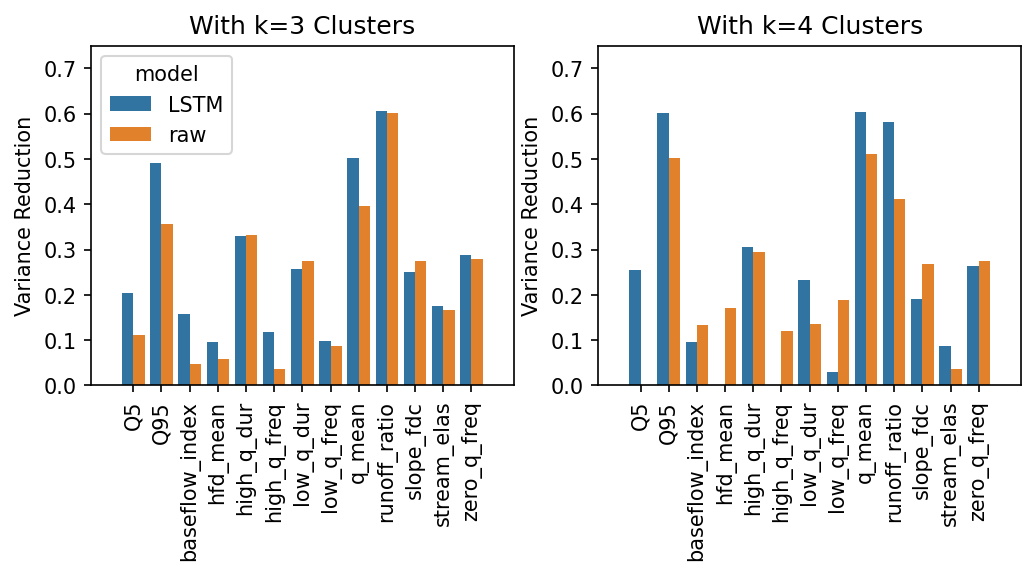

In [570]:
plot_df = var_reduction.melt()
plot_df = plot_df.join(pd.DataFrame(plot_df["variable"].str.split("_").to_list(), columns=["k", "model"]))
plot_df = plot_df.drop("variable",axis=1)
plot_df["variable"] = np.tile([v for v in var_reduction.index], 4)
plot_df["value"] = 1 - plot_df["value"]
# plot_df = df2

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
for ix, k in enumerate(ks):
    ax = axs[ix]
    sns.barplot(y="value", x="variable", hue="model", data=plot_df.loc[plot_df["k"] == str(k)], ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("Variance Reduction")
    ax.set_title(f"With k={k} Clusters")
    ax.set_ylim(0, 0.75) # ax.set_ylim(0, 1)
    ax.set_xlim(-1.5, 13.5)
    if ix != 0:
        ax.get_legend().remove()

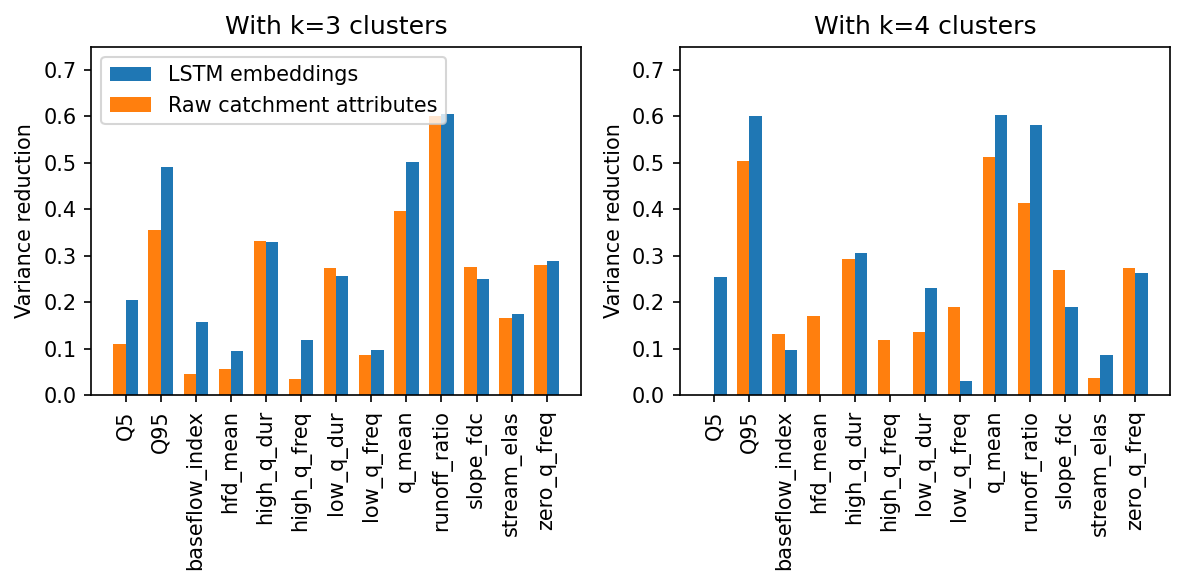

In [569]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for i, k in enumerate(ks):
    # CALCULATE
    lstm_vals = flow_vars_normalized.groupby(f"lstm_cluster_{k}").var().mean() / flow_vars_normalized.var()
    lstm_vals = lstm_vals.drop([c for c in lstm_vals.index if "cluster" in c])

    raw_vals = flow_vars_normalized.groupby(f"raw_cluster_{k}").var().mean() / flow_vars_normalized.var()
    raw_vals = raw_vals.drop([c for c in raw_vals.index if "cluster" in c])
    
    # PLOT
    ind = np.arange(len(raw_vals))  # the x locations for the groups
    width = 0.35                    # the width of the bars
    rects2 = ax[i].bar(ind + width/2, 1 - lstm_vals.values, width, 
                    label='LSTM embeddings')
    rects1 = ax[i].bar(ind - width/2, 1 - raw_vals.values, width,
                    label='Raw catchment attributes')
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[i].set_ylabel('Variance reduction')
    ax[i].set_xticks(ind)
    ax[i].set_xticklabels(raw_vals.index)
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_title(f"With k={k} clusters")
    if i == 0:
        ax[i].legend(loc="upper left")
    ax[i].set_ylim(0, 0.75)
plt.tight_layout()

# check the impact of different static features

In [ ]:
# static

In [ ]:
all_clusters = []
for k in ks:
    all_clusters.append(pd.DataFrame(clusters[k]["lstm"], index=[f"lstm_cluster_{k}"]).T)
    all_clusters.append(pd.DataFrame(clusters[k]["raw"], index=[f"raw_cluster_{k}"]).T)

cluster_df = pd.concat(all_clusters, axis=1)
cluster_df.head()

In [ ]:
static_vars = static.to_dataframe().loc[cluster_df.index]

In [396]:
static_vars.loc[:, static_vars.dtypes == "float64"]
static_vars.loc[:, static_vars.dtypes == "int64"]
static_vars.loc[:, static_vars.dtypes == "object"]

10002     Grass and Pasture
10003                 Crops
1001                 Shrubs
101002                Crops
101005    Grass and Pasture
                ...        
95001                Shrubs
96001                Shrubs
96002                Shrubs
96004                Shrubs
97002                Shrubs
Name: dom_land_cover, Length: 669, dtype: object

x0_Crops  x0_Deciduous Woodland  x0_Evergreen Woodland  \
0         0.0                    0.0                    0.0   
1         1.0                    0.0                    0.0   
2         0.0                    0.0                    0.0   
3         1.0                    0.0                    0.0   
4         0.0                    0.0                    0.0   
..        ...                    ...                    ...   
664       0.0                    0.0                    0.0   
665       0.0                    0.0                    0.0   
666       0.0                    0.0                    0.0   
667       0.0                    0.0                    0.0   
668       0.0                    0.0                    0.0   

     x0_Grass and Pasture  x0_Shrubs  x0_Urban  
0                     1.0        0.0       0.0  
1                     0.0        0.0       0.0  
2                     0.0        1.0       0.0  
3                     0.0        0.0       0.0  
4                     1.0        0.0       0.0  
..                    ...        ...       ...  
664                   0.0        1.0       0.0  
665                   0.0        1.0       0.0  
666                   0.0        1.0       0.0  
667                   0.0        1.0       0.0  
668                   0.0        1.0       0.0  

[669 rows x 6 columns]

In [433]:
basin_order = [k for k in embeddings.keys()]
static_vars = static.to_dataframe().loc[basin_order]

from sklearn.preprocessing import OneHotEncoder

p = OneHotEncoder(sparse=False)
ohe_df = pd.DataFrame(p.fit_transform(static_vars["dom_land_cover"].values.reshape(-1, 1)))
ohe_df.columns = p.get_feature_names()
ohe_df.index = basin_order
landcover_ohe = ohe_df.astype(bool)
landcover_ohe.head()

x0_Crops  x0_Deciduous Woodland  x0_Evergreen Woodland  \
10002      False                  False                  False   
10003       True                  False                  False   
1001       False                  False                  False   
101002      True                  False                  False   
101005     False                  False                  False   

        x0_Grass and Pasture  x0_Shrubs  x0_Urban  
10002                   True      False     False  
10003                  False      False     False  
1001                   False       True     False  
101002                 False      False     False  
101005                  True      False     False

In [434]:
col = "x0_Crops"
landcover_ohe[col]

10002     False
10003      True
1001      False
101002     True
101005    False
          ...  
95001     False
96001     False
96002     False
96004     False
97002     False
Name: x0_Crops, Length: 669, dtype: bool

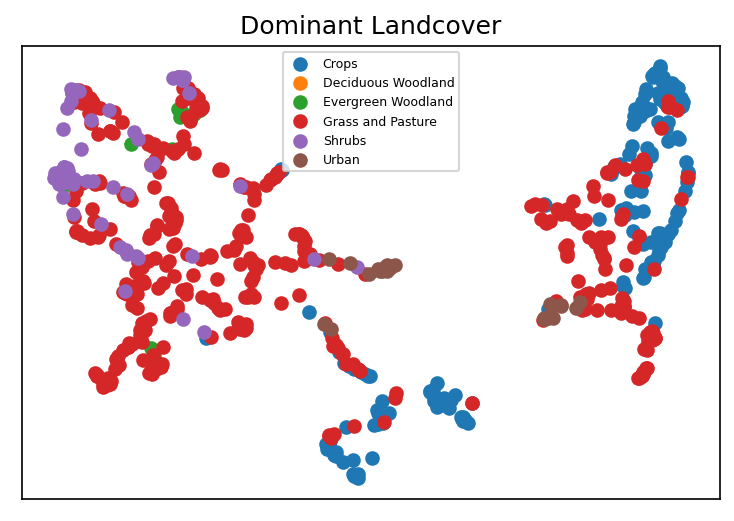

In [441]:
f, ax = plt.subplots()

for ix, col in enumerate(landcover_ohe.columns):
    c = sns.color_palette()[ix]
    colname = col.replace("x0_", "")
    points = ax.scatter(umap_embedding[landcover_ohe[col], 0], umap_embedding[landcover_ohe[col], 1], color=c, norm=norm, label=colname);

ax.legend(prop={'size': 6})
ax.set_xticklabels([""])
ax.set_yticklabels([""])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Dominant Landcover");

### UMAP Visualisation


In [267]:
from sklearn.preprocessing import normalize
# print(sorted([d for d in all_static.data_vars]))
all_static_df = all_static.to_dataframe()

pd.DataFrame(normalize(all_static_df[[c for c in all_static_df.columns if all_static_df[c].dtype == "float64"]].dropna(axis=1)))

array([[0.        , 0.01674687, 0.        , ..., 0.00551662, 0.00049256,
        0.0725862 ],
       [0.        , 0.00904636, 0.        , ..., 0.00292676, 0.        ,
        0.08307788],
       [0.        , 0.00832636, 0.        , ..., 0.00139717, 0.        ,
        0.04703164],
       ...,
       [0.        , 0.02593718, 0.        , ..., 0.00034737, 0.00034737,
        0.1386481 ],
       [0.        , 0.        , 0.        , ..., 0.00922548, 0.        ,
        0.06293257],
       [0.        , 0.01941378, 0.        , ..., 0.00075509, 0.        ,
        0.0712766 ]])

In [253]:
import umap
import matplotlib.colors as colors

In [375]:
good_seeds = 4  # 8 12 18 4    # 145 10_000
seed = 4

# Calculate UMAP embedding from the LSTM catchment embeddings
transformer = umap.UMAP(n_neighbors=10, 
                        min_dist=0.1, 
                        n_components=2,
                        random_state=seed).fit(all_embeddings)
umap_embedding = transformer.transform(all_embeddings)

<ipython-input-427-2b23c70a62b6>:49: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[m,n].set_xticks([], [])
<ipython-input-427-2b23c70a62b6>:50: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[m,n].set_yticks([], [])


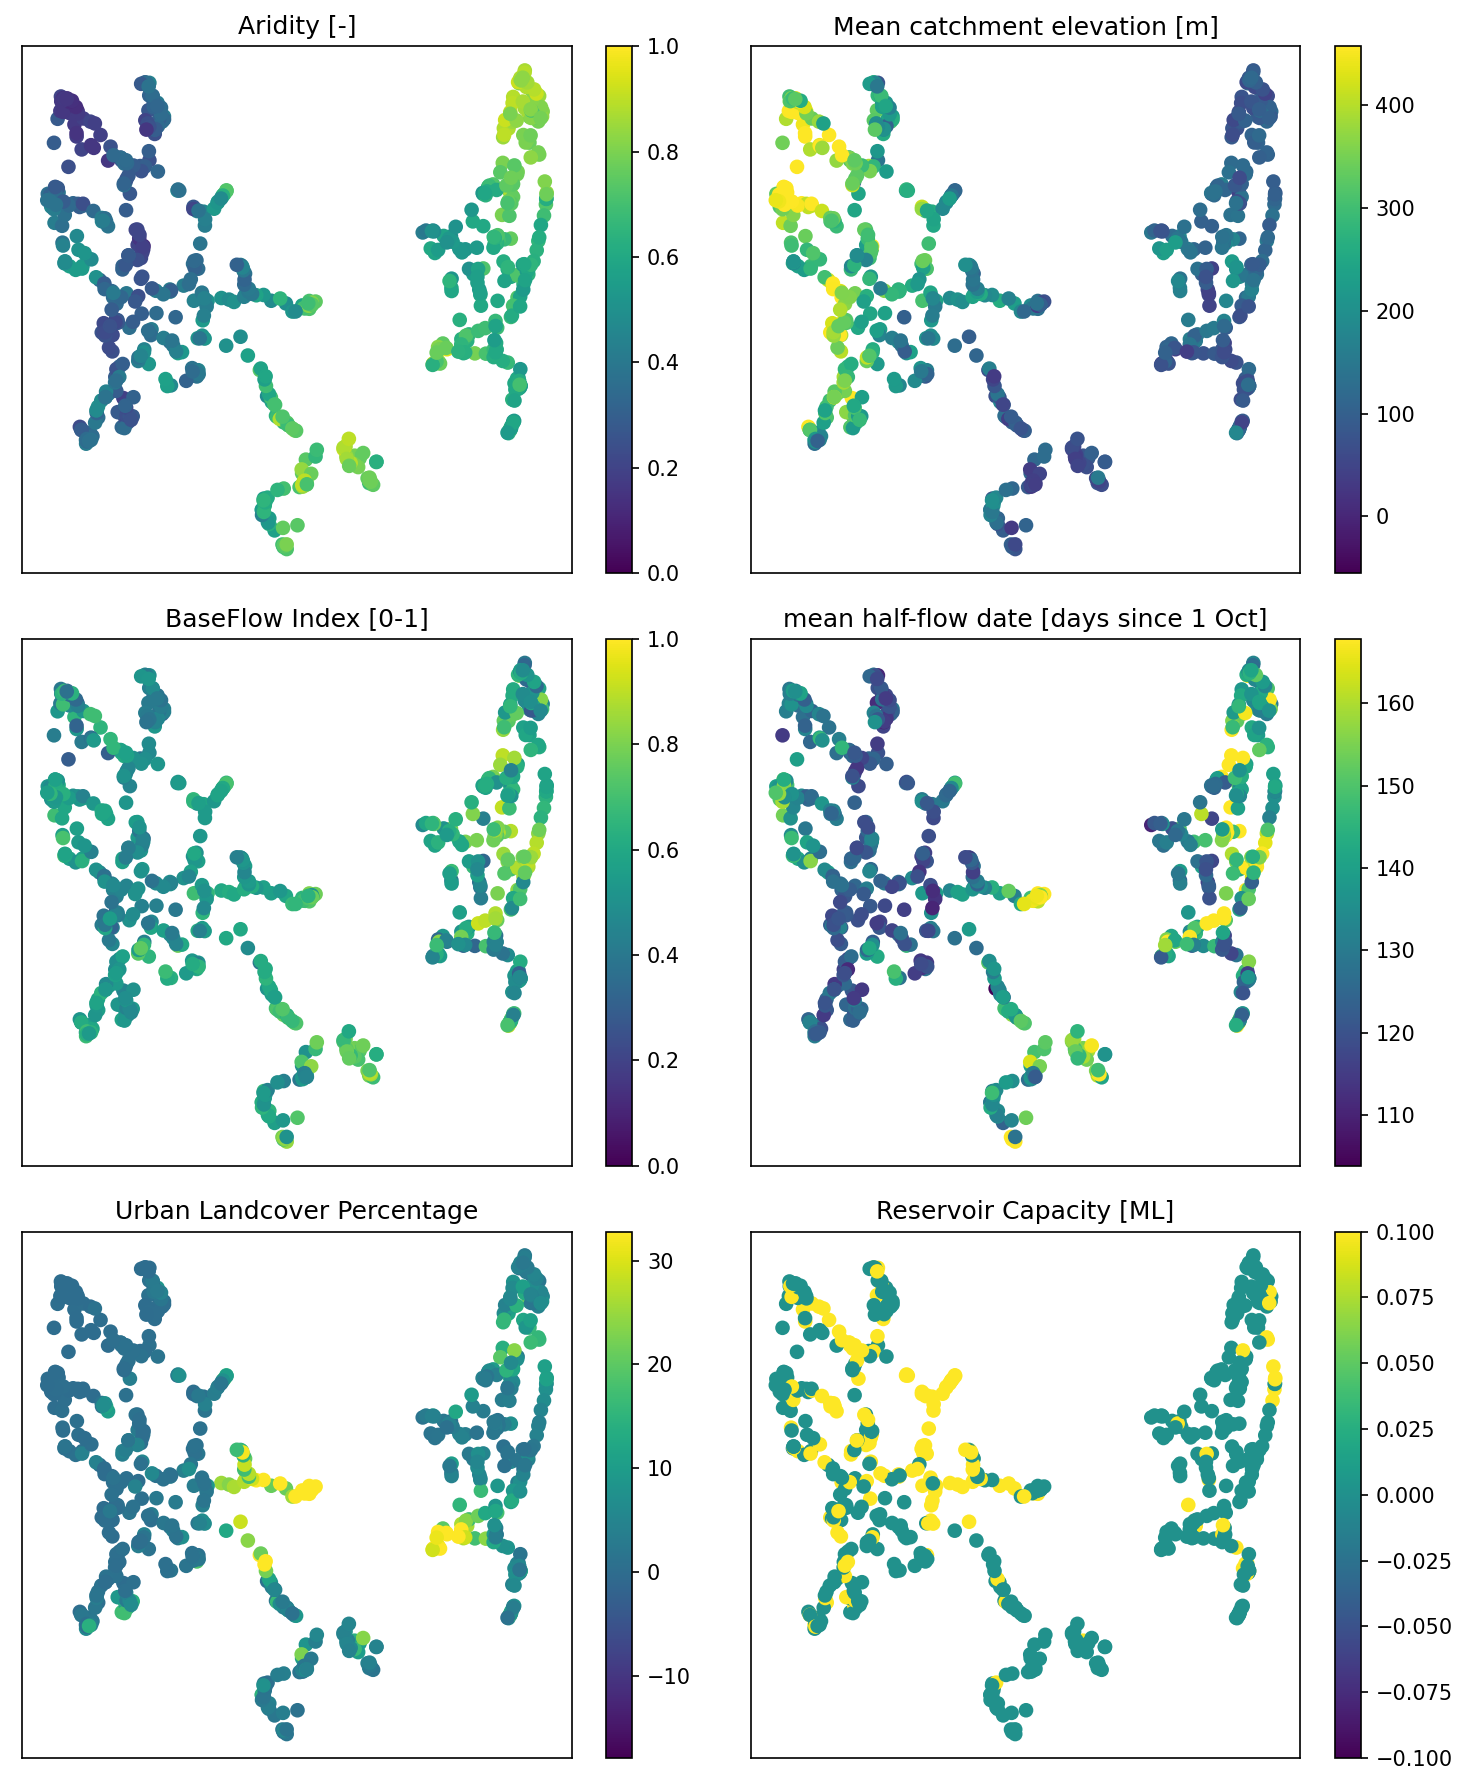

In [427]:
import matplotlib.colors as colors

# Plot the results
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10,12))

cmap = "viridis"  # "plasma"
attribute_set = {'aridity': 'Aridity [-]', 
                 'elev_mean': 'Mean catchment elevation [m]', 
#                  'p_mean': 'Mean daily precipitation [mm/day]', 
                 "baseflow_index": "BaseFlow Index [0-1]",
#                  'area': 'Catchment area [km2]', 
                 'hfd_mean': 'mean half-flow date [days since 1 Oct]', 
#                  'dpsbar': 'Mean Drainage Path Slope [m/km2]',
                 "urban_perc": "Urban Landcover Percentage",
#                  "no_gw_perc": "Hydrogeology - rocks with no groundwater (%)",
                 "reservoir_cap": "Reservoir Capacity [ML]",
                }

kwargs_lookup = {
    "aridity": {"vmin": 0, "vmax": 1},
    "baseflow_index": {"vmin": 0, "vmax": 1},
    "reservoir_cap": {"vmin": np.percentile(all_static_df["reservoir_cap"], q=50), "vmax": np.percentile(all_static_df[attribute], q=50)},
}

basin_order = [k for k in embeddings.keys()]
static_vars = static.to_dataframe().loc[basin_order]

for i, (attribute, title) in enumerate(attribute_set.items()):
    m = i // 2
    n = i % 2
    try:
        norm = colors.Normalize(vmin=kwargs_lookup[attribute]["vmin"], 
                                vmax=kwargs_lookup[attribute]["vmax"],
        )
    except KeyError:
        norm = colors.Normalize(
            vmin=static_vars[attribute].mean() - 2*(static_vars[attribute].std()),
            vmax=static_vars[attribute].mean() + 2*(static_vars[attribute].std()),
        )


    c = []
    for basin in VALID_BASINS:
        c.append(static_vars.loc[static_vars.index == basin, attribute].values[0])
    
    points = ax[m,n].scatter(umap_embedding[:,0], umap_embedding[:,1], c=c, norm=norm, label="Basins", cmap=cmap)
    
    ax[m,n].set_title(title)
    ax[m,n].set_xticks([], [])
    ax[m,n].set_yticks([], [])
    plt.colorbar(points, ax=ax[m,n])
plt.tight_layout()

# [SKLEARN Silhouette Analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].
- Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.
- Also from the thickness of the silhouette plot the cluster size can be visualized

In [275]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm


def run_multiple_cluster_comparisons(X):
    """
    https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
    """
    range_n_clusters = np.arange(2, 15)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()


For n_clusters = 2 The average silhouette_score is : 0.3551519
For n_clusters = 3 The average silhouette_score is : 0.24654081
For n_clusters = 4 The average silhouette_score is : 0.19067846
For n_clusters = 5 The average silhouette_score is : 0.19112453
For n_clusters = 6 The average silhouette_score is : 0.17625195
For n_clusters = 7 The average silhouette_score is : 0.18572101
For n_clusters = 8 The average silhouette_score is : 0.17979725
For n_clusters = 9 The average silhouette_score is : 0.18144947
For n_clusters = 10 The average silhouette_score is : 0.18855892
For n_clusters = 11 The average silhouette_score is : 0.18659714
For n_clusters = 12 The average silhouette_score is : 0.18710843
For n_clusters = 13 The average silhouette_score is : 0.19087775
For n_clusters = 14 The average silhouette_score is : 0.196642


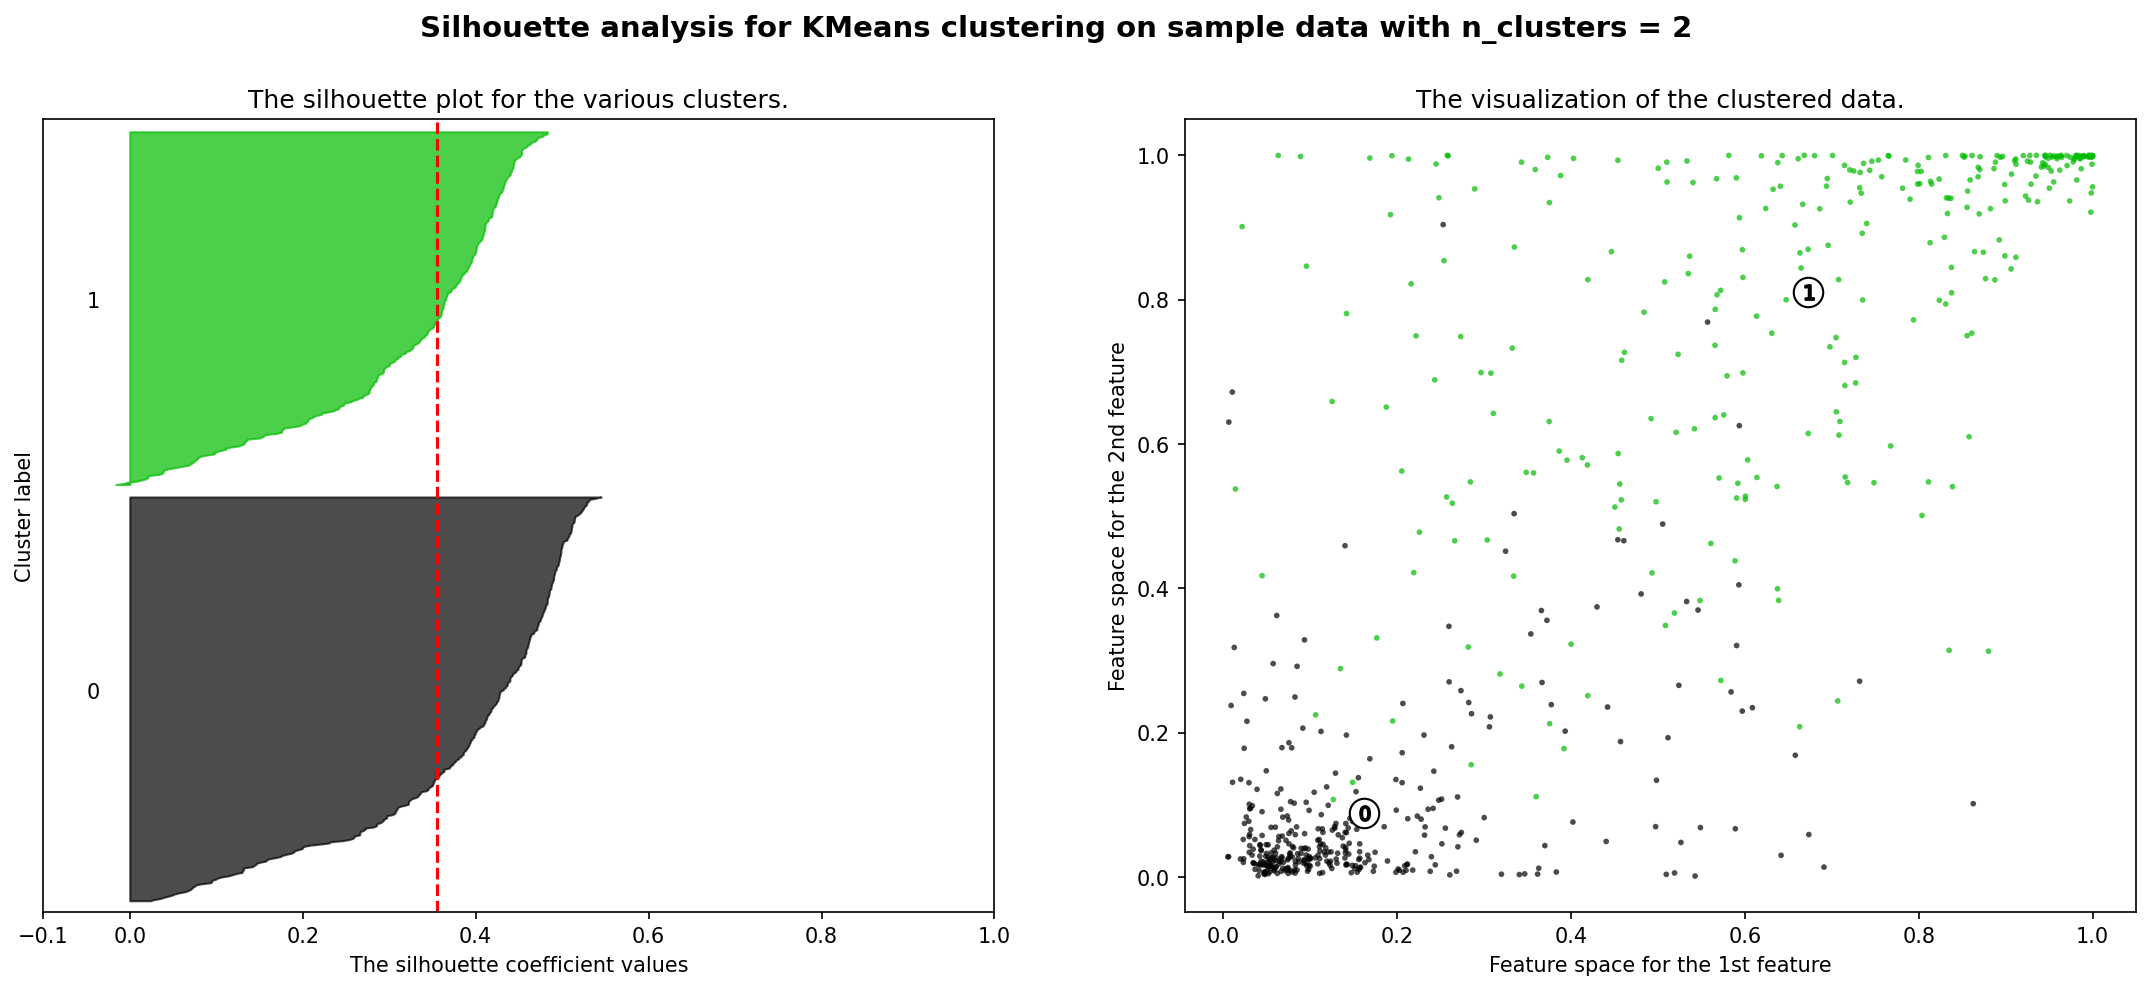

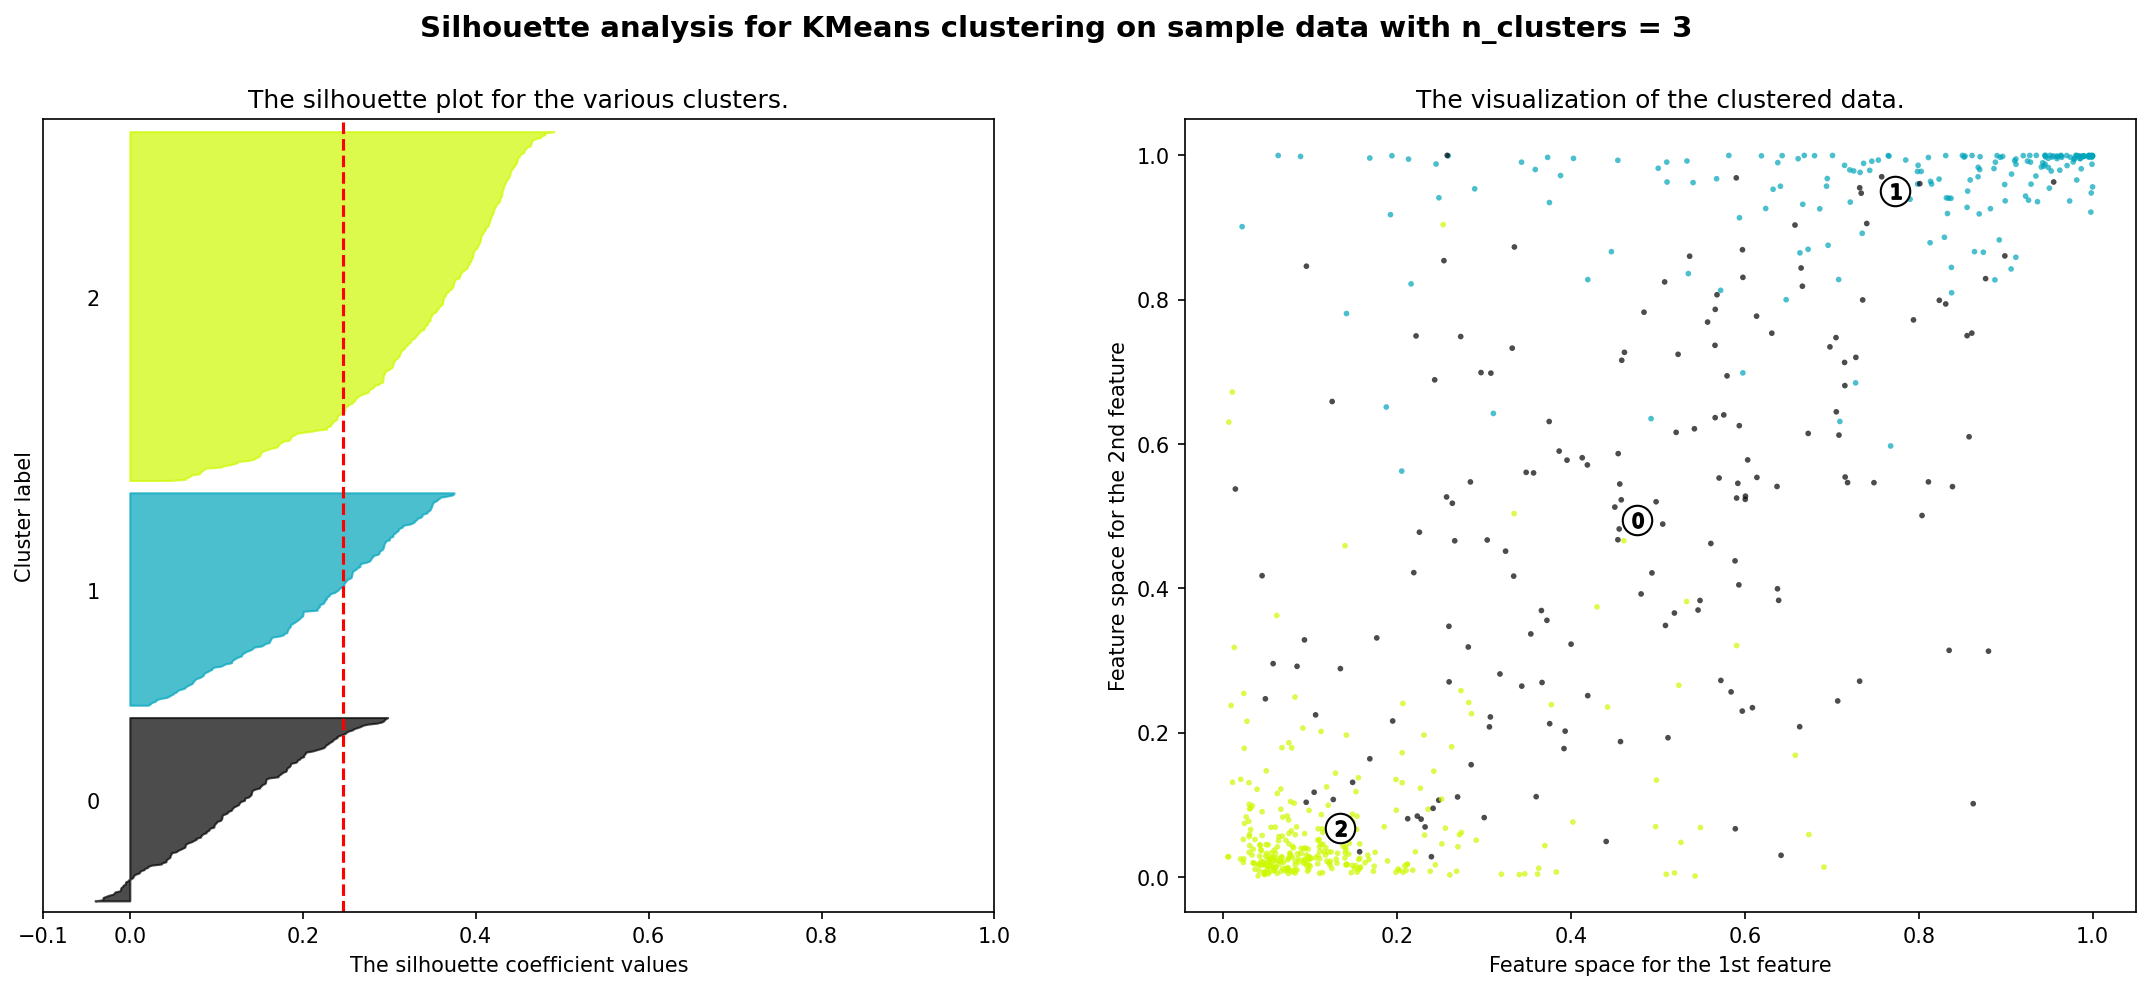

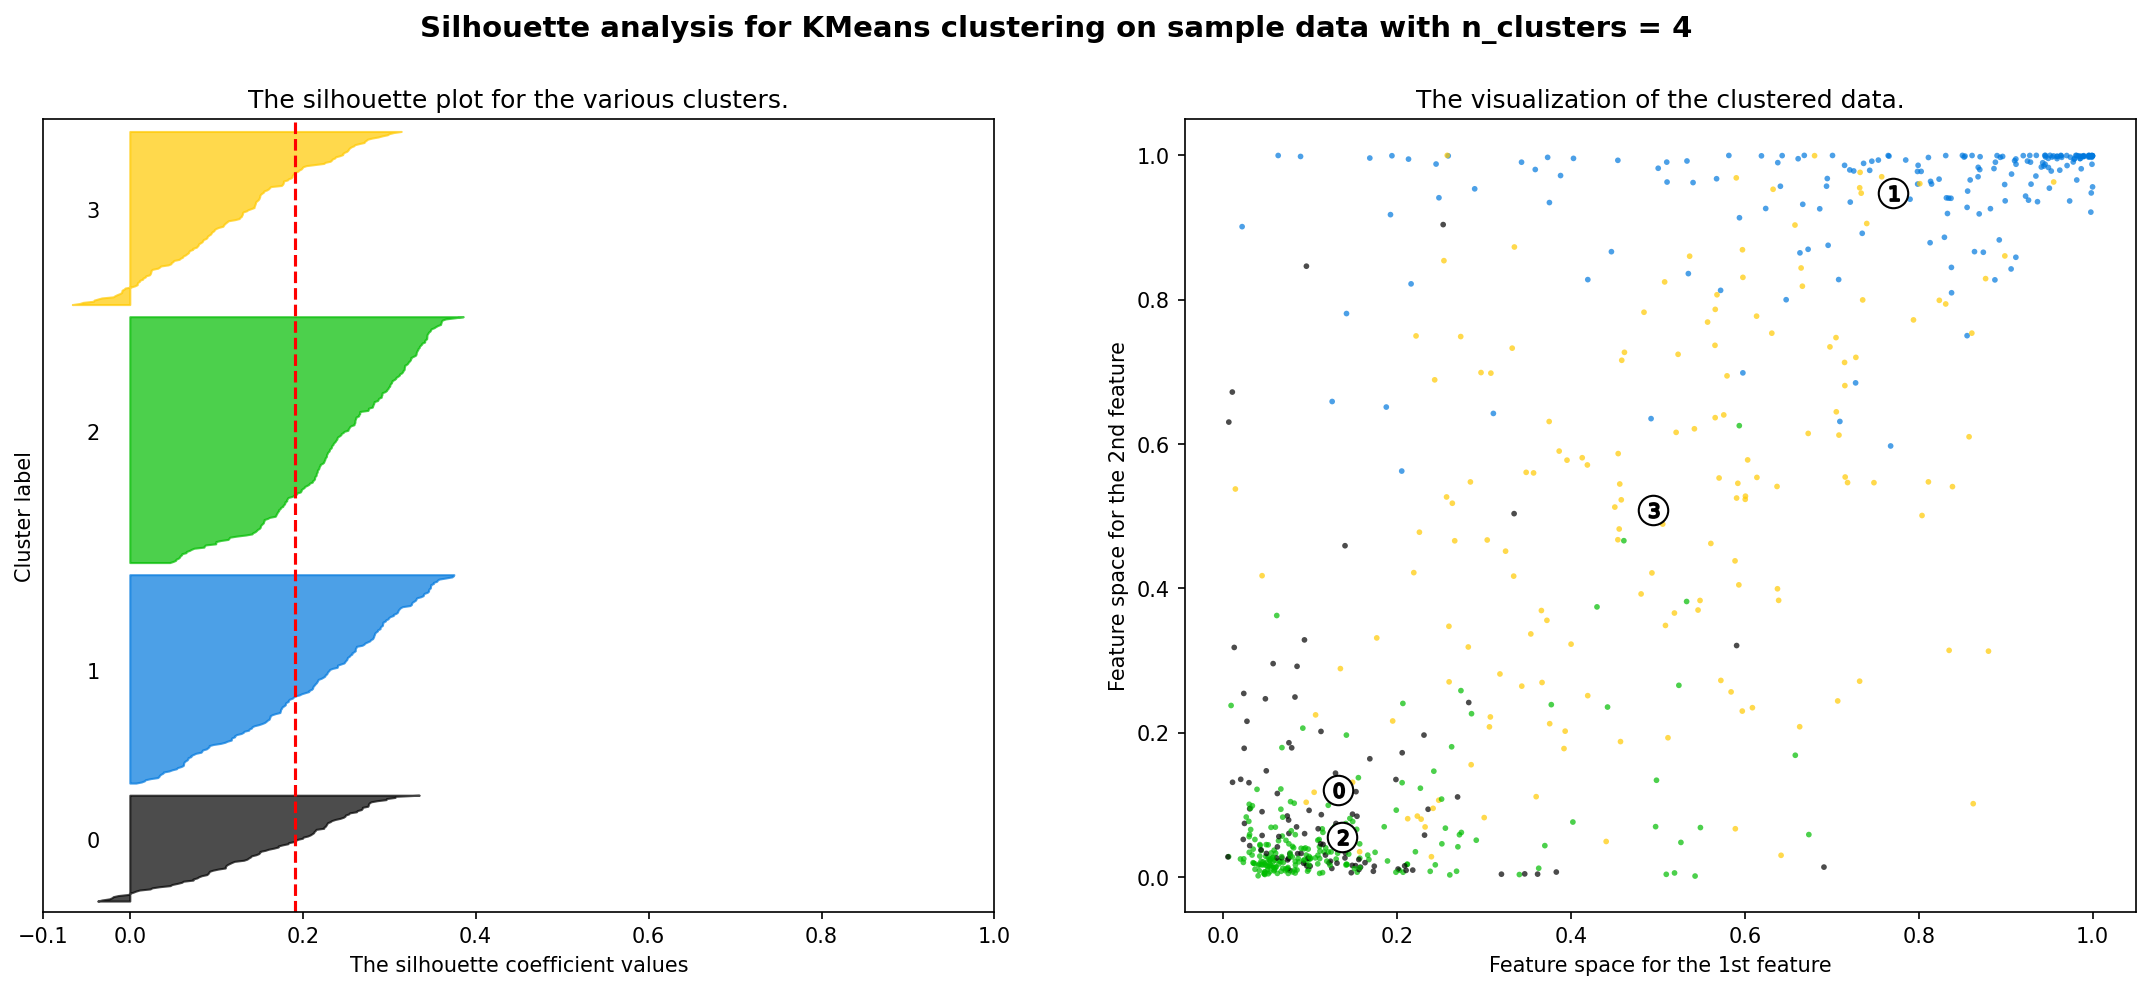

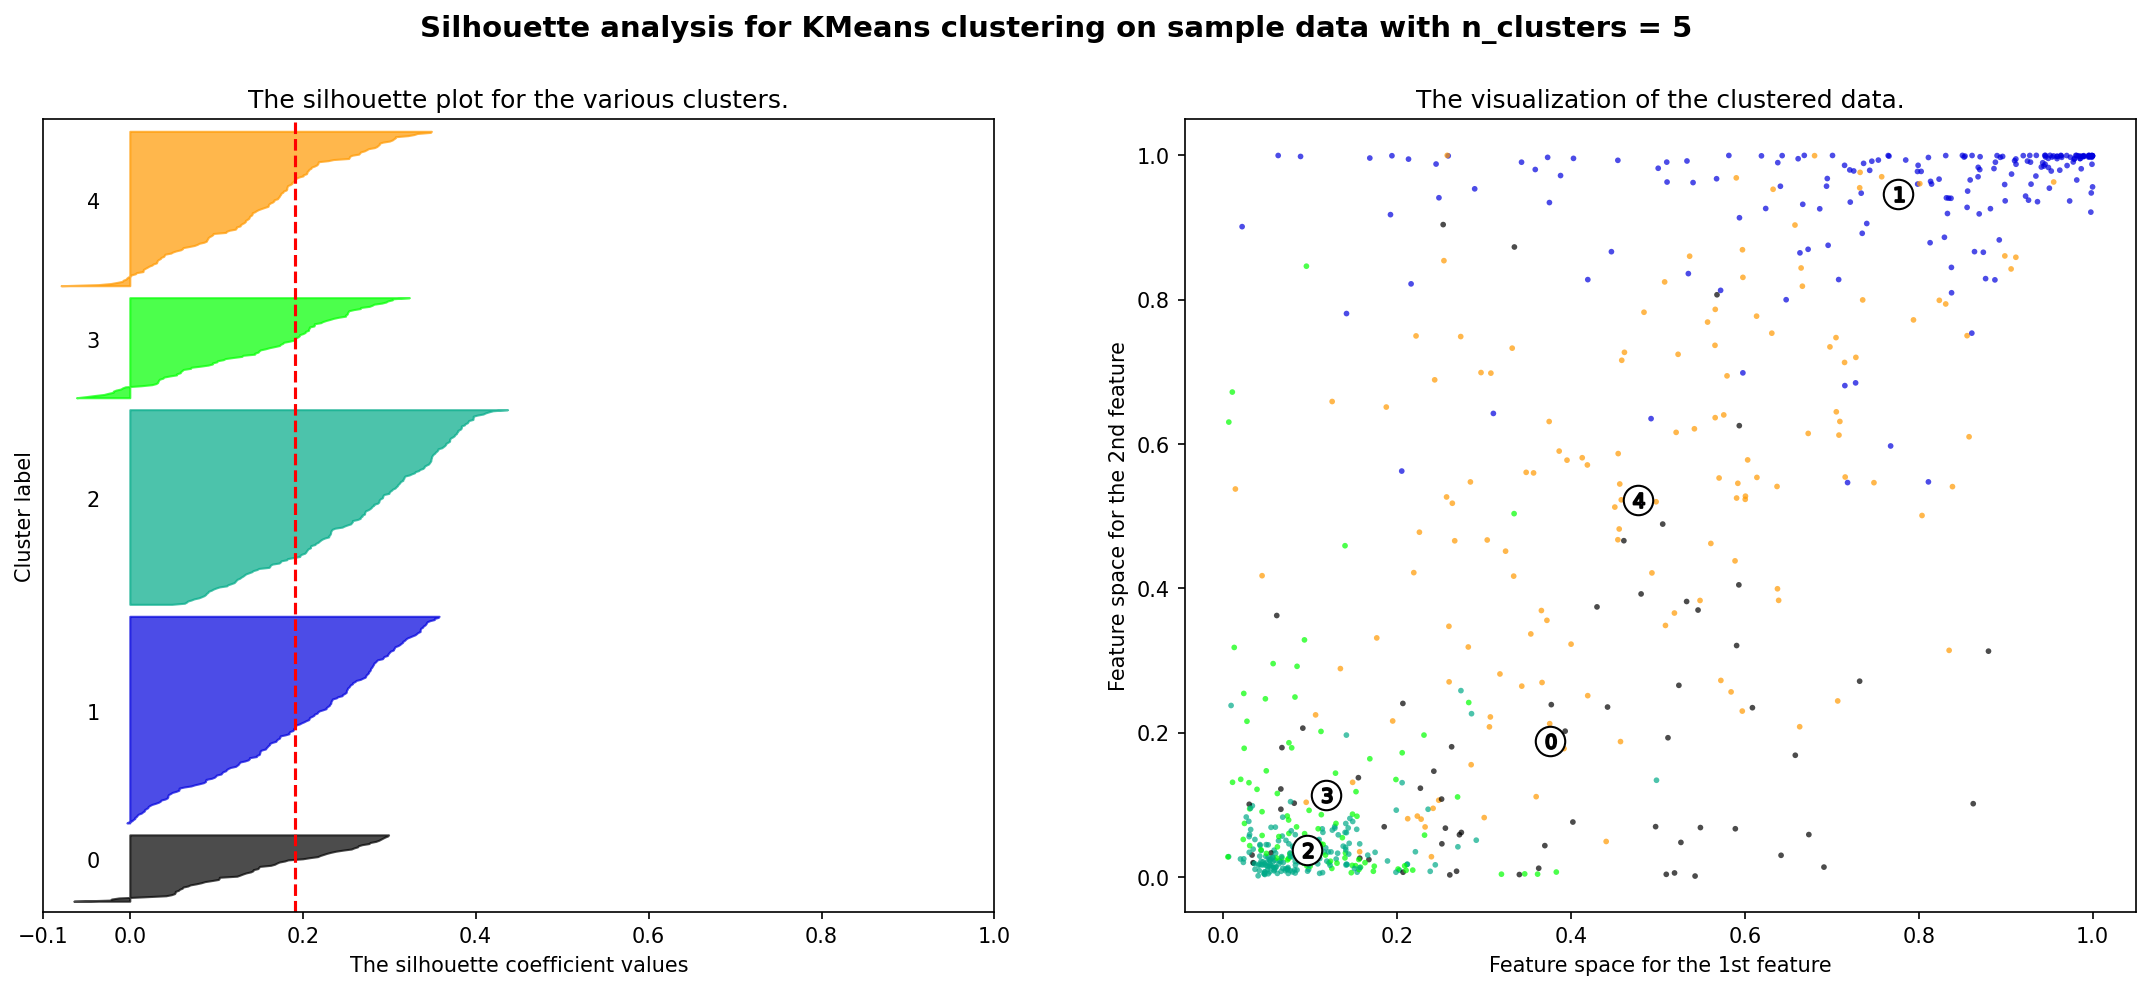

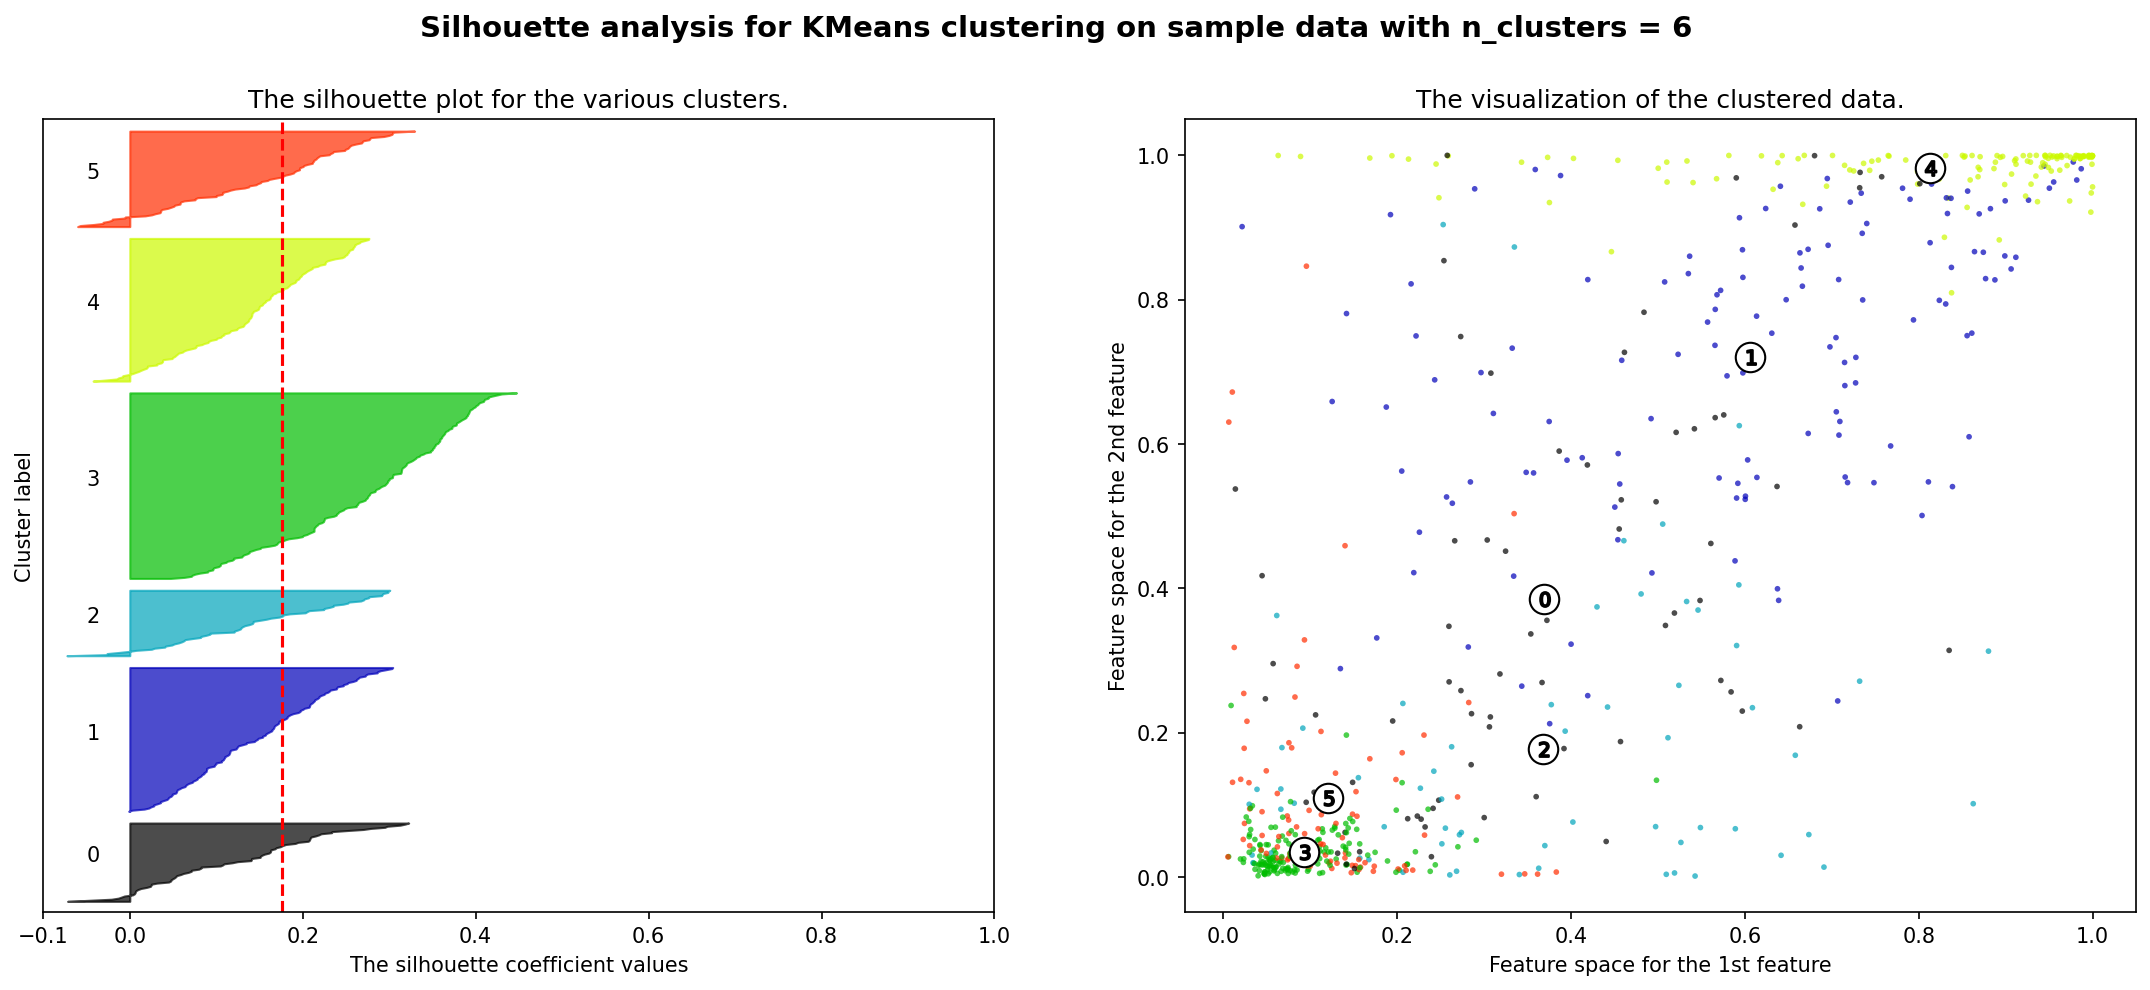

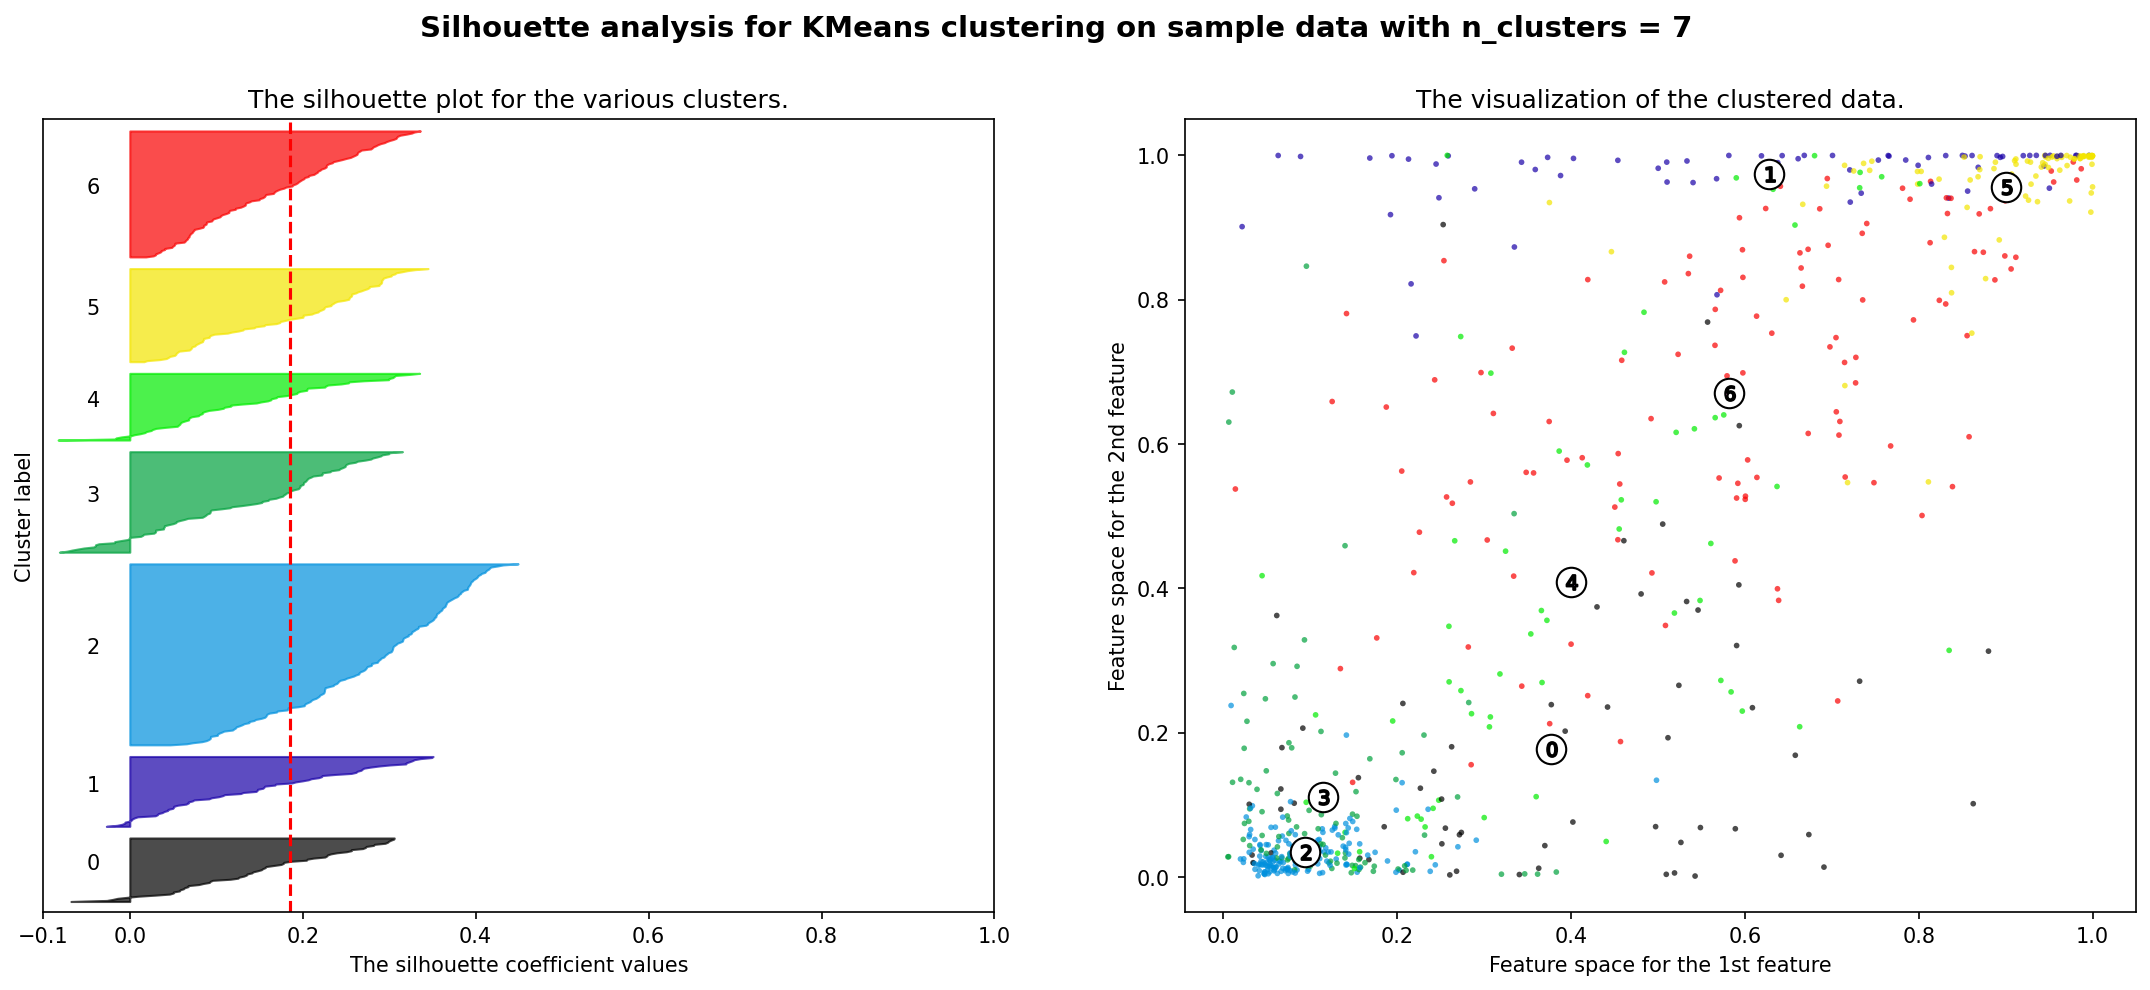

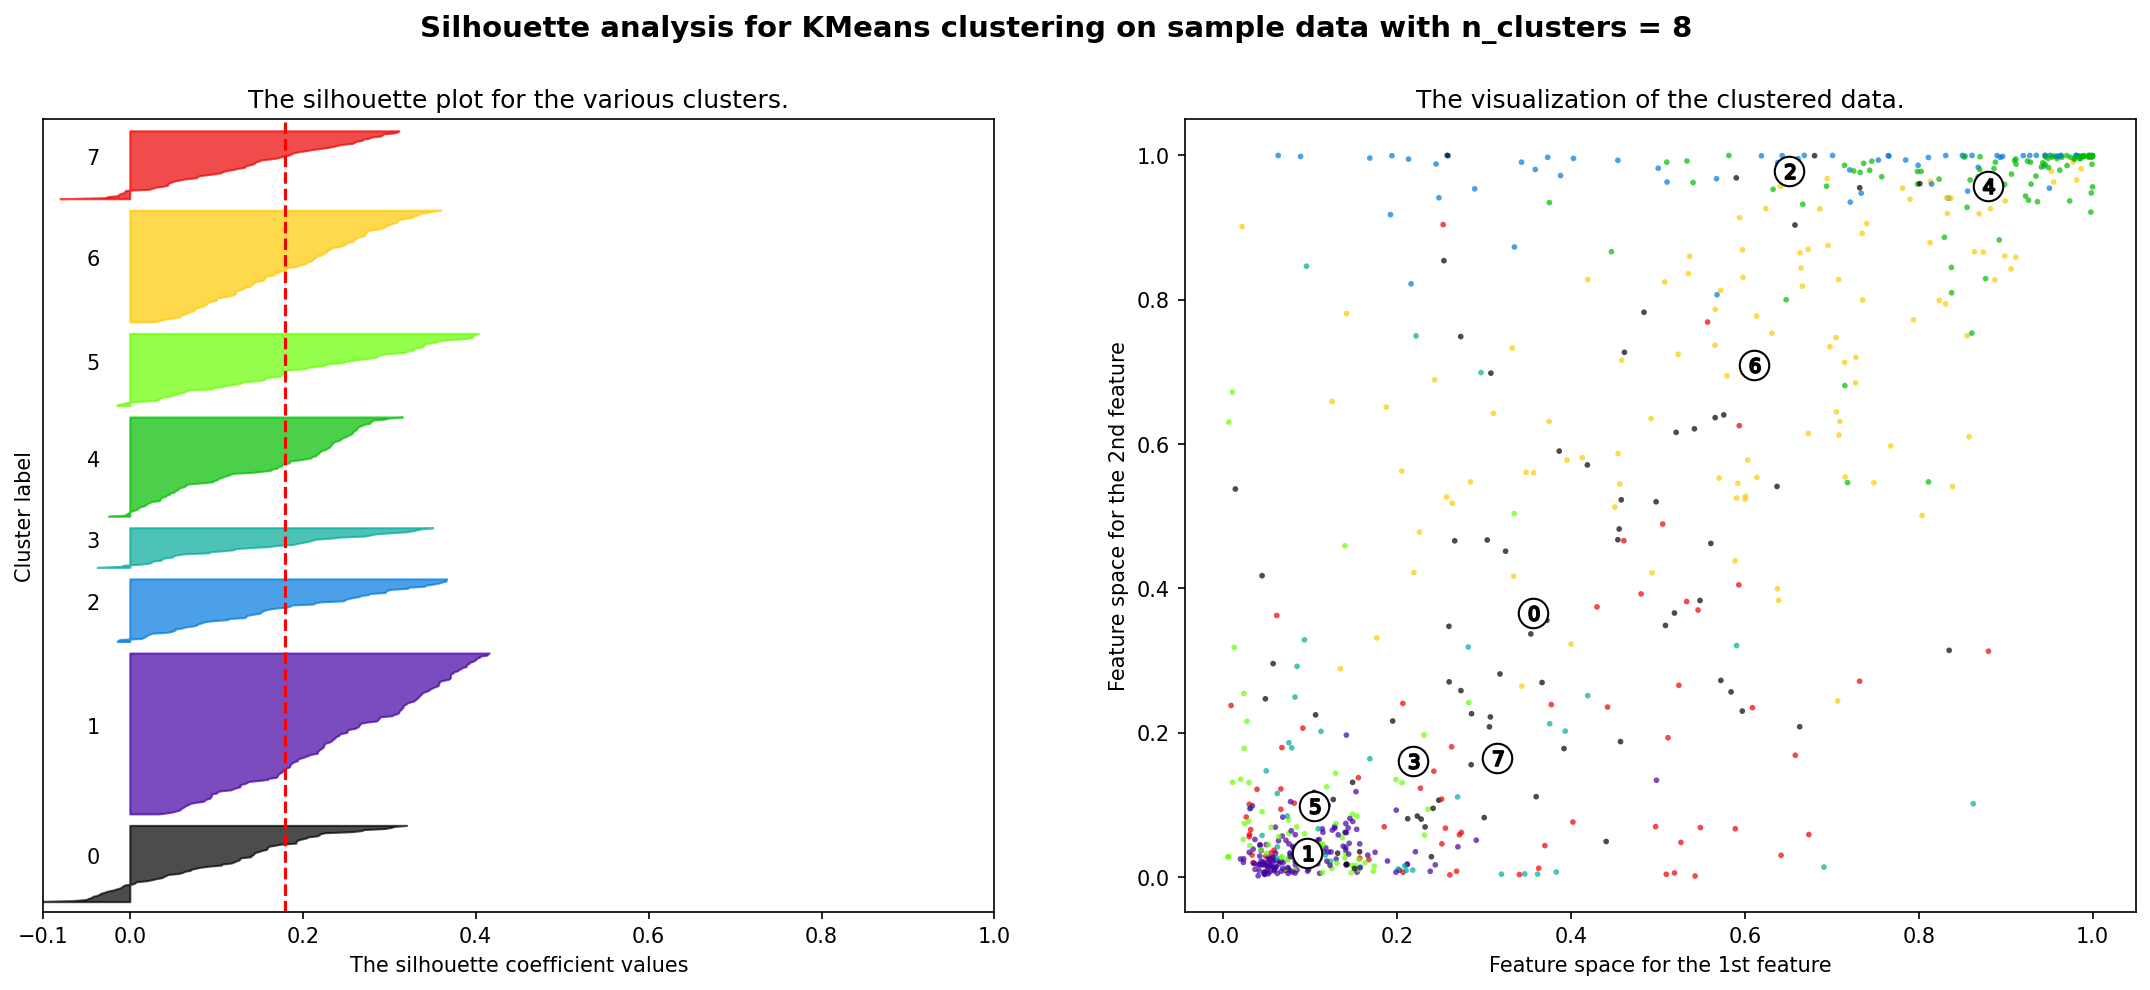

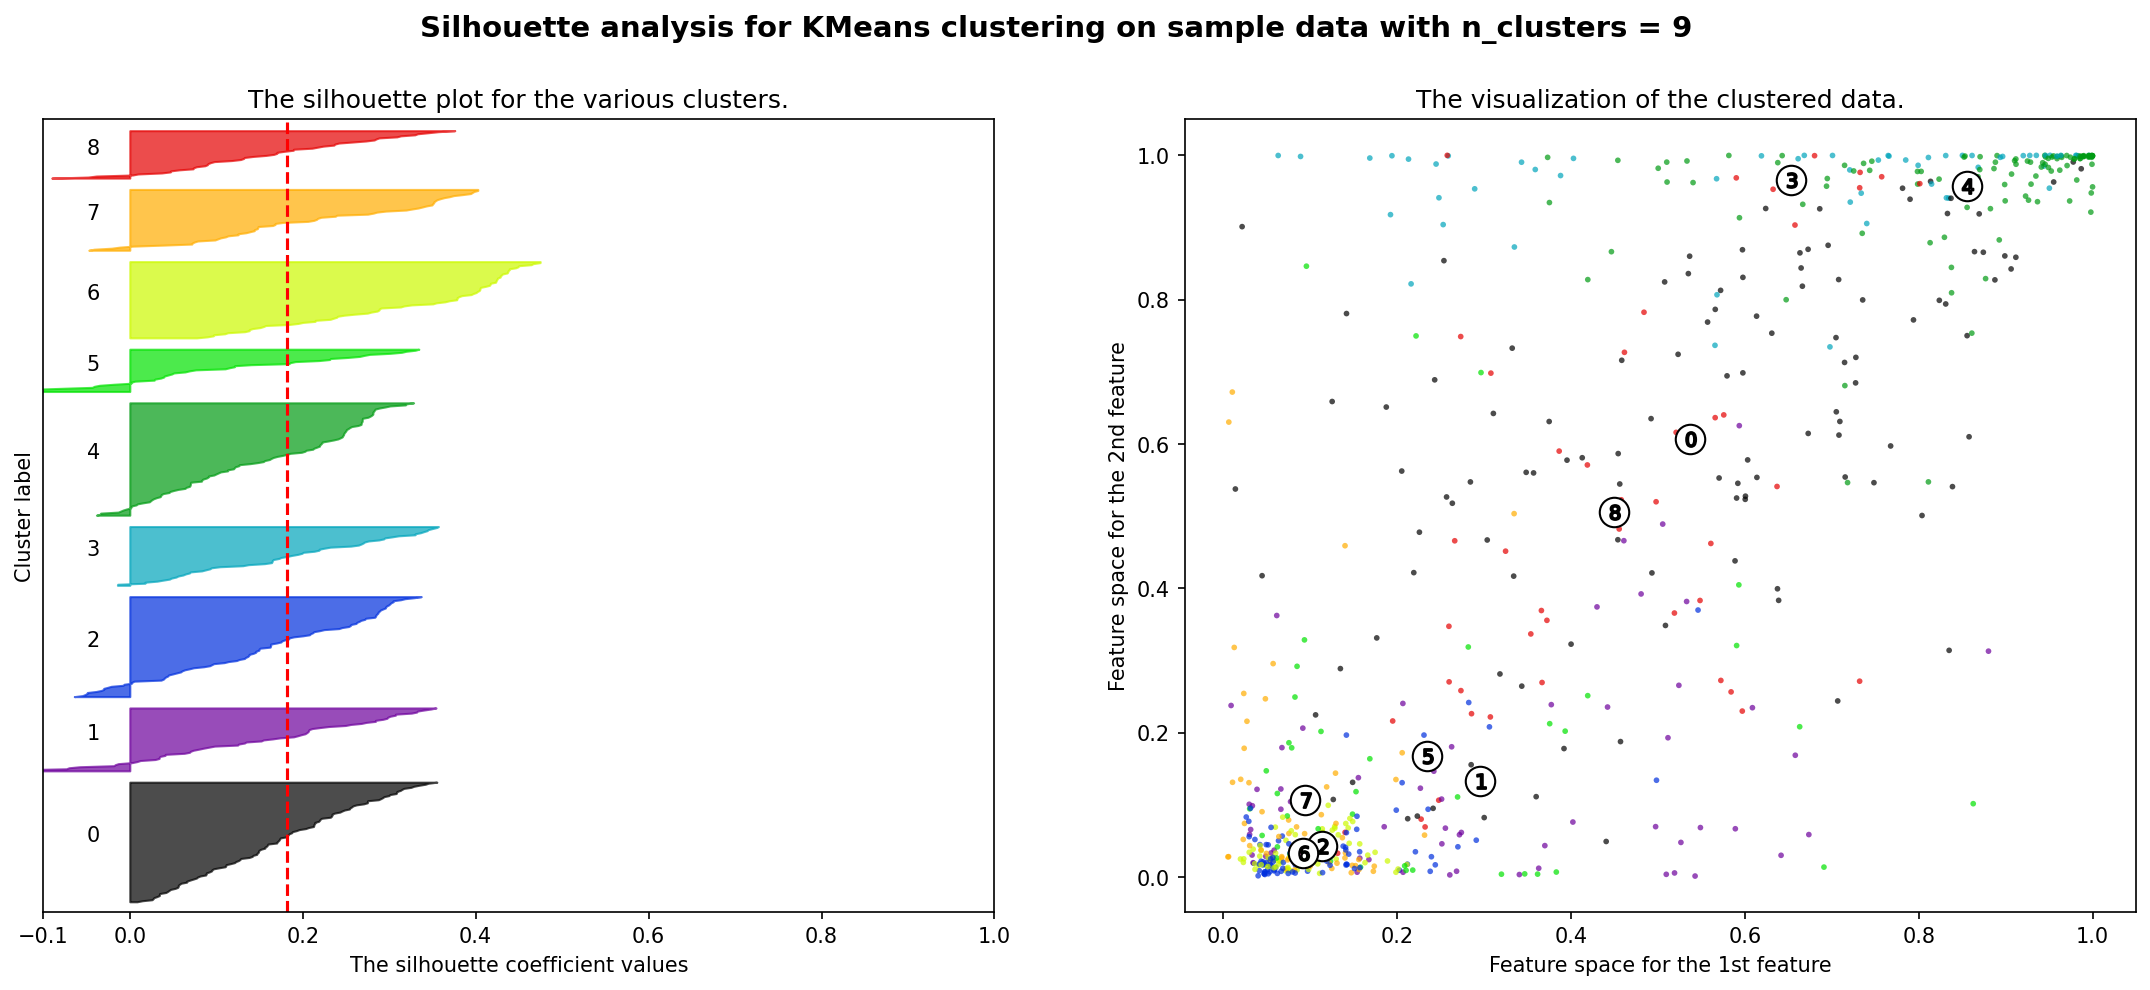

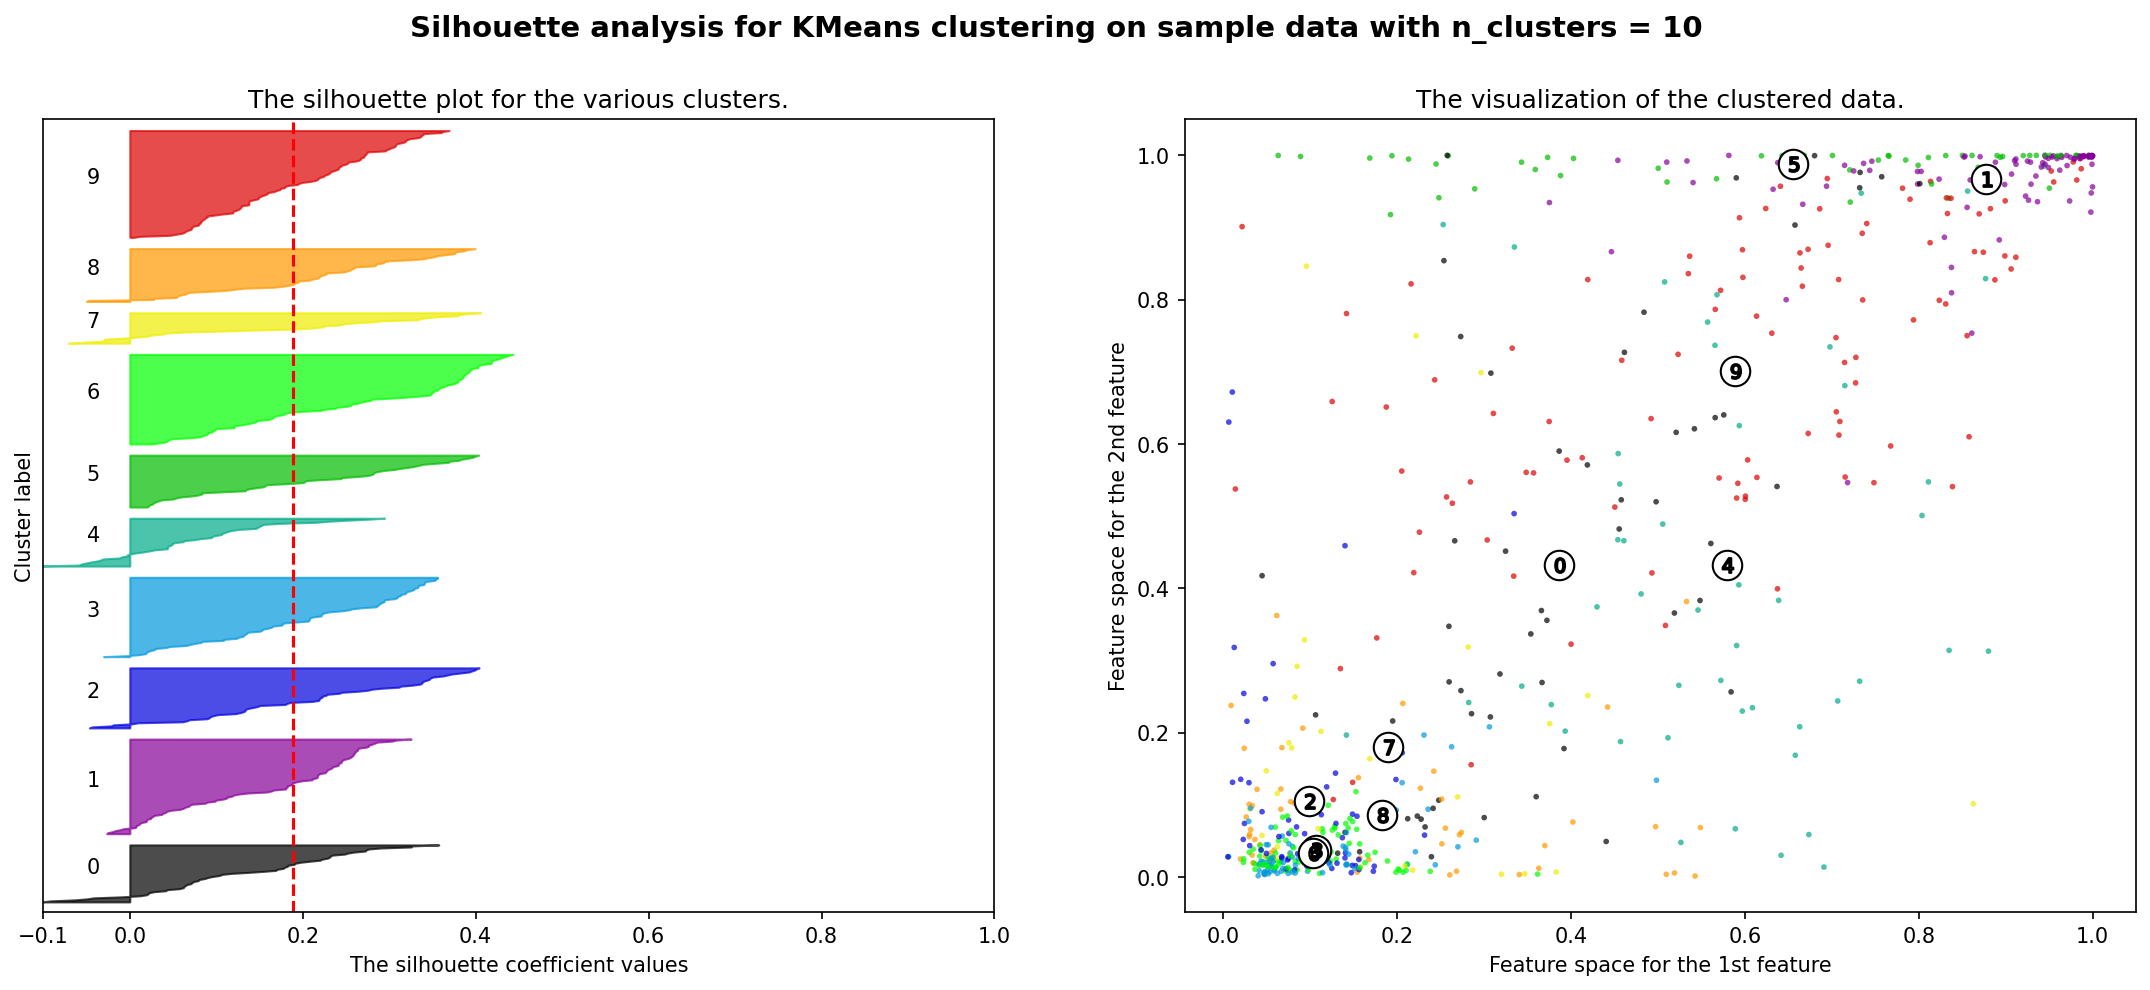

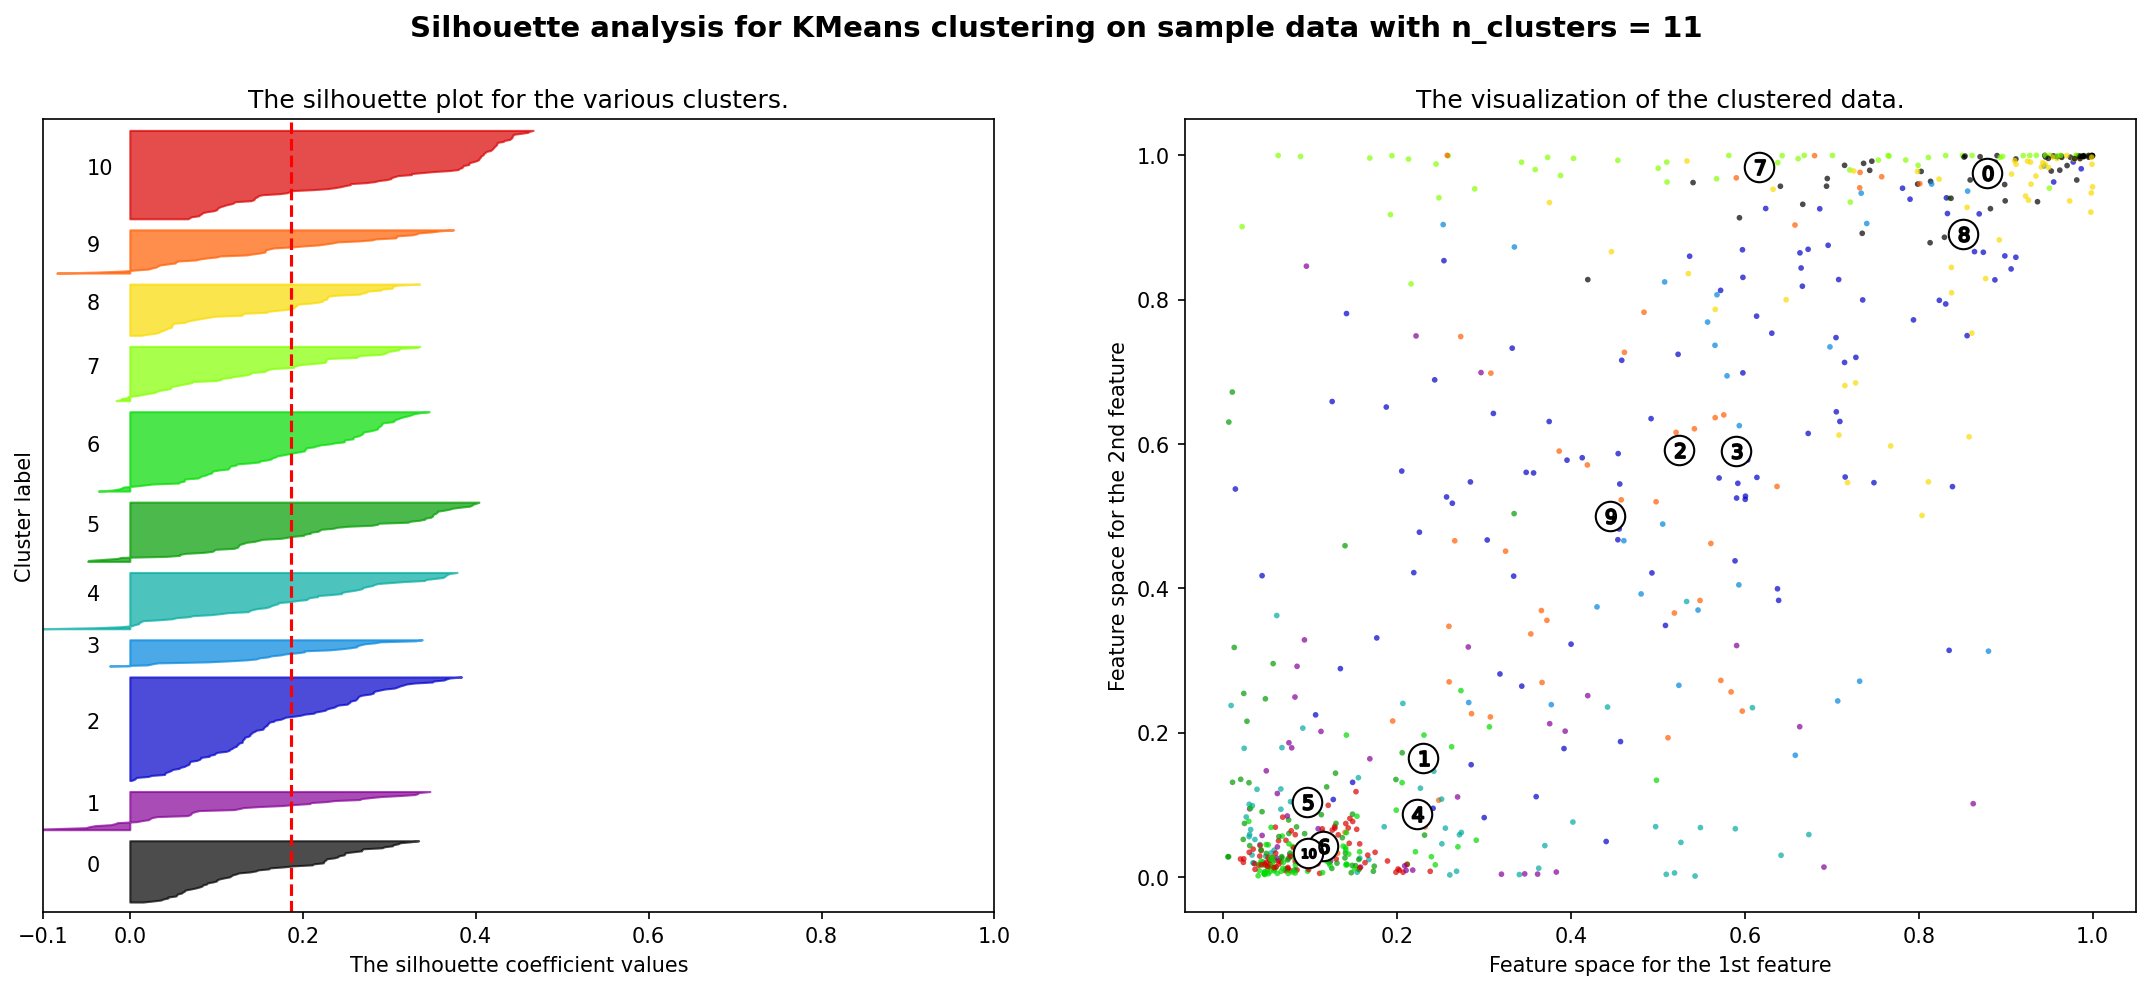

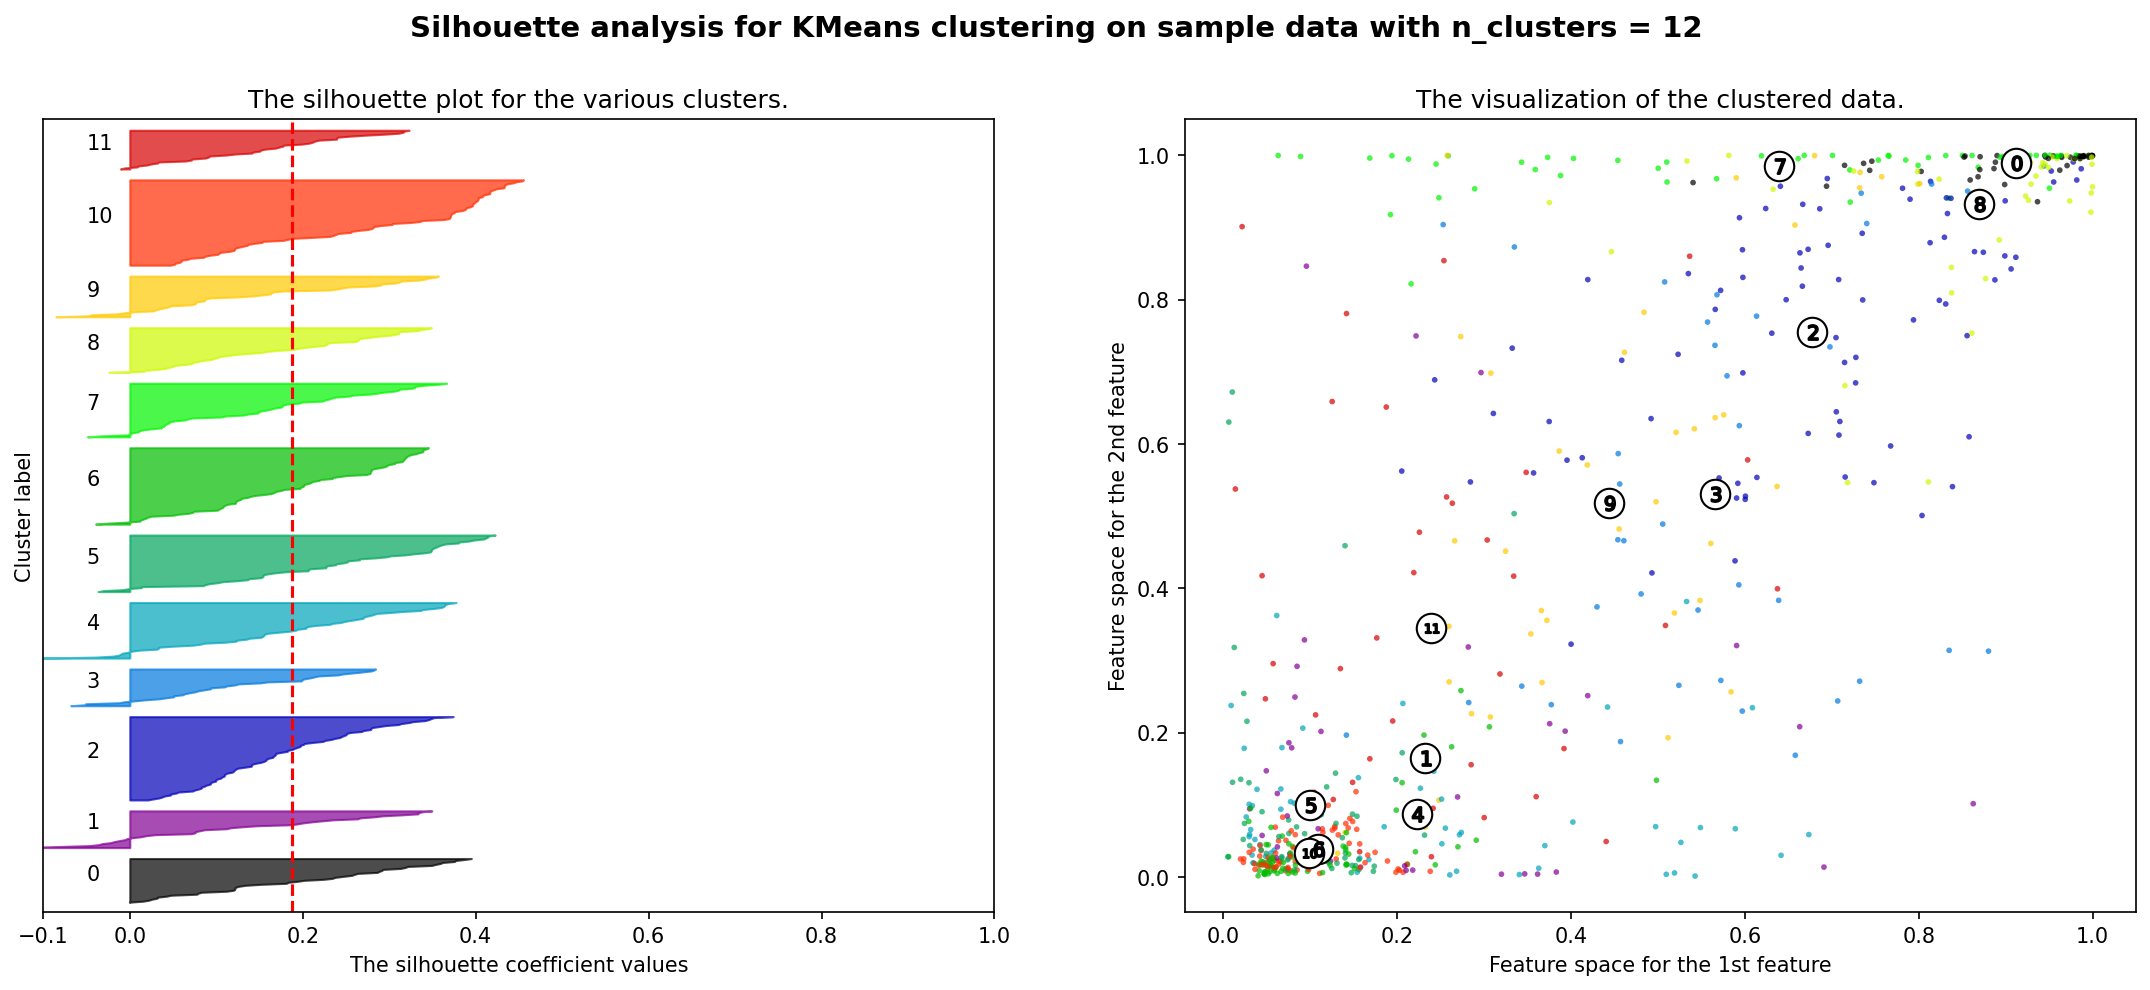

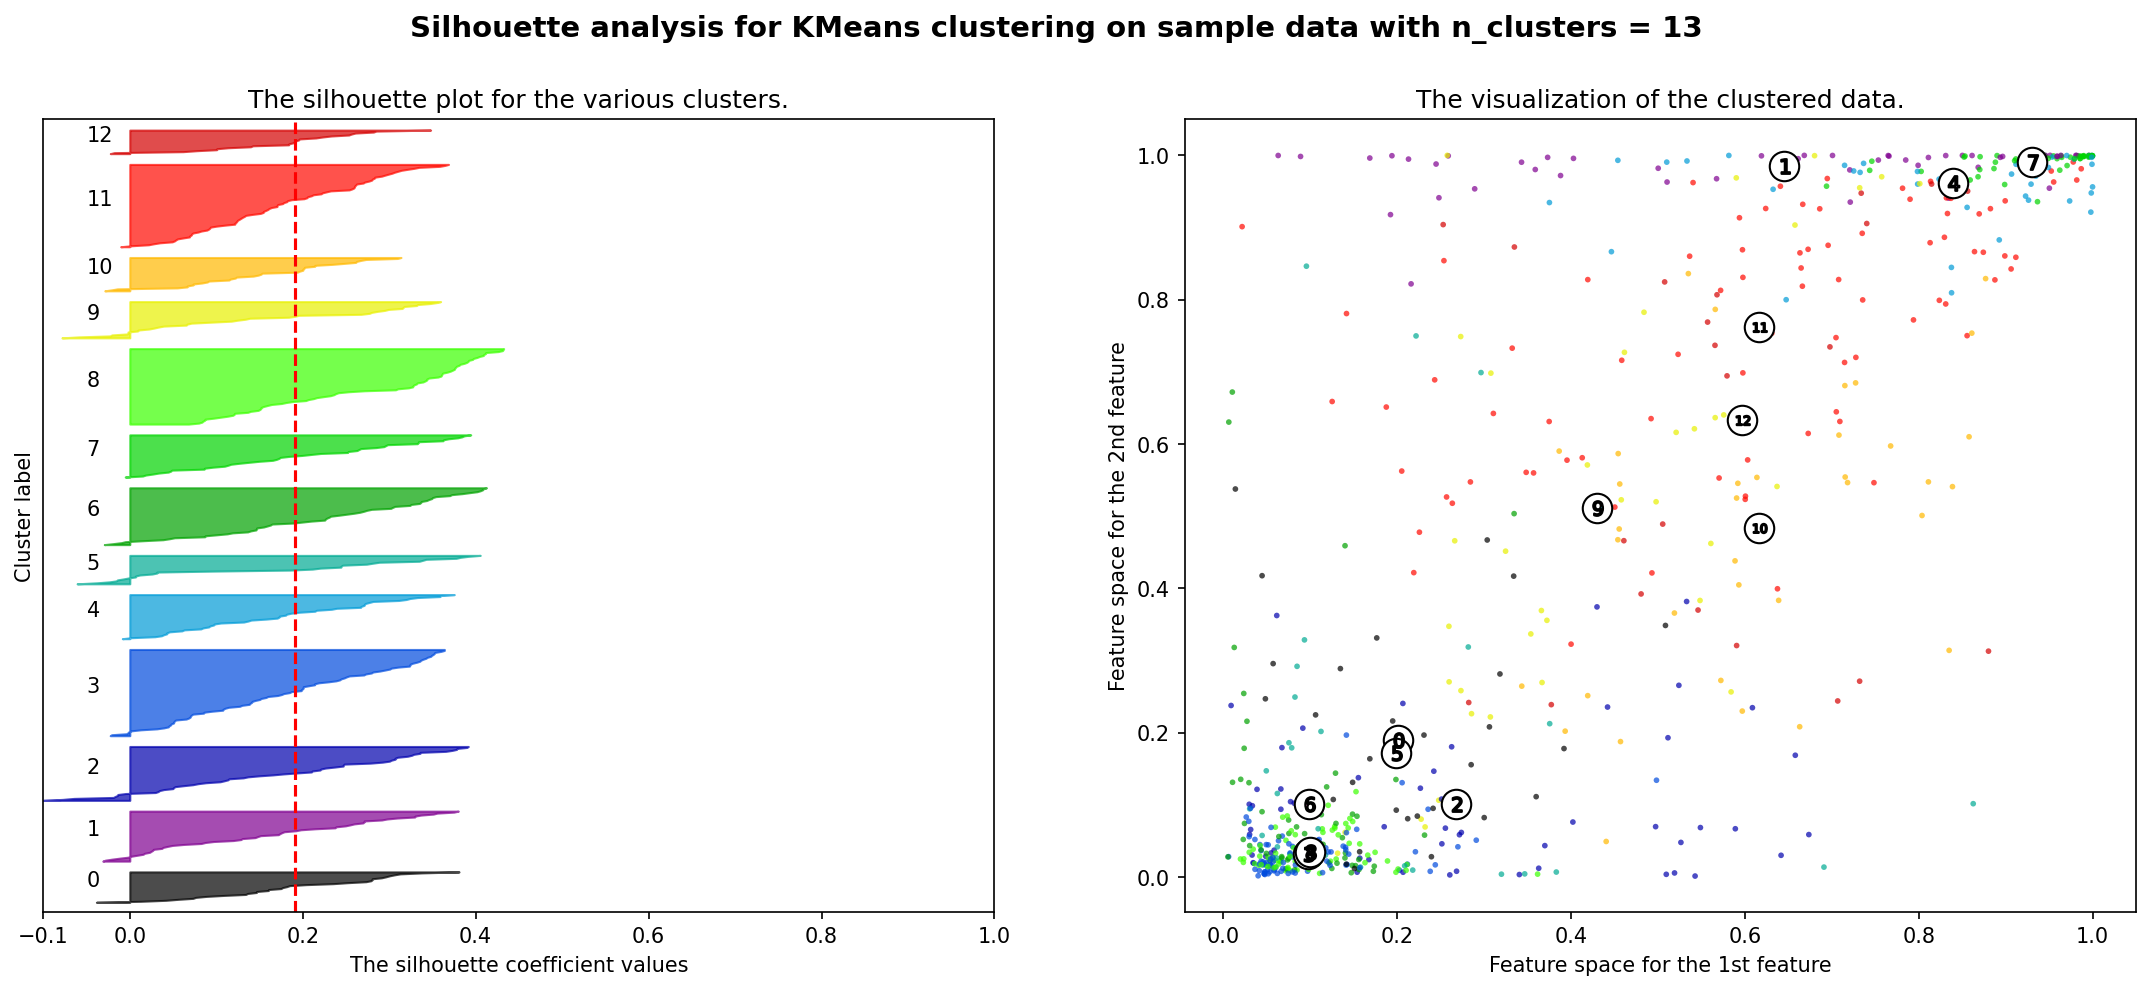

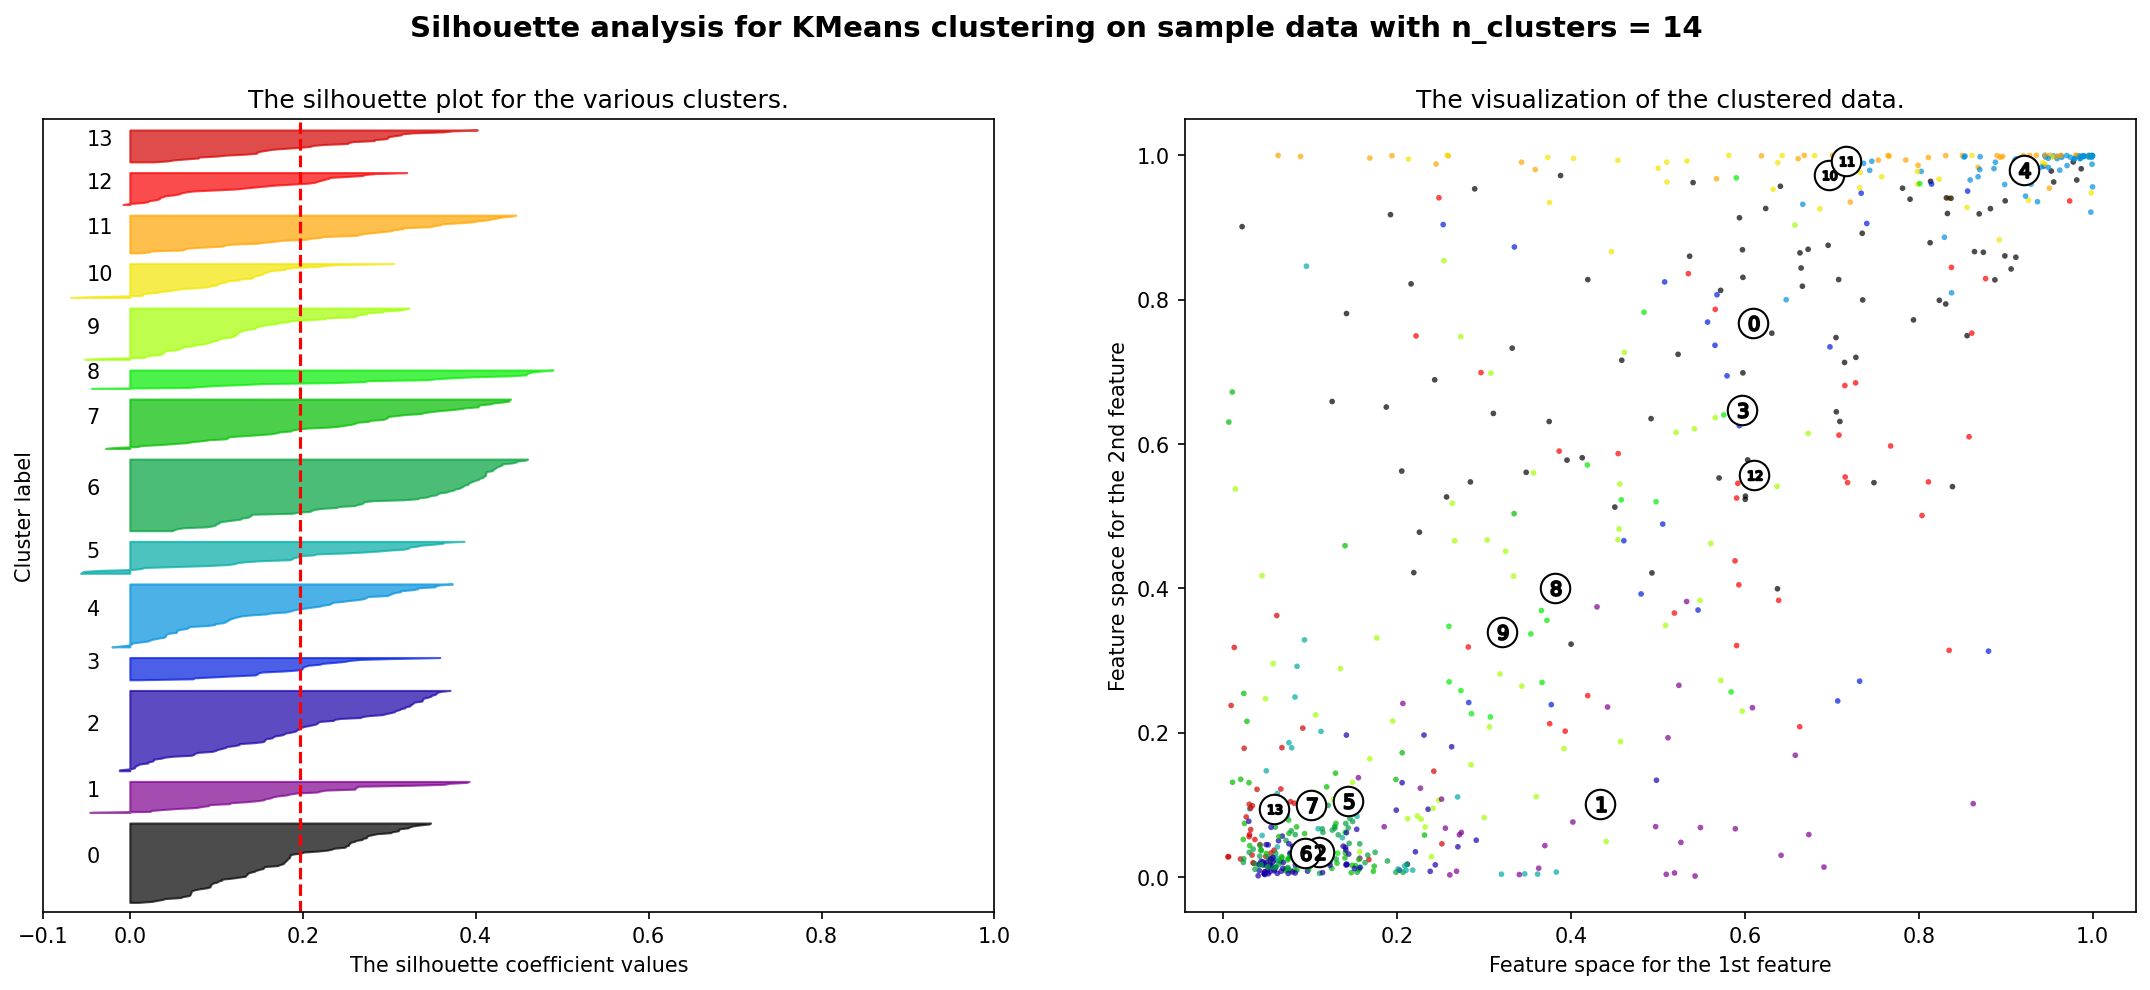

In [276]:
run_multiple_cluster_comparisons(all_embeddings)

For n_clusters = 2 The average silhouette_score is : 0.2853240240508459
For n_clusters = 3 The average silhouette_score is : 0.20565484159908104
For n_clusters = 4 The average silhouette_score is : 0.21471475029448656
For n_clusters = 5 The average silhouette_score is : 0.2111738455336111
For n_clusters = 6 The average silhouette_score is : 0.21483523059175
For n_clusters = 7 The average silhouette_score is : 0.18923962893325152
For n_clusters = 8 The average silhouette_score is : 0.1936666378502985
For n_clusters = 9 The average silhouette_score is : 0.19083861608640595
For n_clusters = 10 The average silhouette_score is : 0.21197071162188938
For n_clusters = 11 The average silhouette_score is : 0.1882657645953812
For n_clusters = 12 The average silhouette_score is : 0.18438493479412565
For n_clusters = 13 The average silhouette_score is : 0.19178913787964263
For n_clusters = 14 The average silhouette_score is : 0.1943378817553553


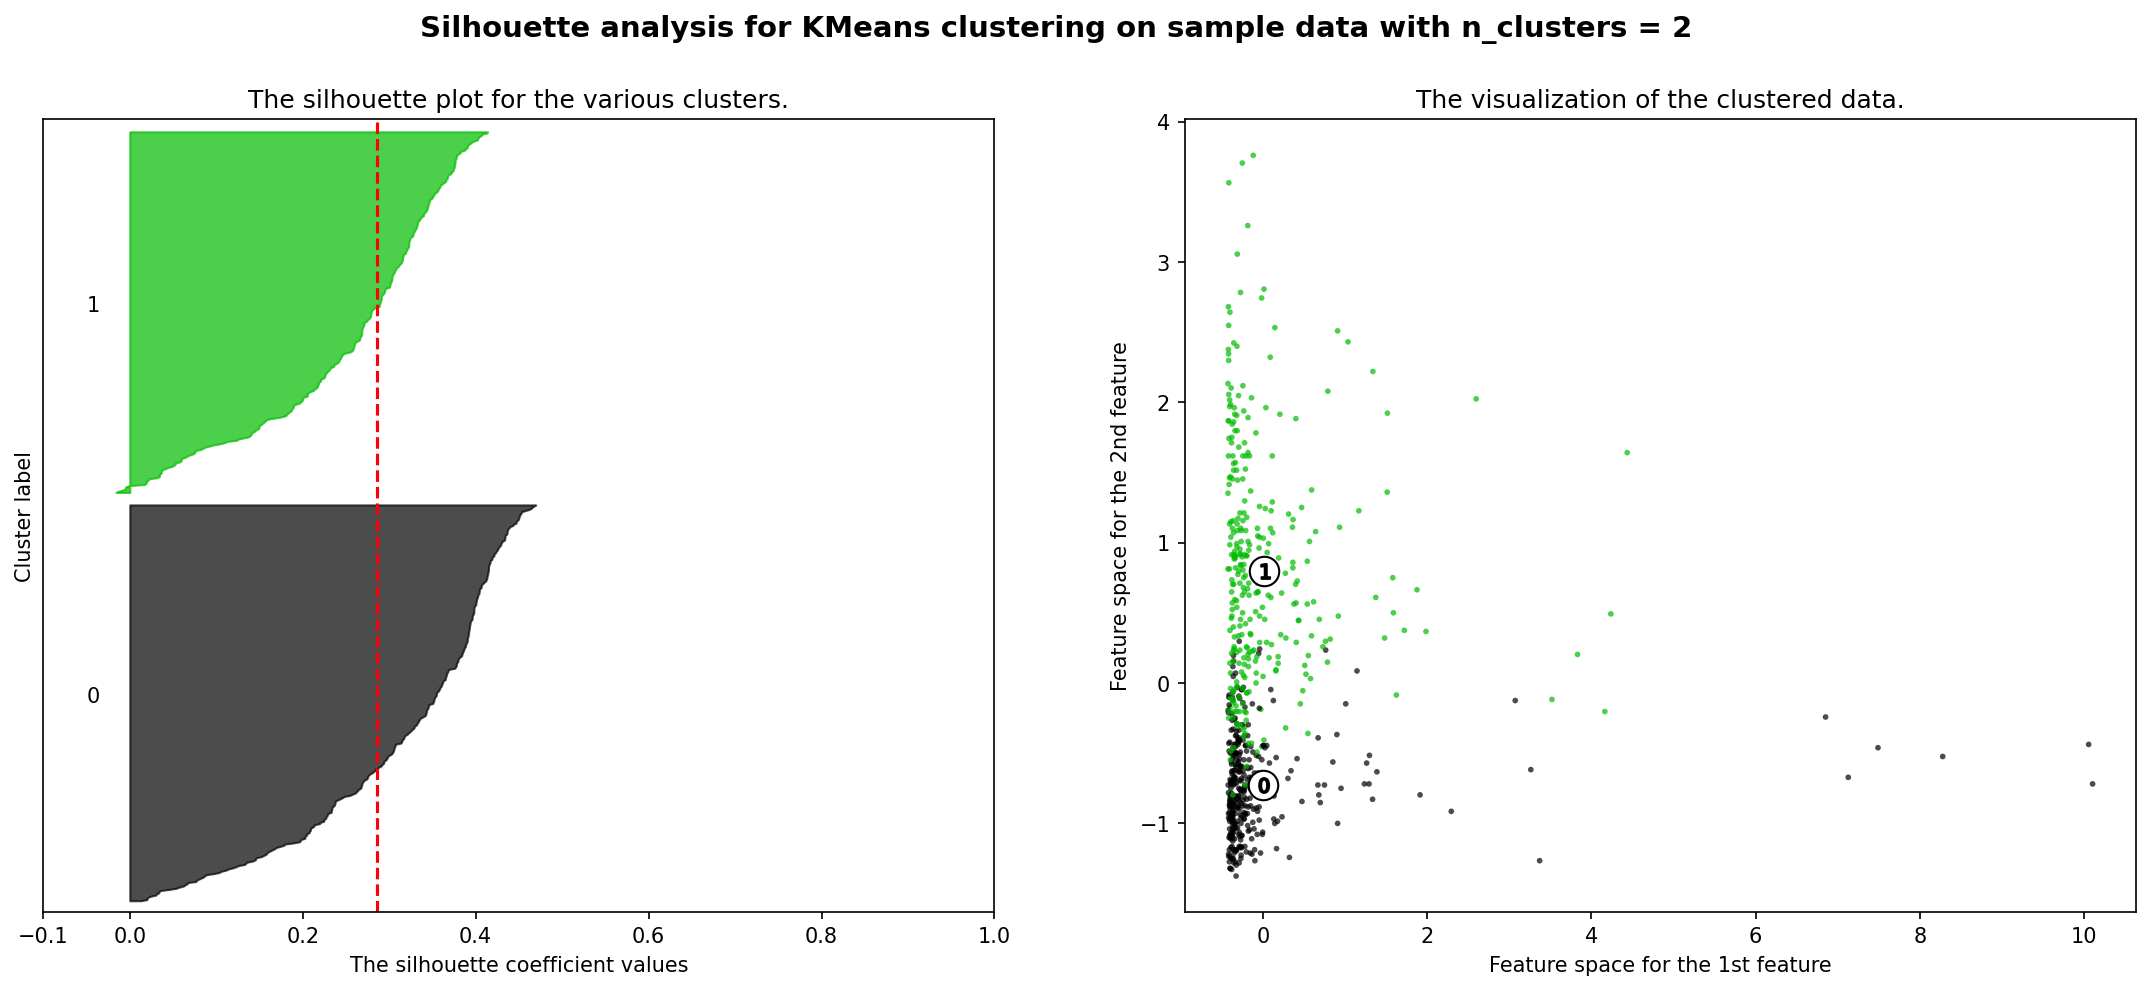

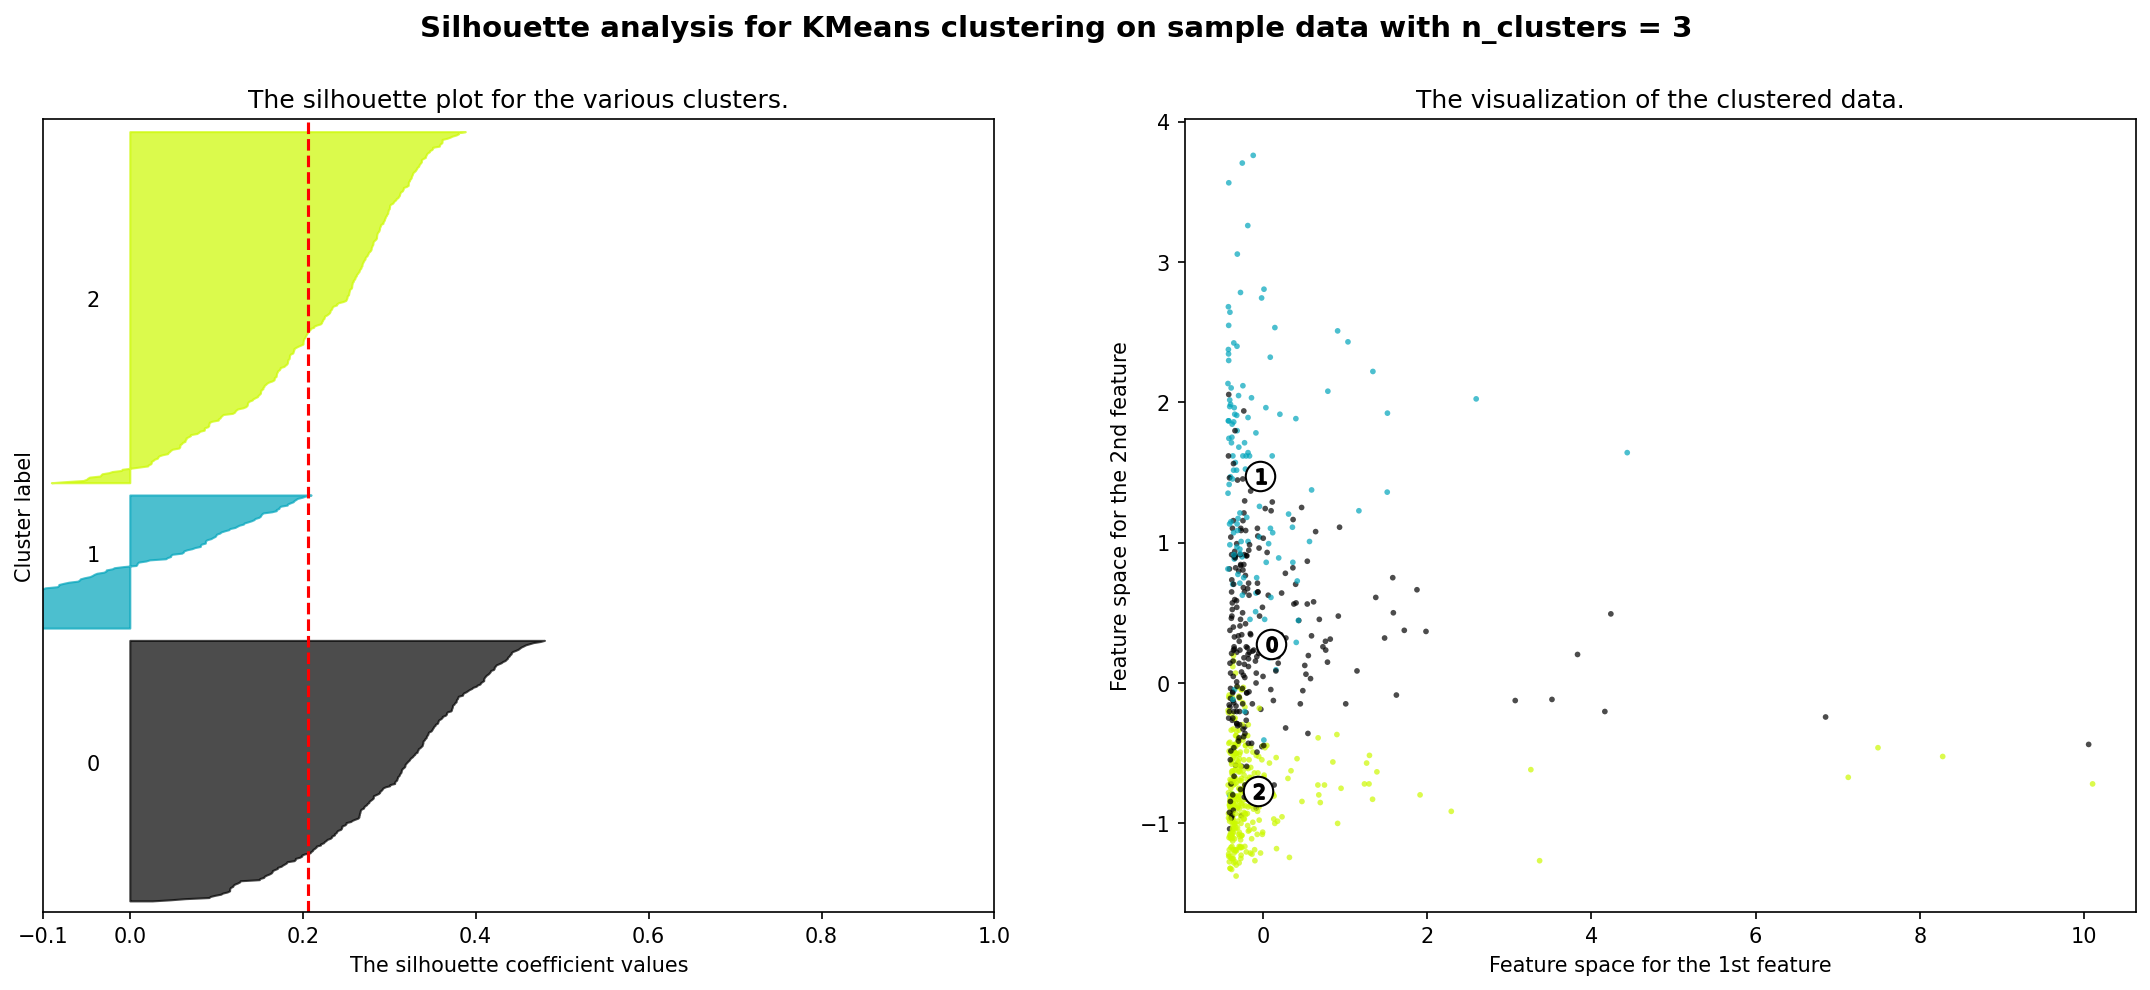

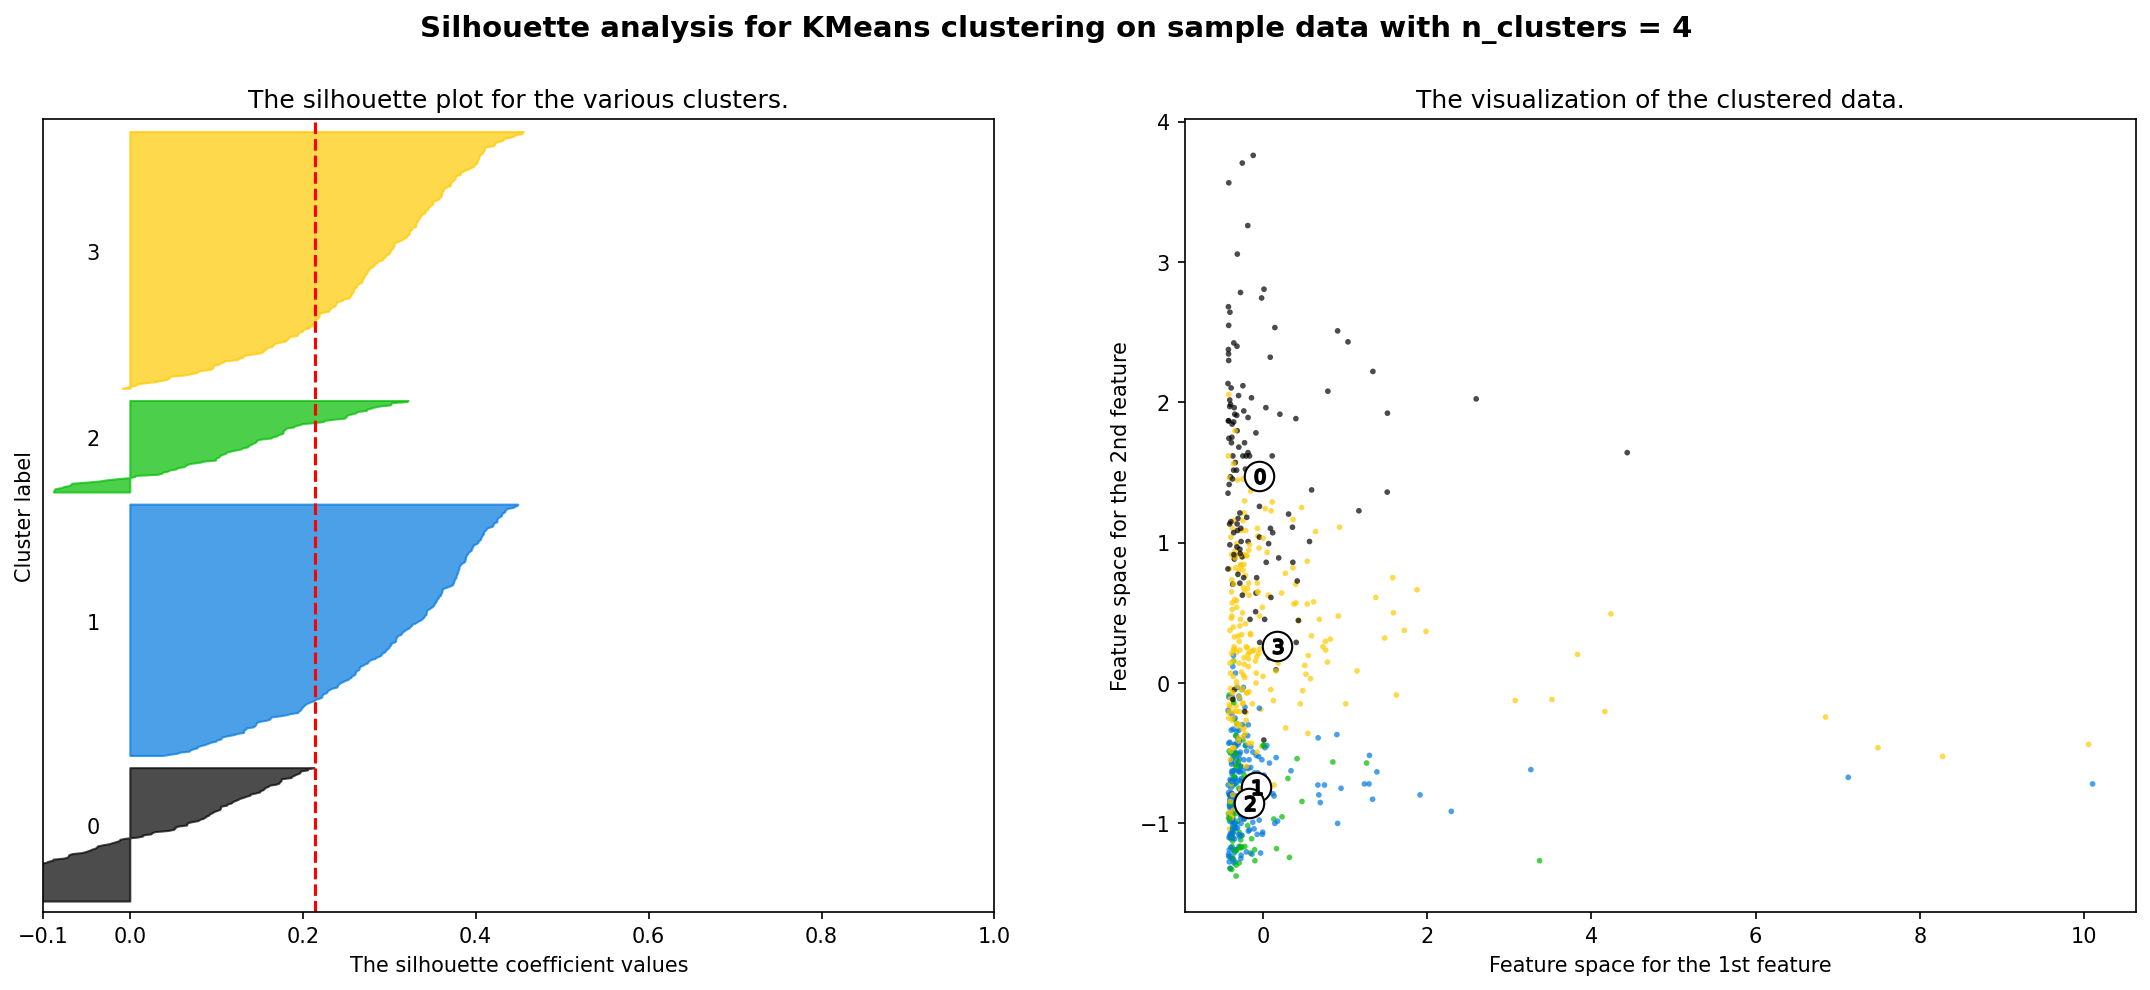

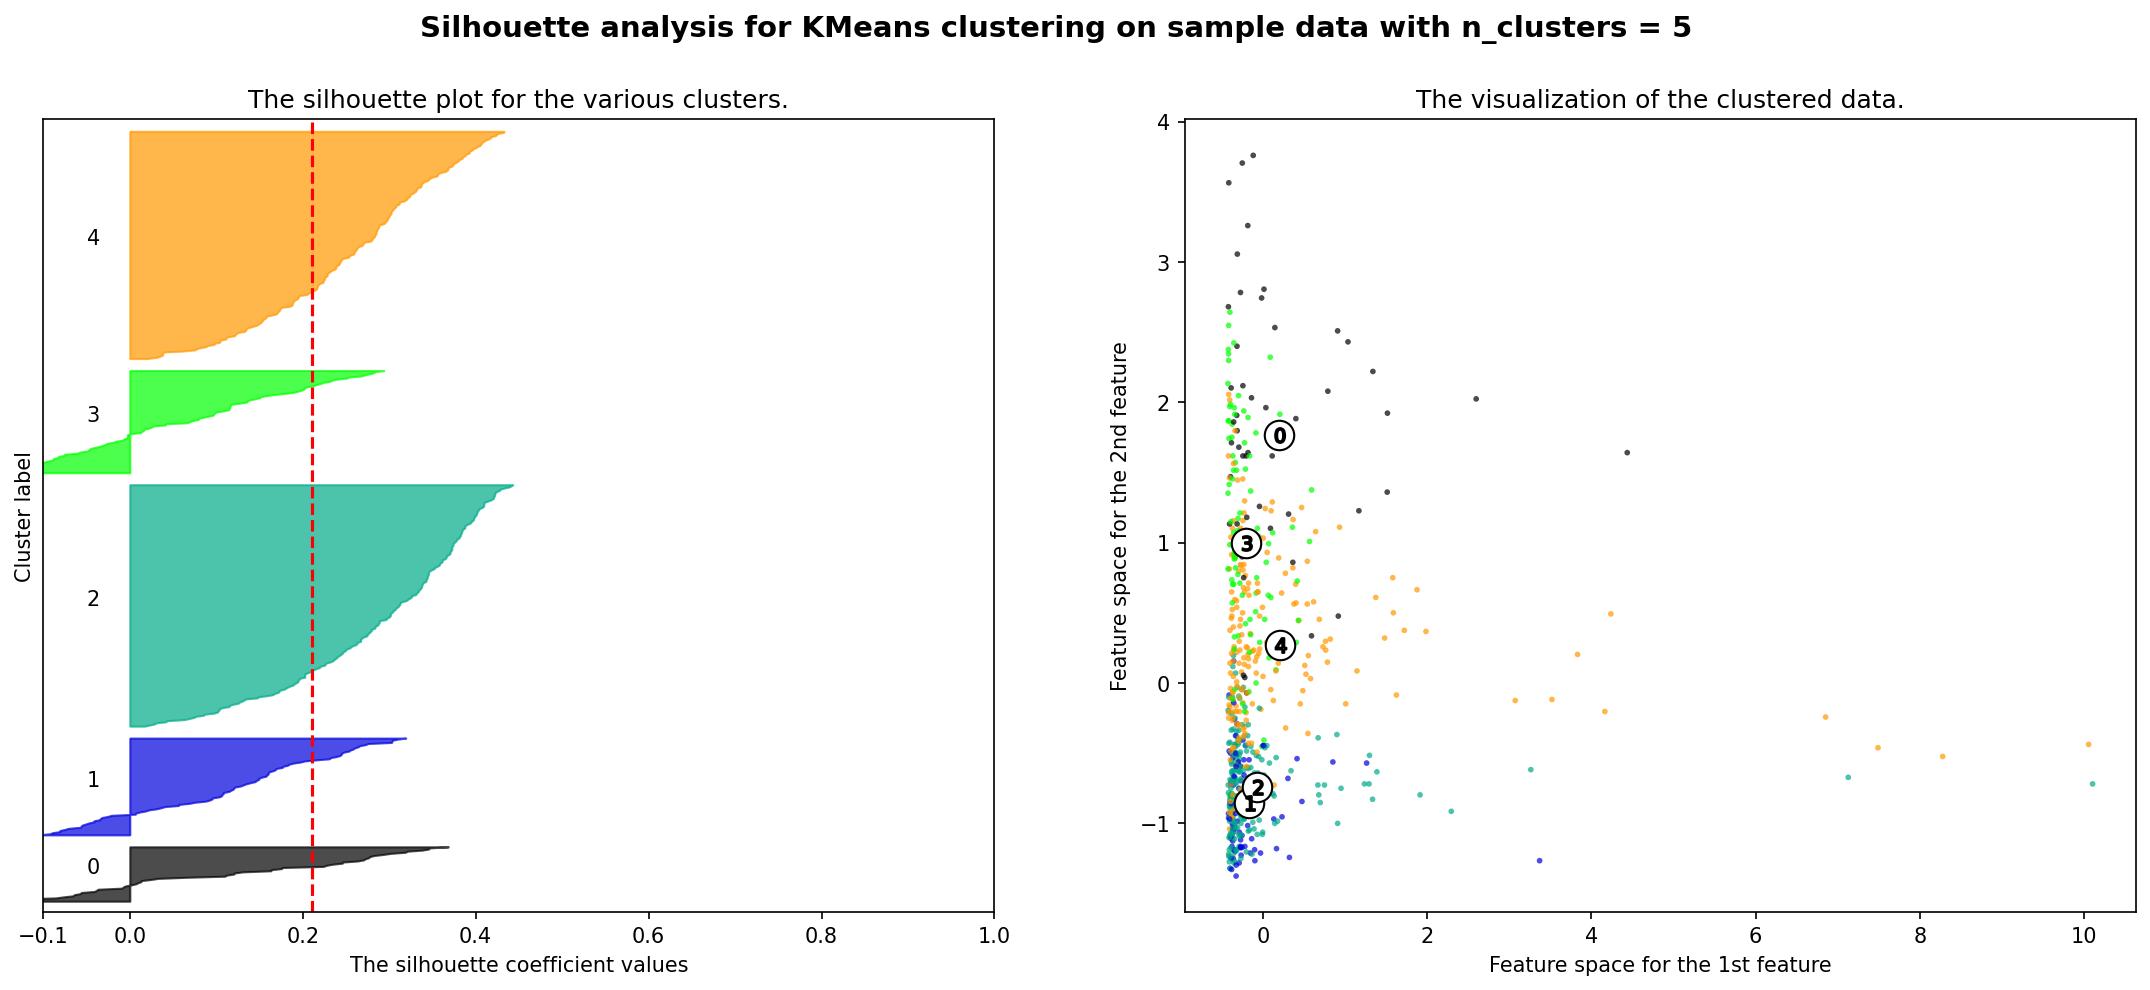

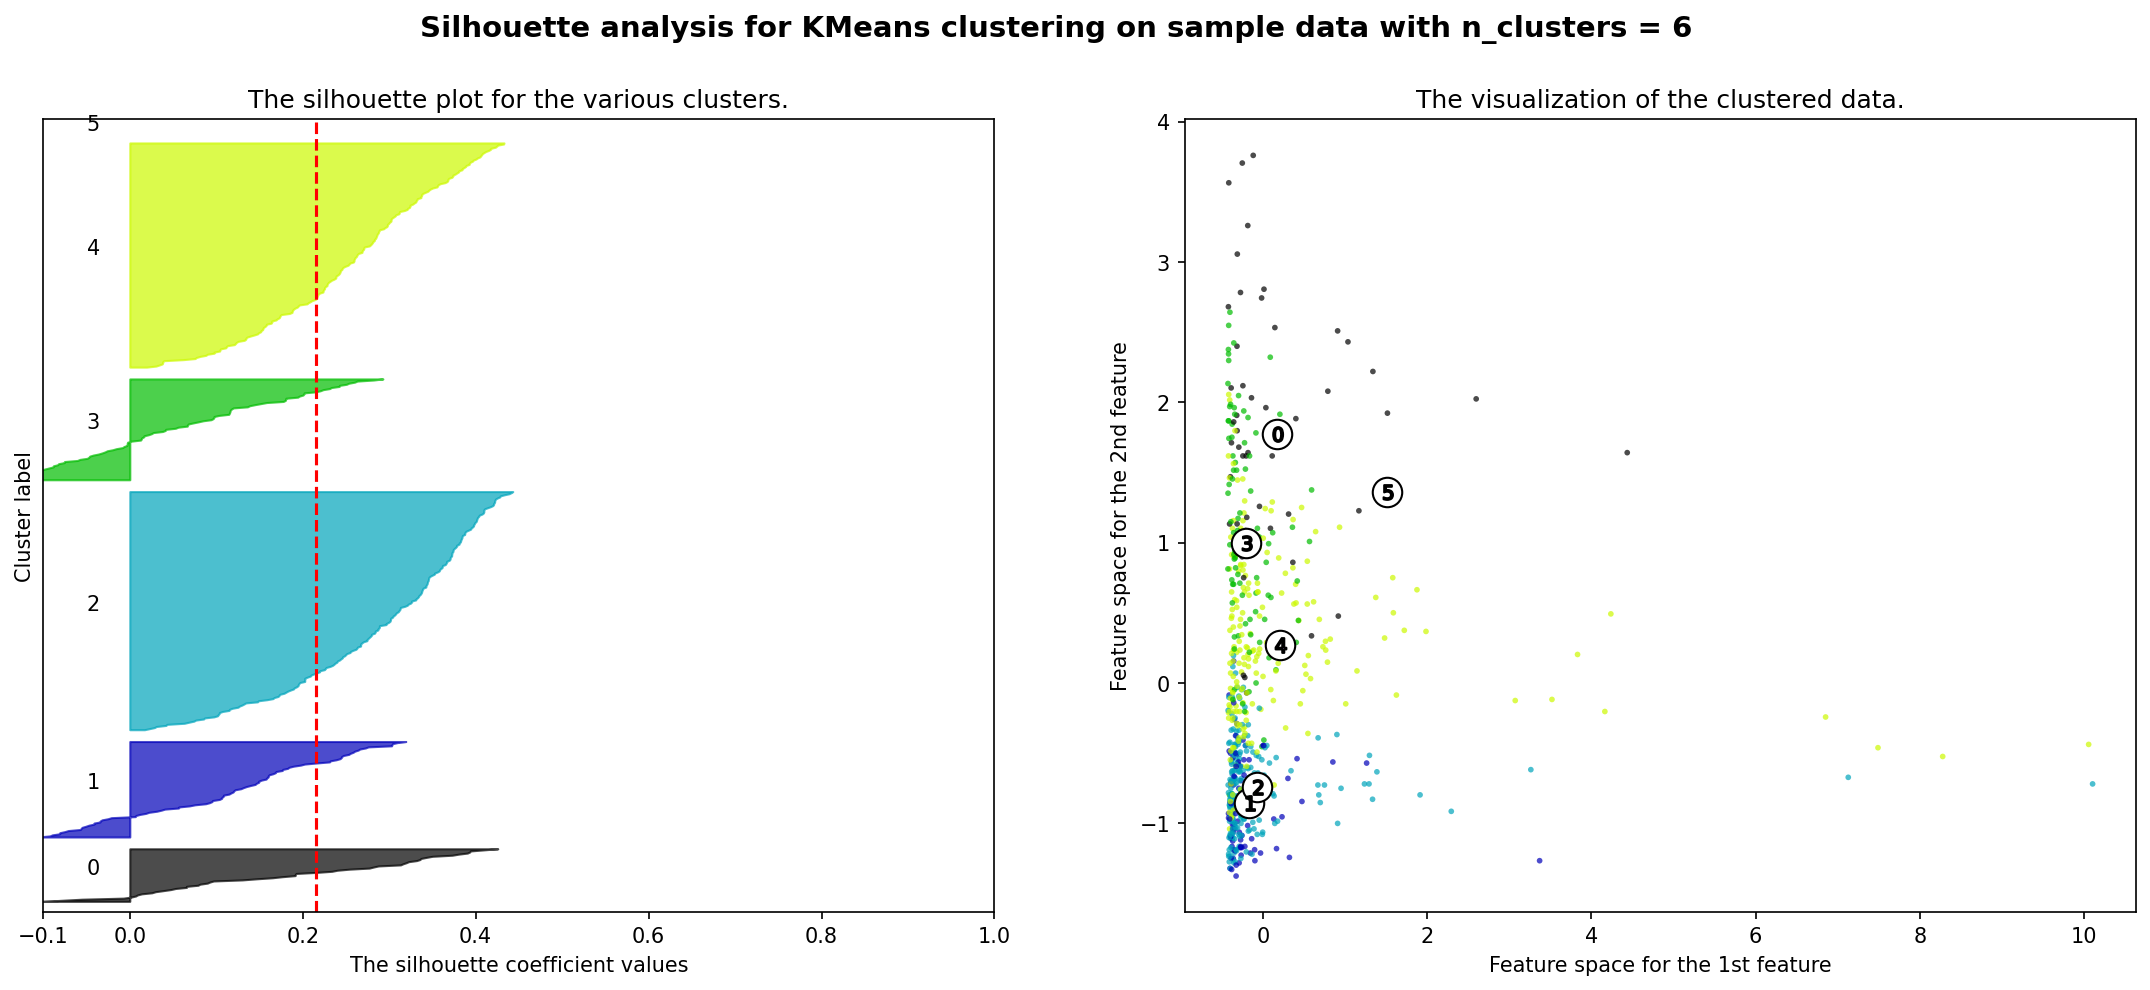

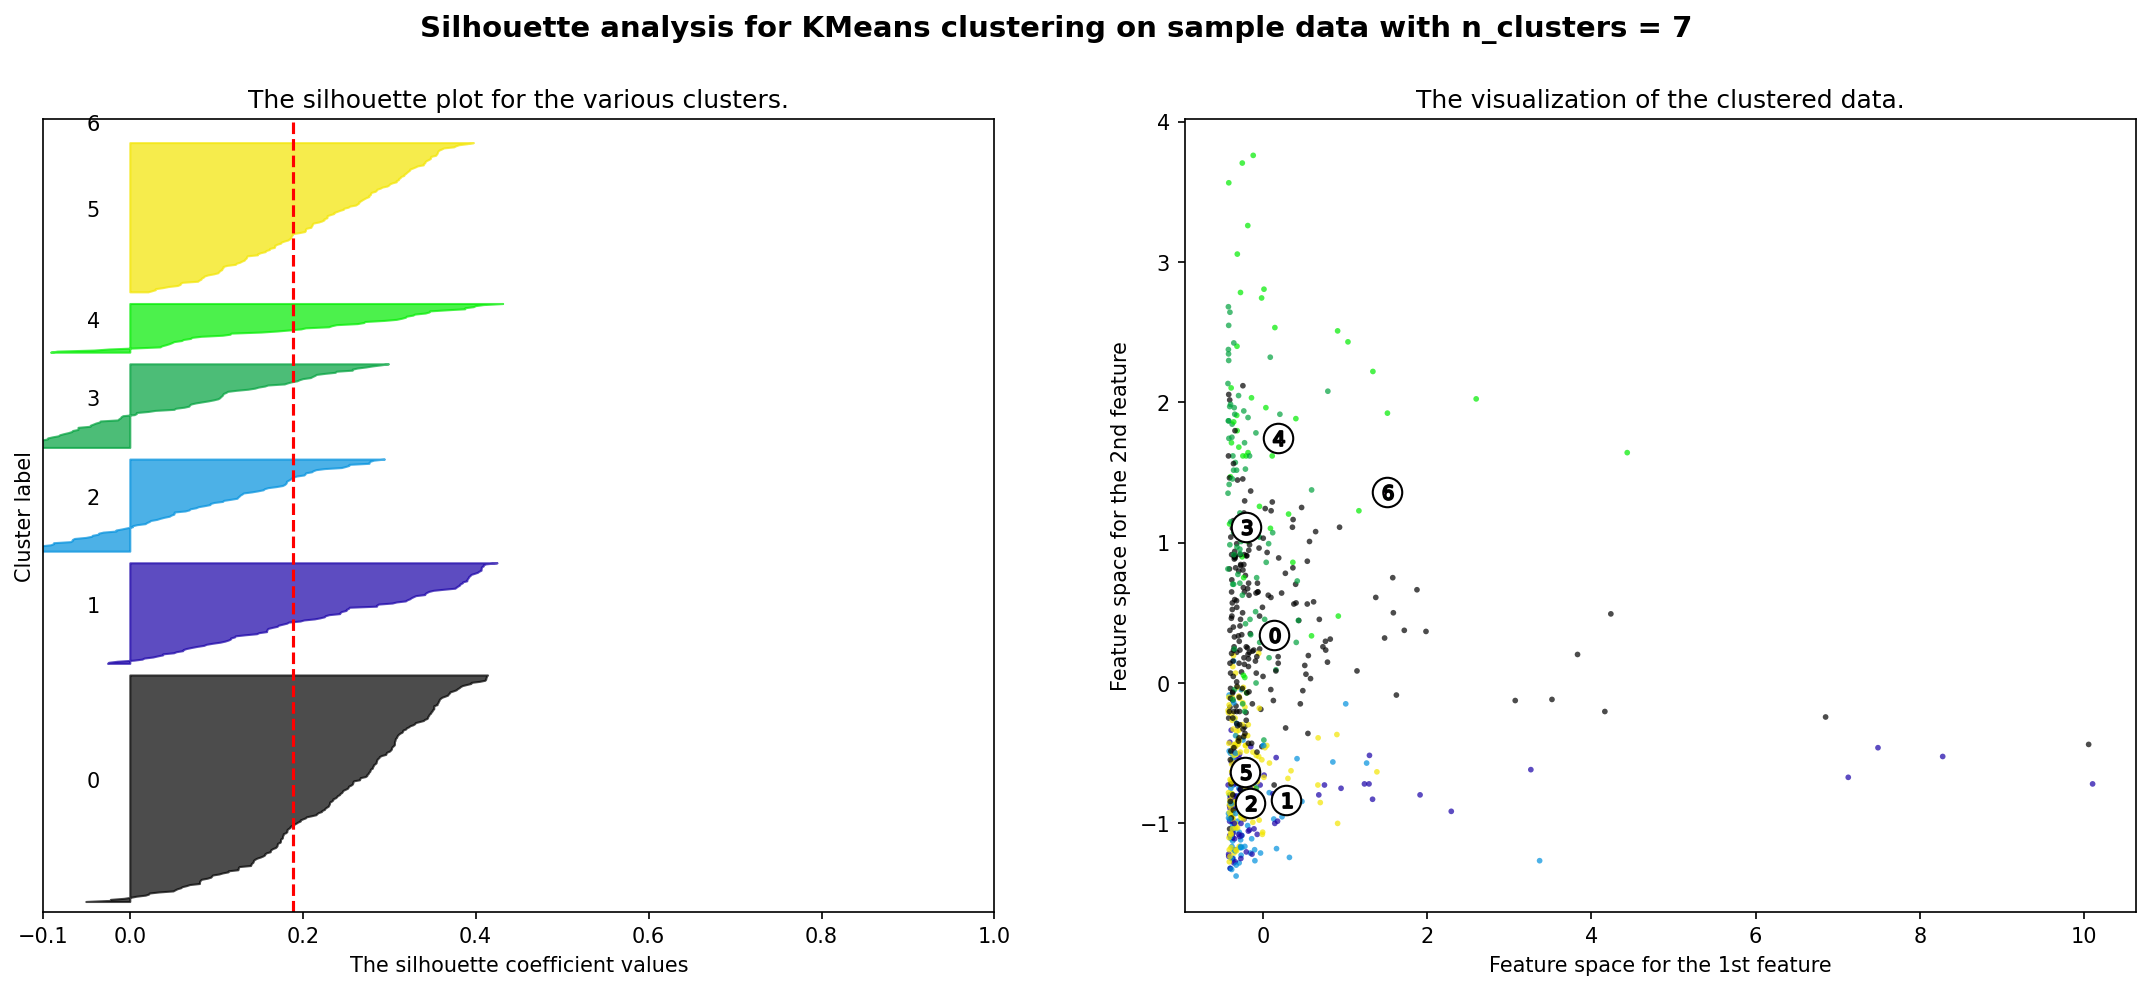

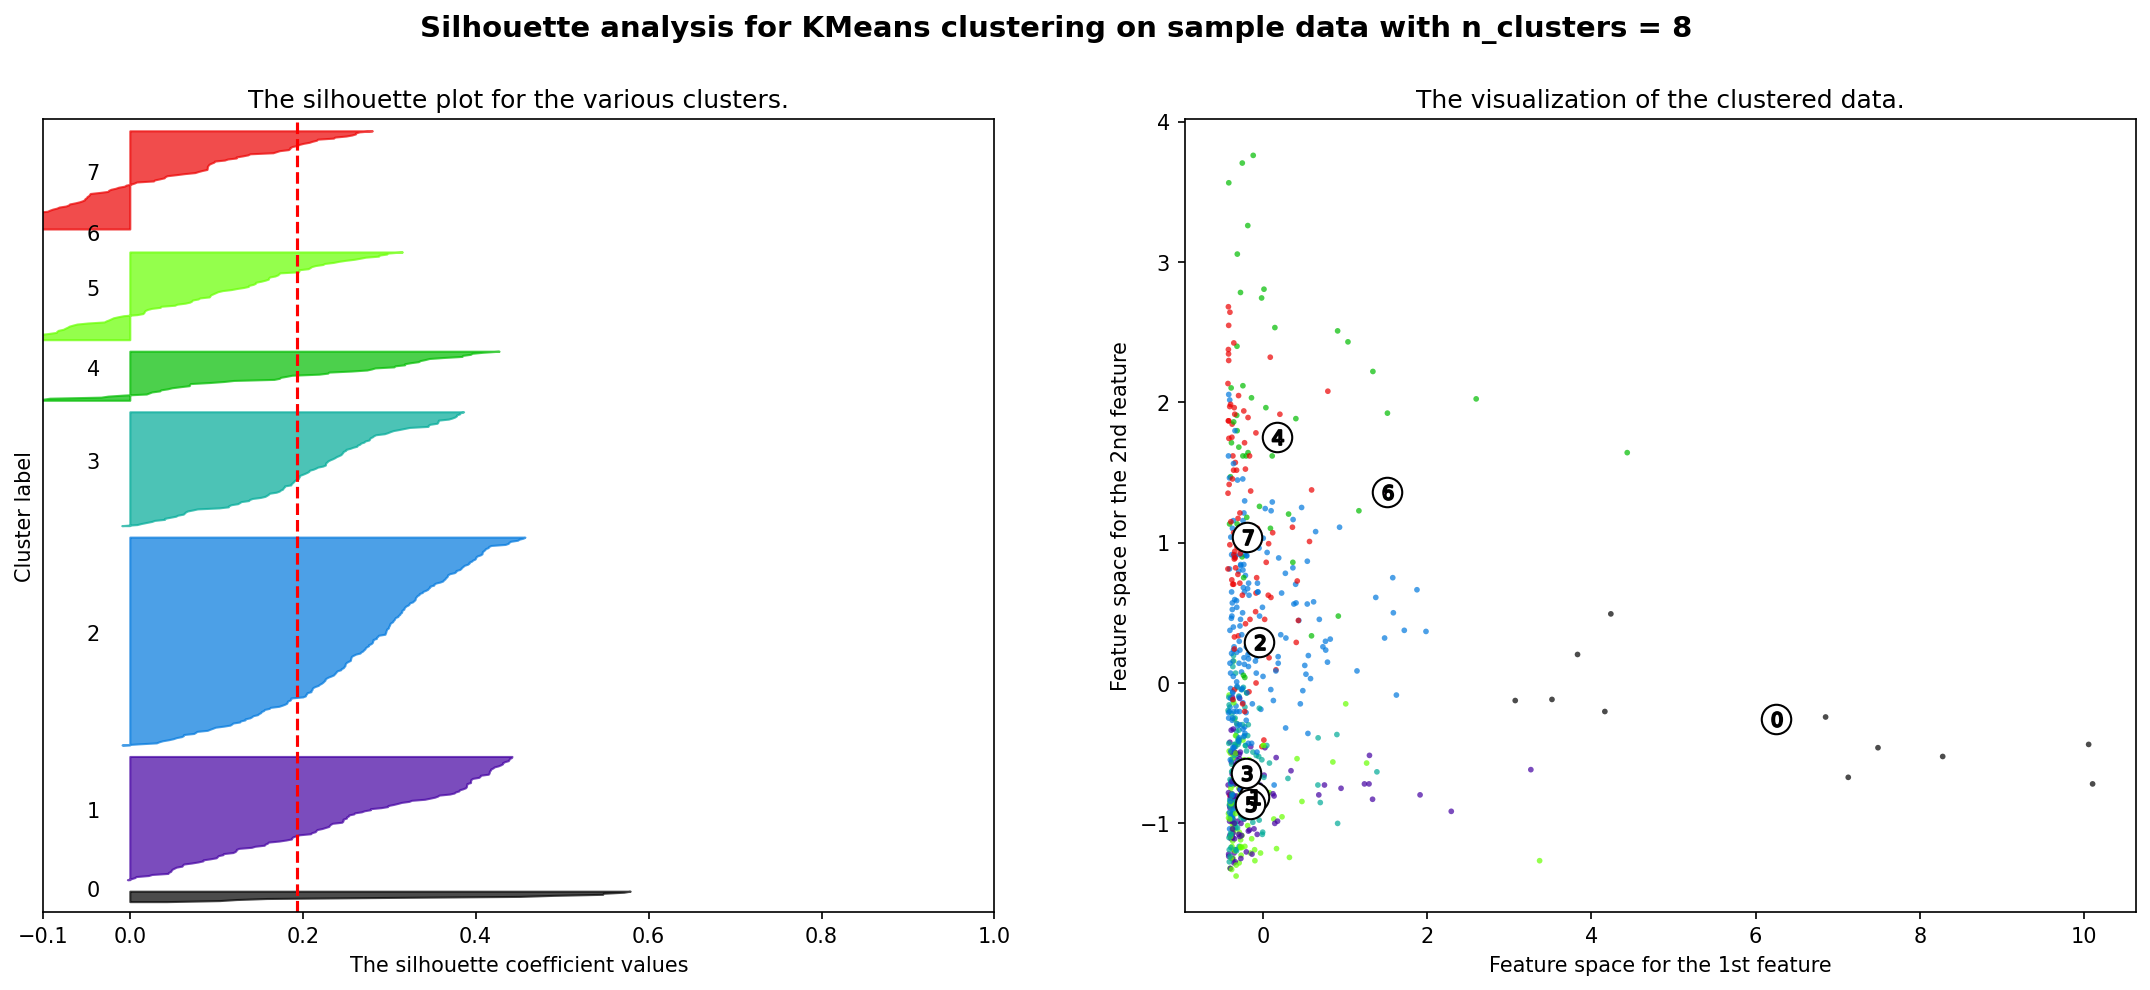

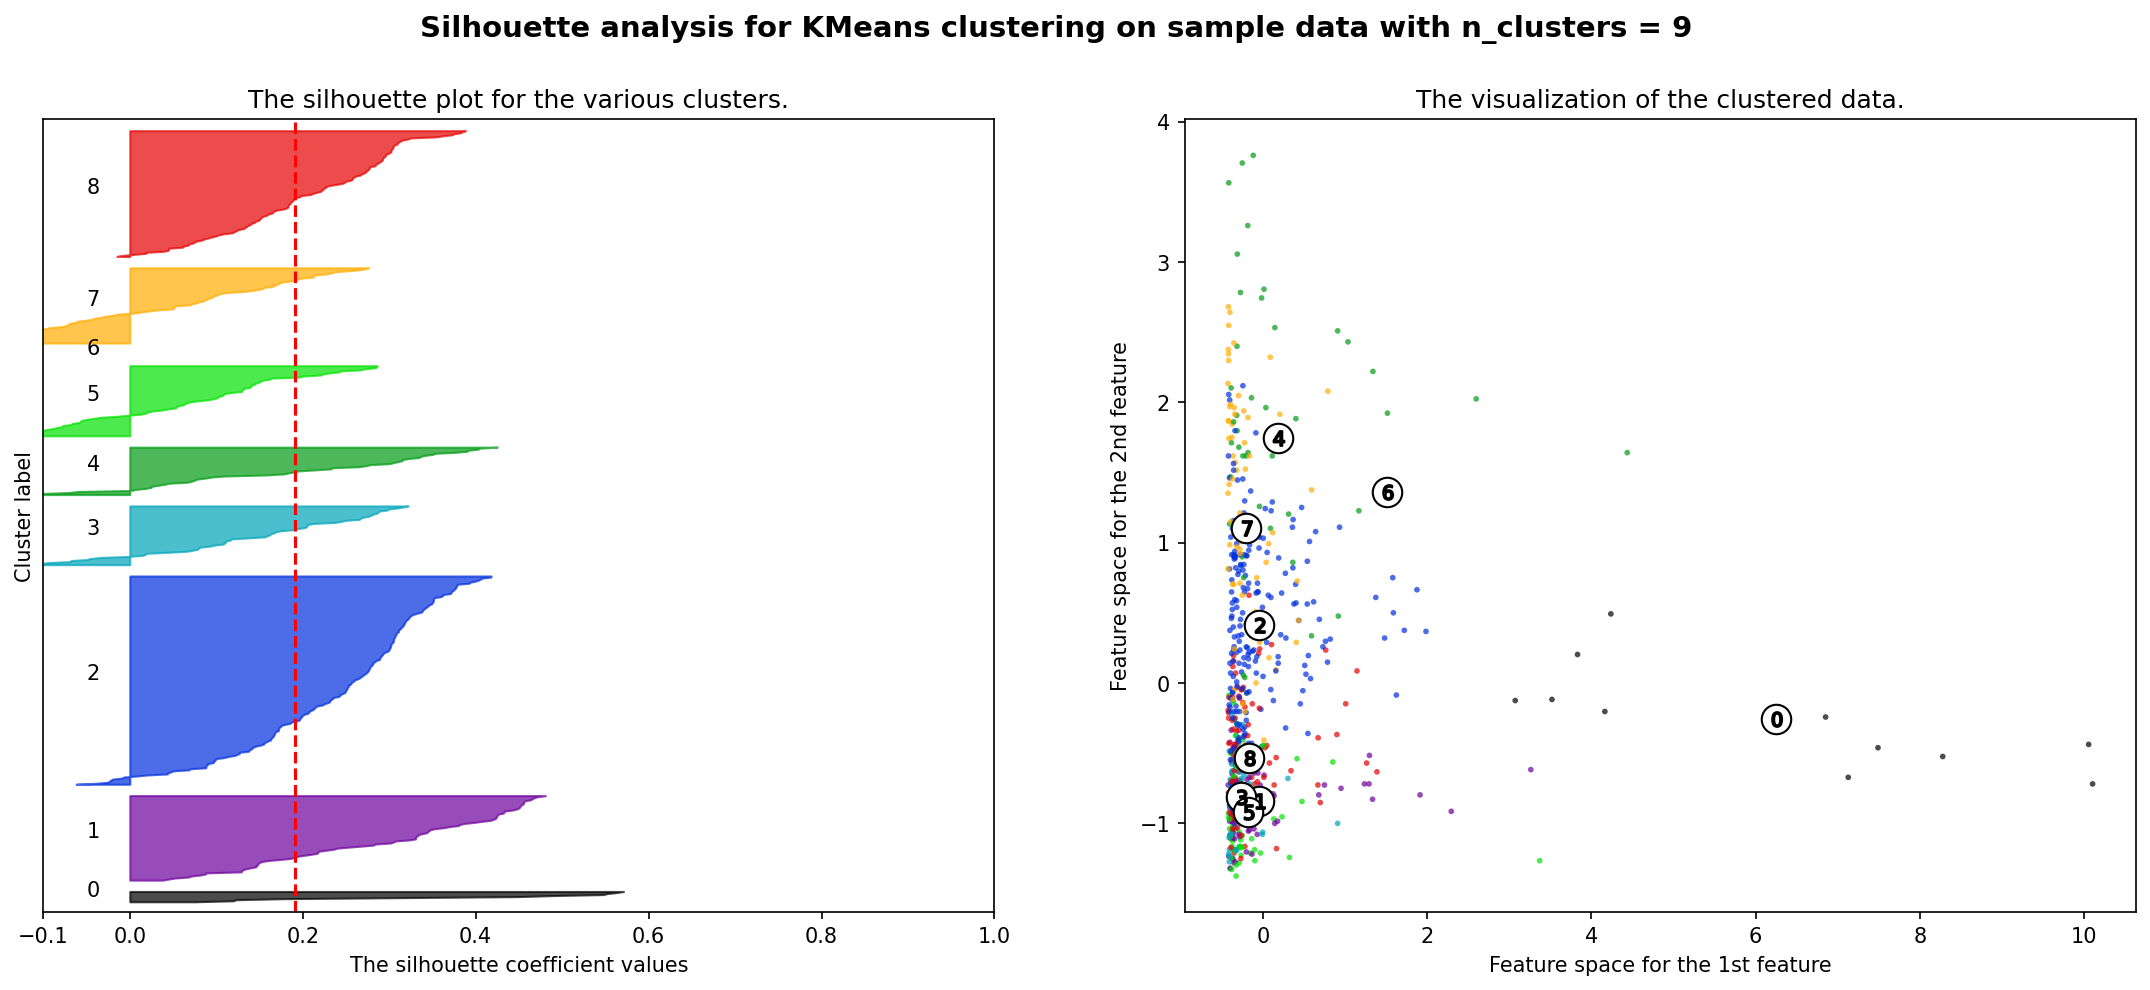

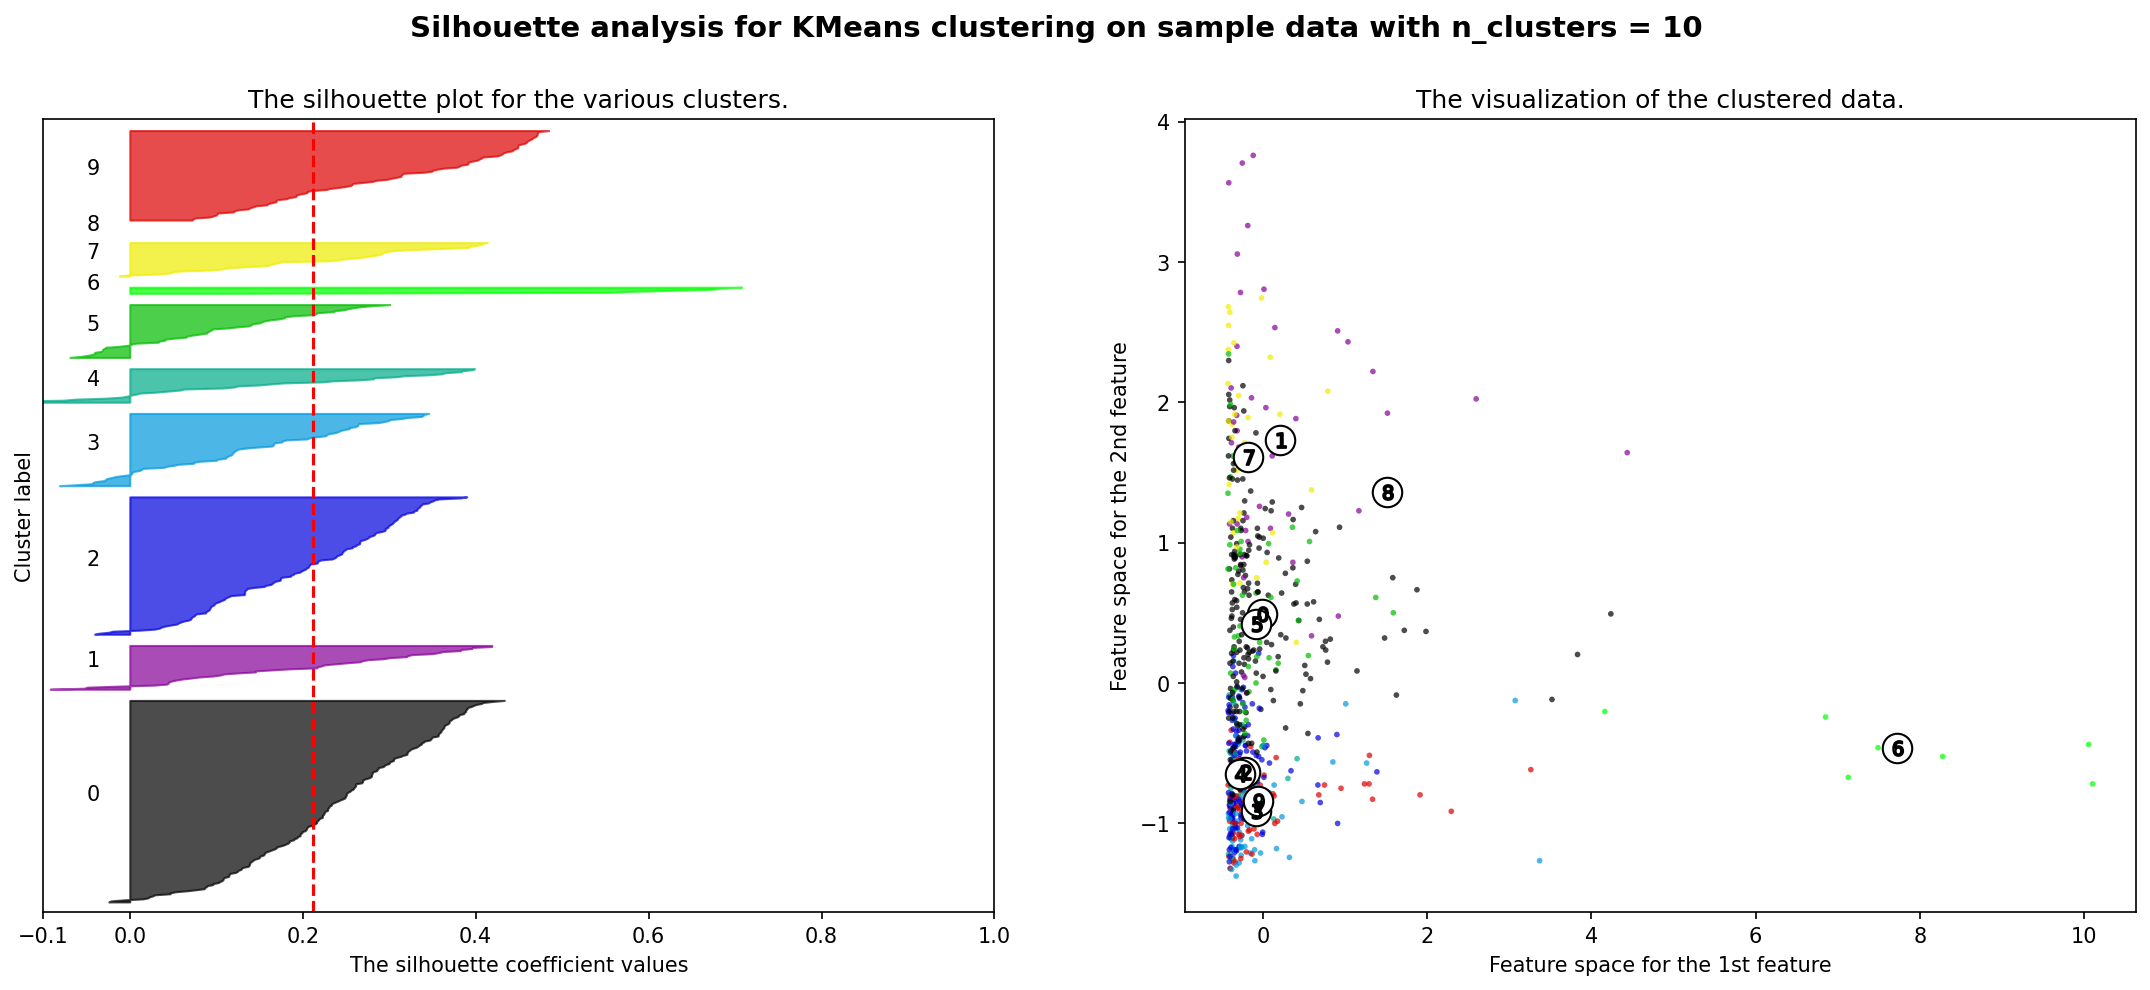

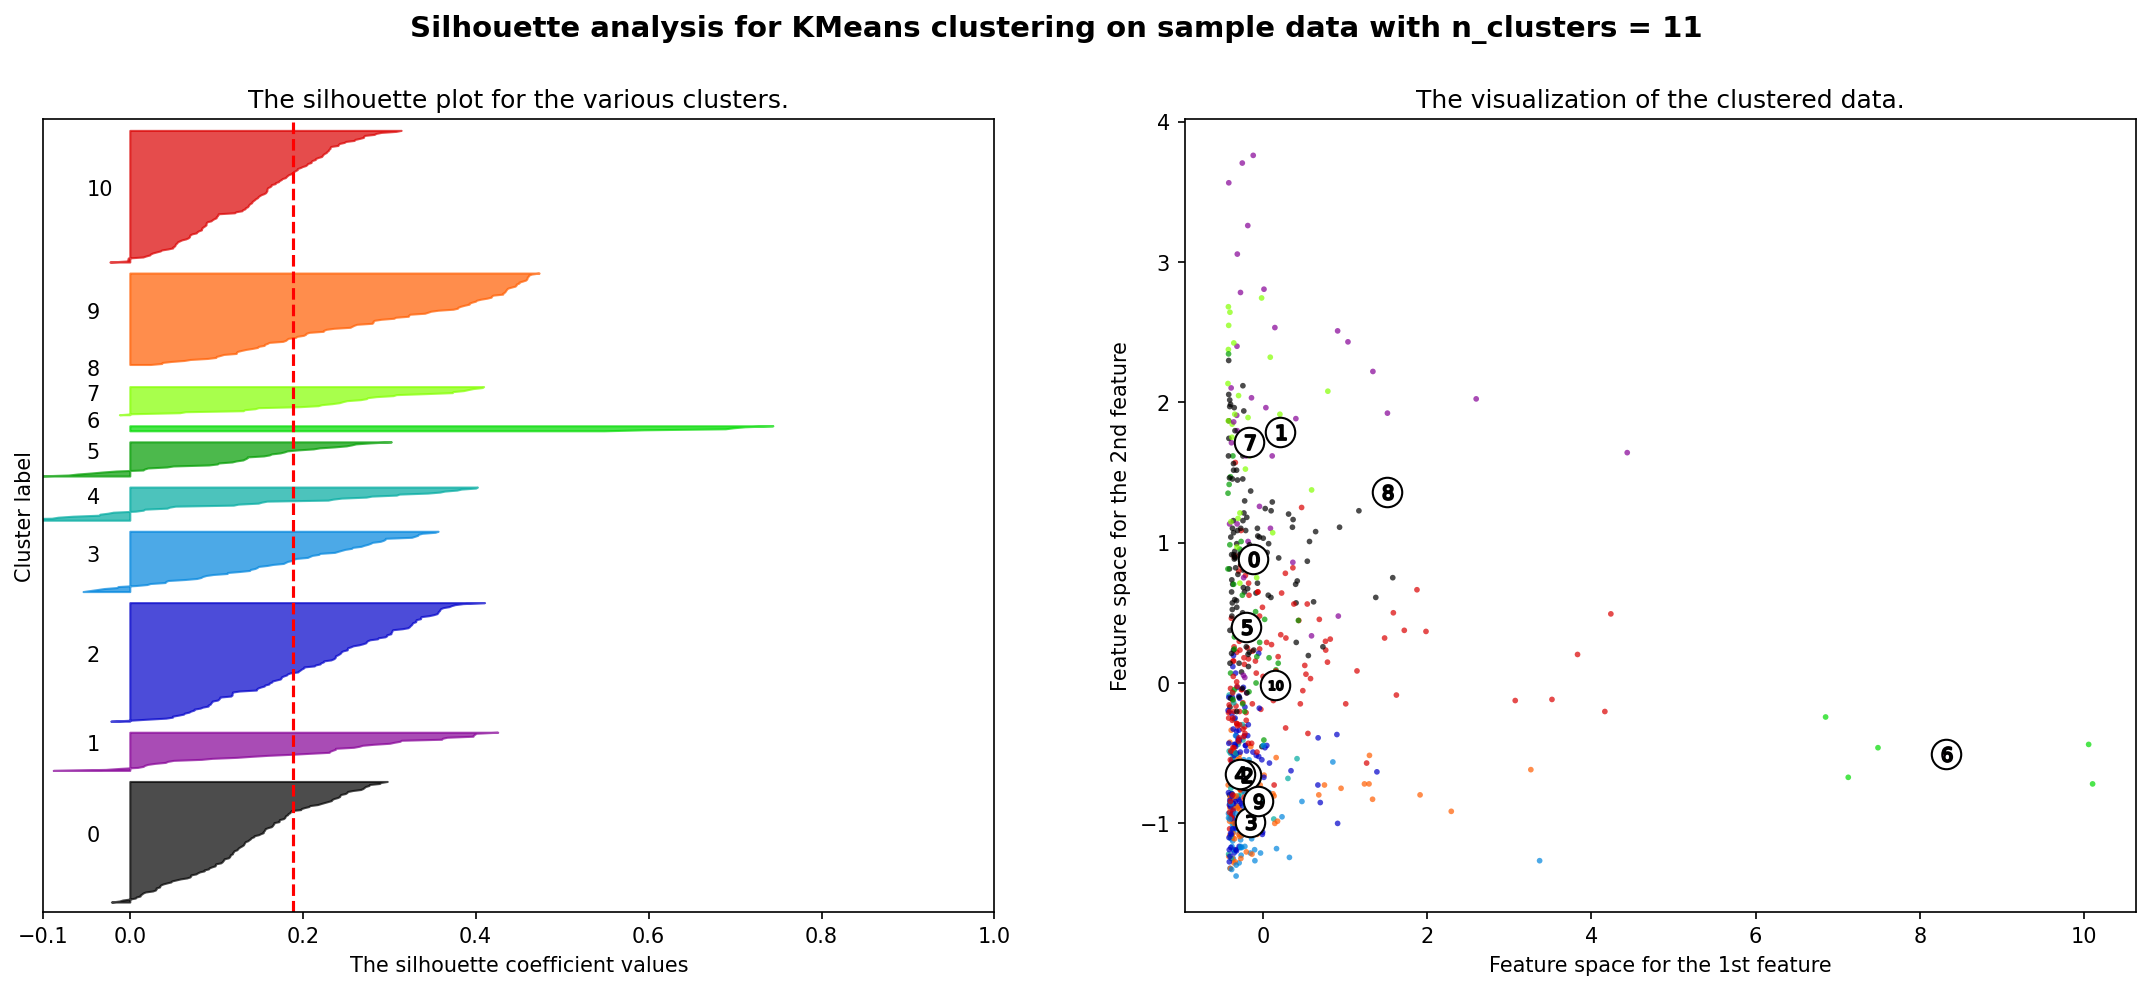

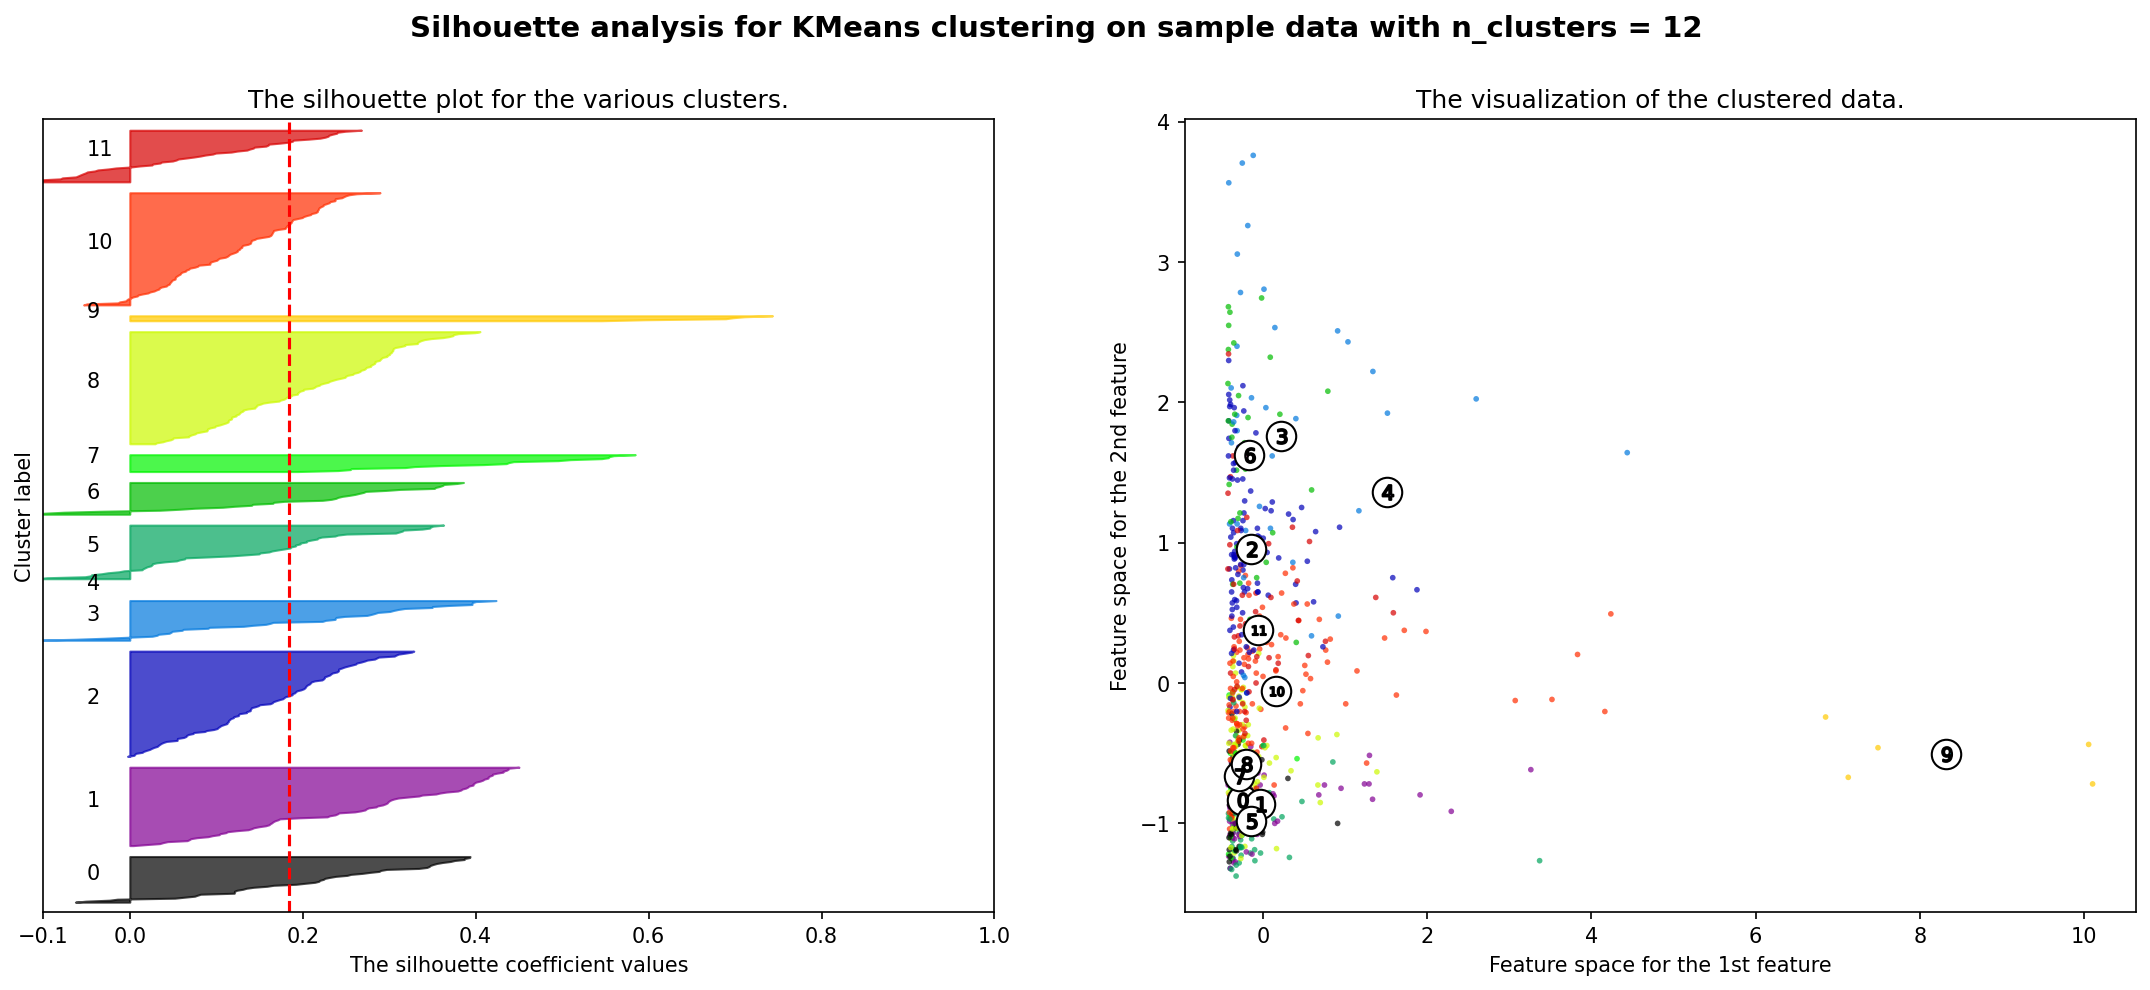

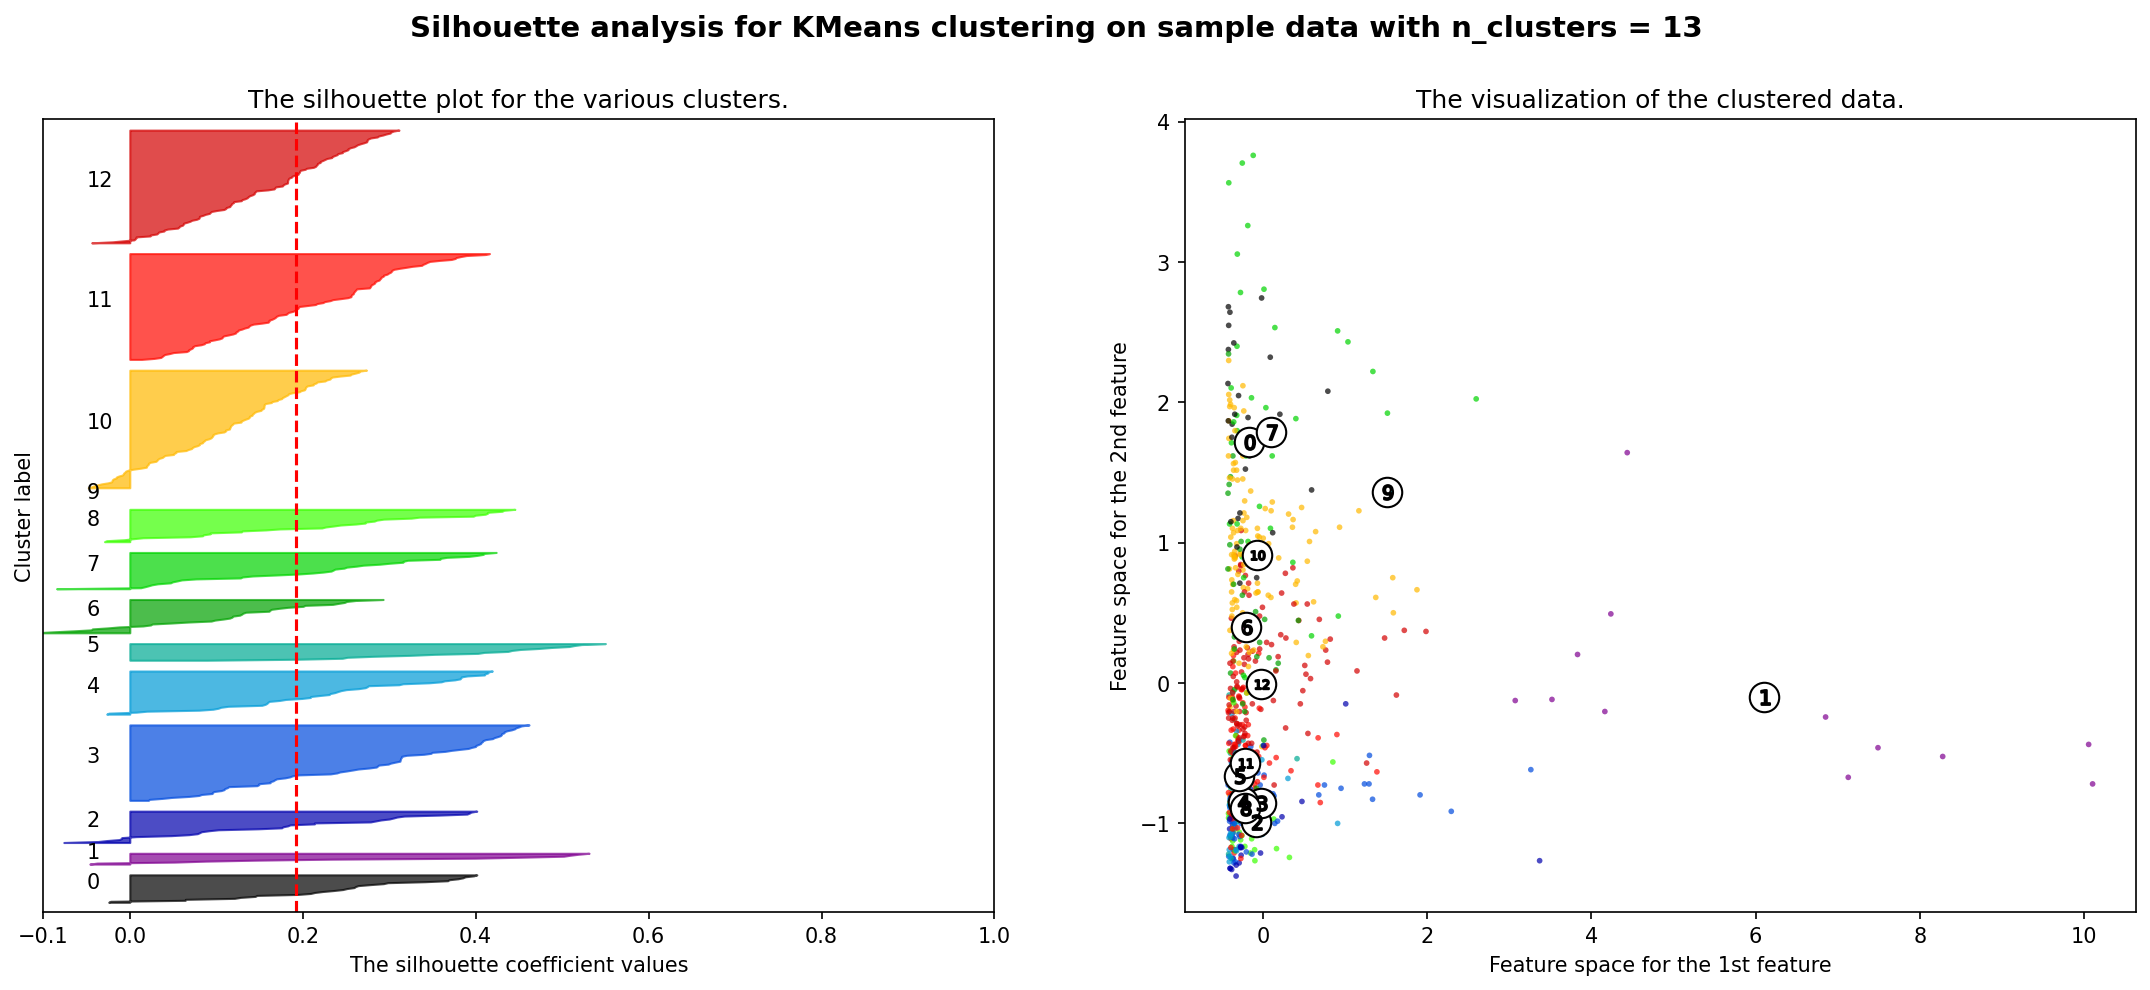

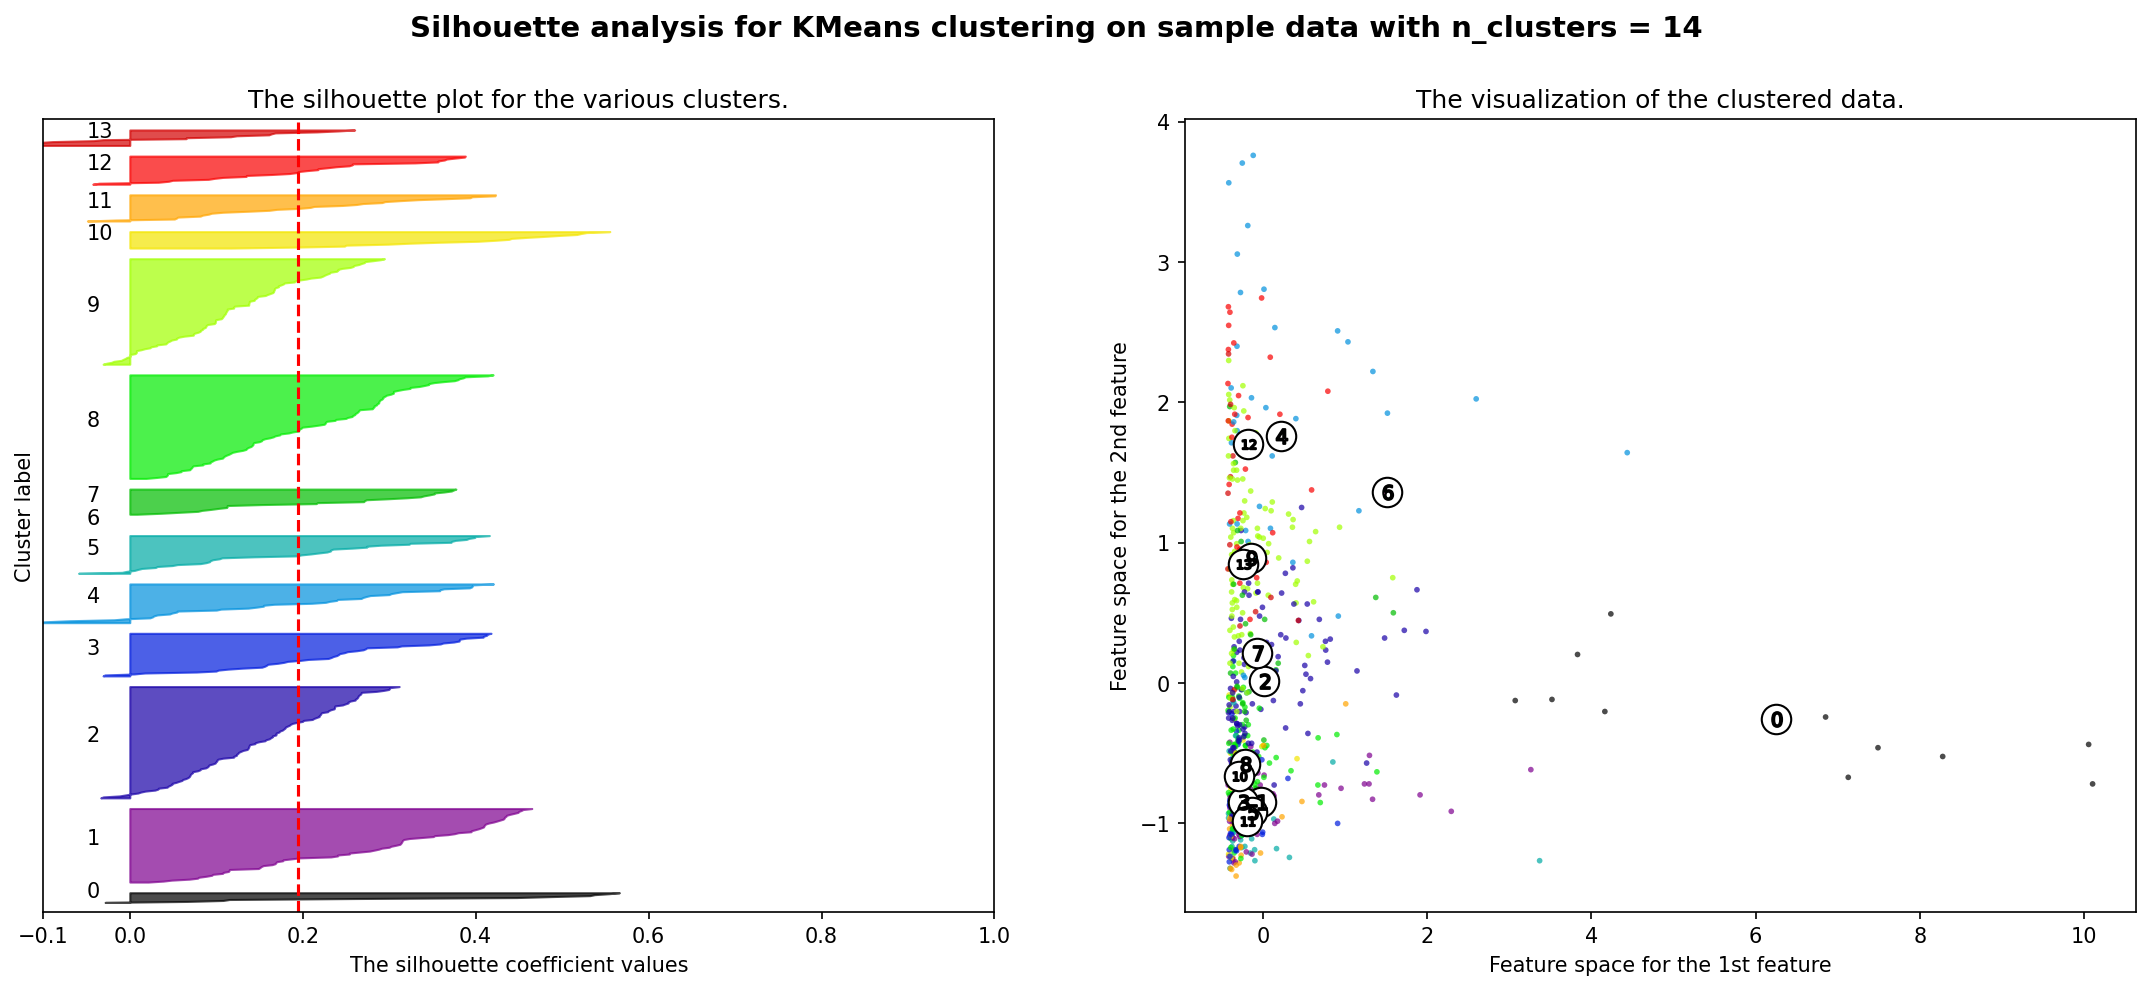

In [538]:
run_multiple_cluster_comparisons(raw_features)

# What features are we using

In [277]:
display(cfg["camels_attributes"])

['area',
 'elev_mean',
 'dpsbar',
 'sand_perc',
 'silt_perc',
 'clay_perc',
 'porosity_hypres',
 'conductivity_hypres',
 'soil_depth_pelletier',
 'dwood_perc',
 'ewood_perc',
 'crop_perc',
 'urban_perc',
 'reservoir_cap',
 'p_mean',
 'pet_mean',
 'p_seasonality',
 'frac_snow',
 'high_prec_freq',
 'low_prec_freq',
 'high_prec_dur',
 'low_prec_dur']

In [278]:
display(cfg["dynamic_inputs"])

['precipitation', 'peti', 'temperature']